# Kaggle Tabular dataset competitions

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from sklearn.metrics import log_loss
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
import xgboost as xgb
from sklearn.metrics import accuracy_score
import mlflow
import mlflow.xgboost
import mlflow.sklearn
#


In [3]:
!which pip3
# Make a function


/Users/m98612/venv/fradrag2021/bin/pip3


# Load the data to a dataframe

In [4]:
"""
Load in all data used for train and test
"""
# read in data from train and test csv files
train_labels = pd.read_csv('train_labels.csv')
#print out the first 5 rows of the train_labels dataframe


#read all files in folder submission files as dataframes, and concatenate them into one dataframe using tqdm for progress bar
submission_files = os.listdir('submission_files')
submission_files = [file for file in submission_files if file.endswith('.csv')]
submission_dfs = []
for file in tqdm.tqdm(submission_files):
    submission_dfs.append(pd.read_csv('submission_files/'+file)["pred"])

submission_df2 = pd.concat(submission_dfs, axis=1)


#make colnames filename:
columns = [i for i in submission_files]
#remove .csv from columns names:
columns = [i[:-4] for i in columns]
submission_df2.columns = columns



100%|██████████| 5000/5000 [00:58<00:00, 84.82it/s] 


In [5]:
submission_df2

,0.7131772137,0.6935182933,0.7260013220,0.7152632882,0.7005385368,0.6854126675,0.7439608123,0.6945358038,0.7261839834,0.6599155304,...,0.6902588526,0.7092127612,0.6706922694,0.6855709925,0.7114491506,0.6817741142,0.7030287611,0.7331661007,0.6841581492,0.7167146788
0,0.778224,0.762953,0.764103,0.723772,0.803894,0.784736,0.836666,0.775778,0.774012,0.919990,...,0.766138,0.779247,0.327731,0.759982,0.789323,0.782428,0.790650,0.757342,0.781069,0.847858
1,0.569151,0.572876,0.562022,0.762576,0.597722,0.646278,0.555181,0.577722,0.652896,0.579136,...,0.602346,0.499591,0.309518,0.521851,0.623097,0.574567,0.713203,0.603681,0.748823,0.544203
2,0.851960,0.721607,0.894352,0.823561,0.813720,0.798389,0.901490,0.795233,0.823106,0.841735,...,0.770273,0.775682,0.370162,0.844858,0.819129,0.743486,0.800796,0.827598,0.770387,0.834842
3,0.774035,0.713205,0.569785,0.827587,0.752170,0.763516,0.697942,0.757559,0.830138,0.780352,...,0.721262,0.718068,0.708552,0.674332,0.724067,0.675280,0.785302,0.830872,0.710615,0.774971
4,0.947631,0.961040,0.915259,0.890565,0.943416,0.955314,0.950565,0.961459,0.945953,0.952285,...,0.960027,0.984533,0.879385,0.906421,0.941764,0.862694,0.944611,0.947302,0.934213,0.952894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.524607,0.475706,0.668804,0.660779,0.597722,0.520916,0.474161,0.492554,0.479358,0.492087,...,0.548409,0.578763,0.308542,0.428860,0.540553,0.424866,0.518174,0.646381,0.523170,0.527779
39996,0.466011,0.681494,0.597660,0.604560,0.597722,0.614027,0.588607,0.581670,0.692622,0.504424,...,0.617470,0.541461,0.669970,0.584085,0.512339,0.545916,0.564931,0.557322,0.567804,0.451140
39997,0.814648,0.749162,0.767753,0.685436,0.752170,0.742078,0.788279,0.719764,0.718449,0.781666,...,0.742763,0.712222,0.336279,0.640871,0.779318,0.821522,0.759289,0.612618,0.755785,0.682672
39998,0.827715,0.745039,0.718799,0.633344,0.803894,0.716987,0.819962,0.741298,0.846074,0.778603,...,0.736480,0.751111,0.690340,0.739461,0.860258,0.783374,0.812915,0.776783,0.747203,0.837260


# Start looking at different data cleaning techniques:

In [6]:
# differentiate the dataset into the one we have lables for and the one we do not have lables for
traintest_df = submission_df2.iloc[:int(len(submission_df2)/2)]
validation_df = submission_df2.iloc[int(len(submission_df2)/2):]
# add targets to the train_df from train_labels:
traintest_df = pd.concat([traintest_df, train_labels["label"]], axis=1)



# Do the model training:

In [7]:
# define the input model data and amek a train test split

X, y  = traintest_df.drop("label", axis=1), traintest_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [8]:

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    #set small alpha:
    'alpha': 0.1,
    'lambda': 1,
    'seed': 42
}

print(X_train.shape, "X_train shape")
print(X_test.shape, "X_test shape")
dtrain = xgb.DMatrix(X_train, label=y_train )
dtest = xgb.DMatrix(X_test, label=y_test)
print(y_train.shape)
print(y_test.shape)


(16000, 5000) X_train shape
(4000, 5000) X_test shape
(16000,)
(4000,)


In [60]:
# print output for each 50th iteration:
watchlist = [(dtrain, 'train'), (dtest, 'test')]

mlflow.set_tracking_uri("http://localhost:5000")

with mlflow.start_run():
    evals_result = {}
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=watchlist,evals_result = evals_result, verbose_eval=5, early_stopping_rounds=50)
    y_pred = model.predict(dtest)

[0]	train-logloss:0.66313	test-logloss:0.66605
[5]	train-logloss:0.56827	test-logloss:0.58592
[10]	train-logloss:0.52053	test-logloss:0.55128
[15]	train-logloss:0.49150	test-logloss:0.53603
[20]	train-logloss:0.47152	test-logloss:0.52871
[25]	train-logloss:0.45708	test-logloss:0.52519
[30]	train-logloss:0.44613	test-logloss:0.52405
[35]	train-logloss:0.43485	test-logloss:0.52330
[40]	train-logloss:0.42673	test-logloss:0.52395
[45]	train-logloss:0.41920	test-logloss:0.52413
[50]	train-logloss:0.41000	test-logloss:0.52491
[55]	train-logloss:0.40305	test-logloss:0.52552
[60]	train-logloss:0.39121	test-logloss:0.52646
[65]	train-logloss:0.38300	test-logloss:0.52753
[70]	train-logloss:0.37366	test-logloss:0.52788
[75]	train-logloss:0.36421	test-logloss:0.52818
[80]	train-logloss:0.35633	test-logloss:0.52889
[83]	train-logloss:0.35086	test-logloss:0.52938


2022/11/02 18:03:31 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [33]:
# calculate accuracy using round:
y_pred_round = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_round)


logloss = log_loss(y_test, y_pred)

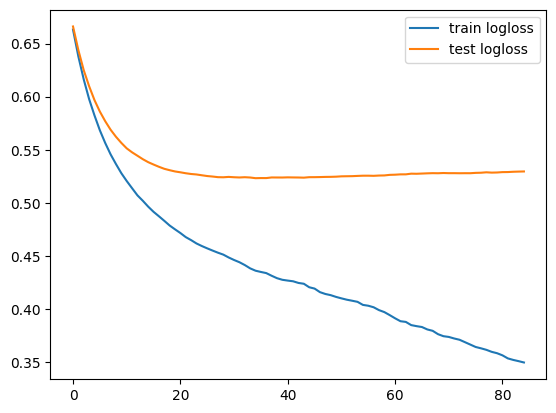

In [34]:

# plot logloss over time for train and test sets:
plt.plot(evals_result['train']['logloss'], label='train logloss')
plt.plot(evals_result['test']['logloss'], label='test logloss')


plt.legend()
plt.show()



In [35]:

best_iteration = model.best_iteration
print(best_iteration)





34


In [36]:
#Prep the submission format:
validation_df["pred"]= model.predict(xgb.DMatrix(test_df), ntree_limit=best_iteration)
validation_df["id"] = validation_df.index

#save to file:
validation_df[["id", "pred"]].to_csv("results/submission.csv", index=False)

/Users/m98612/venv/fradrag2021/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/9_/syprsqwd263_tvl61_yf9pwm0000gn/T/ipykernel_63042/1632241534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["pred"]= model.predict(xgb.DMatrix(test_df), ntree_limit=best_iteration)
/var/folders/9_/syprsqwd263_tvl61_yf9pwm0000gn/T/ipykernel_63042/1632241534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

# Test of Hyperopt

In [9]:

search_space = {
    "objective": "binary:logistic",  # objective
    "eta": hp.loguniform("learning_rate", -4, -1.2),  # learning rate
    "min_child_weight": hp.loguniform(
        "min_child_weight", -1, 3
    ),  # minimum sum of weights of all observations required in child.
    "max_depth": scope.int(hp.quniform("max_depth", 4, 50, 1)),
    "subsample": hp.loguniform(
        "subsample", -0.91, 0
    ),  # fraction of observations to be randomly samples for each tree.
    "colsample_bytree": hp.loguniform(
        "colsample_bytree", -0.91, 0
    ),  # fraction of columns to be randomly sampled for each tree.
    "colsample_bylevel": hp.loguniform(
        "colsample_bylevel", -0.91, 0
    ),  # subsample ratio of columns for each split, in each level.
    "lambda": hp.loguniform(
        "lambda", -4, 0
    ),  # L2 regularization term on weights (Ridge)
    "alpha": hp.loguniform(
        "alpha", -4, -1.2
    ),  # L1 regularization term on weight (Lasso)
    "gamma": hp.loguniform(
        "gamma", -6, 2.7
    ),  # minimum loss reduction required to make a split
    "seed": 41,
}


def objective(search_space):
    """
    Encapsulated objective-function such that hyperopt function can reach input-data in objective function
    """
    dtrain = xgb.DMatrix(X_train.copy(), label=y_train)
    dtest = xgb.DMatrix(X_test.copy(), label=y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    verbose_eval = 50
    with mlflow.start_run(nested=True):
        search_space["eval_metric"] = ["error", "auc", "logloss"]
        num_round = 1000
        evals_result = {}
        num_features = 80
        bst = xgb.train(
            search_space,
            dtrain,
            num_round,
            evals=watchlist,
            evals_result=evals_result,
            early_stopping_rounds=50,
            verbose_eval=verbose_eval,
        )
        print(f"Stopping after {len(evals_result['train']['error'])} rounds")


        min_logloss_error= np.min(evals_result["test"]["logloss"])
        mlflow.xgboost.log_model(bst, artifact_path="model")

        return {
            "status": STATUS_OK,
            "loss": min_logloss_error,
            "booster": bst.attributes(),
        }



In [10]:
#
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.xgboost.autolog(
    log_input_examples=False, log_model_signatures=True, log_models=True
)


2022/11/02 19:00:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


In [11]:

mlflow.set_experiment("hyperopt_test")

mlflow.xgboost.autolog(
    log_input_examples=False, log_model_signatures=True, log_models=True
)


with mlflow.start_run(run_name="test"):
    best_params = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=100,
    )


2022/11/02 19:00:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


[0]	train-error:0.25406	train-auc:0.83676	train-logloss:0.68098	test-error:0.31150	test-auc:0.77191	test-logloss:0.68344
[50]	train-error:0.12937	train-auc:0.94226	train-logloss:0.41751	test-error:0.27525	test-auc:0.80965	test-logloss:0.53259
[100]	train-error:0.07212	train-auc:0.97492	train-logloss:0.32366	test-error:0.27450	test-auc:0.80901	test-logloss:0.52358
[147]	train-error:0.04000	train-auc:0.98918	train-logloss:0.26719	test-error:0.27550	test-auc:0.80644	test-logloss:0.52676
Stopping after 148 rounds                              
[0]	train-error:0.15962	train-auc:0.89684	train-logloss:0.65773	test-error:0.35600	test-auc:0.71304	test-logloss:0.67699
[50]	train-error:0.02075	train-auc:0.99611	train-logloss:0.23919	test-error:0.27650	test-auc:0.80136	test-logloss:0.53285
[100]	train-error:0.01150	train-auc:0.99848	train-logloss:0.20808	test-error:0.27800	test-auc:0.80195	test-logloss:0.53472
[108]	train-error:0.01100	train-auc:0.99855	train-logloss:0.20760	test-error:0.27725	test

# Make predictions:

In [13]:

#current best model:
logged_model = 'runs:/4fda73d675894b74894c468959a88e27/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [31]:
pickle.load("")

AttributeError: 'PyFuncModel' object has no attribute 'feature_names'

In [24]:
#traintest_df.drop("label")
traintest_df = traintest_df.drop('label',axis=1)

In [25]:
#Make

validation_df2=validation_df

#Prep the submission format:
validation_df2["pred"]= loaded_model.predict(traintest_df)
validation_df2["id"] = validation_df.index

#save to file:
validation_df2[["id", "pred"]].to_csv("results/submission.csv", index=False)



ValueError: feature_names mismatch: ['0.7131772137', '0.6935182933', '0.7260013220', '0.7152632882', '0.7005385368', '0.6854126675', '0.7439608123', '0.6945358038', '0.7261839834', '0.6599155304', '0.7068648708', '0.7334981305', '0.6785443179', '0.7103145610', '0.6817853608', '0.6900419311', '0.7030380629', '0.6843290832', '0.6908702815', '0.7255734957', '0.7455022075', '0.7140588635', '0.7184685433', '0.6709092823', '0.6918028165', '0.6843798727', '0.7269629808', '0.6748761873', '0.7074451212', '0.6647139474', '0.6574445701', '0.7108522901', '0.7235257163', '0.7520219713', '0.6944939698', '0.6897816150', '0.7168539292', '0.6671447585', '0.7103557746', '0.7111210453', '0.7068665659', '0.6755044541', '0.7285923992', '0.6838581454', '0.7351862924', '0.6851879460', '0.6866204031', '0.7105571427', '0.6957237605', '0.6832302213', '0.6868895330', '0.7038779842', '0.7430245720', '0.7273883834', '0.7114015403', '0.6622675353', '0.7376106238', '0.6630076610', '0.7145754851', '0.7092139623', '0.7124093898', '0.7102063924', '0.6813468284', '0.6891989059', '0.6493925862', '0.7054698355', '0.7249243273', '0.7073699887', '0.7124232988', '0.6960383321', '0.7397620592', '0.6883644145', '0.6816833941', '0.7182247409', '0.6871205521', '0.6837705394', '0.7130622165', '0.7329296601', '0.7091147849', '0.6736738215', '0.7229880542', '0.7161310352', '0.6849091926', '0.7257861713', '0.6904070896', '0.7178086599', '0.6769324667', '0.6649042783', '0.7260762443', '0.7485725185', '0.7453728894', '0.6819038186', '0.7144147591', '0.6838472084', '0.7130892526', '0.6857017463', '0.7127521153', '0.6605334303', '0.7486569934', '0.7121727600', '0.6694772427', '0.7445032222', '0.7110906319', '0.6711011394', '0.7091261956', '0.6923459978', '0.6796069073', '0.7098416530', '0.7138319320', '0.6866604167', '0.6697786974', '0.7147816553', '0.7101727925', '0.7016429040', '0.6819102434', '0.6868940121', '0.7108042806', '0.6981301562', '0.7138214189', '0.6745480940', '0.7144967163', '0.7158956417', '0.6948936534', '0.7356252300', '0.6885464000', '0.6995245297', '0.7265362650', '0.6748211568', '0.7416833149', '0.6916866279', '0.6863656982', '0.7294547528', '0.7078411656', '0.7106449946', '0.7151588996', '0.7233782948', '0.6938481837', '0.7093709282', '0.6865464623', '0.6877948551', '0.7415798644', '0.7198255760', '0.6859570980', '0.7227539021', '0.7165074990', '0.6941218921', '0.7131455450', '0.6872287338', '0.7164399747', '0.7034788401', '0.7169901132', '0.7106515552', '0.6784778450', '0.6872512346', '0.6816092339', '0.6882063701', '0.6895893657', '0.7136107191', '0.7141230221', '0.6487472169', '0.7108721334', '0.7238909779', '0.7102938569', '0.7339690996', '0.6804275904', '0.6850631248', '0.6503186151', '0.7266151216', '0.7108945283', '0.7069356577', '0.6870652606', '0.6968657639', '0.7303053913', '0.6934145771', '0.7083852553', '0.7443903081', '0.6872456288', '0.6941595122', '0.7271717398', '0.7229408792', '0.7254589001', '0.7006222525', '0.7118911293', '0.6867085708', '0.7010793370', '0.7005723163', '0.6917084219', '0.7128381276', '0.7211217789', '0.7114408707', '0.6796088924', '0.6579720043', '0.7105499993', '0.7410778621', '0.7136015557', '0.6603097589', '0.7127225379', '0.6837186833', '0.6840646442', '0.7112653192', '0.6883381158', '0.7105179689', '0.6852596435', '0.6407502338', '0.7242708719', '0.7265972290', '0.7048619068', '0.7132640749', '0.7315848071', '0.6823021722', '0.6499879028', '0.6661740559', '0.7008580471', '0.7083905635', '0.7043615508', '0.7177659322', '0.7126023894', '0.6888494326', '0.6905274627', '0.7145921593', '0.7158659499', '0.7090219509', '0.6817707251', '0.6636276686', '0.7089122336', '0.6891304380', '0.7343180934', '0.7128456211', '0.6917864949', '0.6631366432', '0.7151355577', '0.7118979488', '0.7114450020', '0.7094452930', '0.6821191115', '0.7227534712', '0.7477086456', '0.7122781596', '0.7047195301', '0.6956020374', '0.7073687266', '0.7006073498', '0.6847084110', '0.7084356544', '0.7186664506', '0.6222863195', '0.6851457895', '0.7050943469', '0.6682631400', '0.6746911993', '0.6902670942', '0.7113457887', '0.6621743824', '0.7158037084', '0.7145836602', '0.7275585969', '0.6838202063', '0.7071616528', '0.6288297558', '0.7131199680', '0.6631398698', '0.6460217501', '0.6893643257', '0.7296478003', '0.6981214797', '0.7097698441', '0.6616777916', '0.7213925380', '0.6950312190', '0.7512639042', '0.6860121347', '0.6994637133', '0.7153171412', '0.7498790432', '0.6816094417', '0.7141945643', '0.6908464526', '0.7095693806', '0.6901654156', '0.6864490501', '0.7206481976', '0.7257405351', '0.7353902894', '0.7102541224', '0.6981344413', '0.7519100517', '0.7130972821', '0.7253925869', '0.6884758737', '0.6883357654', '0.6751544526', '0.7267925189', '0.7169539804', '0.7019166720', '0.7024323791', '0.7173673438', '0.6872614611', '0.7047926399', '0.7218817242', '0.7328643493', '0.7250160028', '0.7156490945', '0.6926922554', '0.7129772340', '0.7090878321', '0.7129591739', '0.7152343533', '0.7424580020', '0.6714815225', '0.6781438029', '0.7160424437', '0.6933472206', '0.6861600947', '0.7112356194', '0.7209794577', '0.7187191366', '0.7211102262', '0.6989751344', '0.7217880785', '0.6560480516', '0.6652061496', '0.6821111307', '0.7085411582', '0.6837399639', '0.7150464584', '0.7066294107', '0.6808626474', '0.6875555877', '0.6963599883', '0.7149421811', '0.6731613236', '0.6288608516', '0.7407076677', '0.7107165949', '0.7093233249', '0.6907530914', '0.6708990553', '0.7180262540', '0.7296765567', '0.6963716461', '0.7130857309', '0.7174789519', '0.7101282572', '0.7203222496', '0.6802939843', '0.7135857058', '0.7253856488', '0.6524028654', '0.7098499148', '0.7286005675', '0.7129218620', '0.6774695419', '0.6780155133', '0.6634226966', '0.7441046679', '0.7152997398', '0.7178102117', '0.7038139555', '0.6836056871', '0.6944845977', '0.7014975453', '0.6536305235', '0.7160806989', '0.6909426833', '0.6541278746', '0.6914197327', '0.7282541079', '0.6649650861', '0.6804144828', '0.6818183374', '0.7228860944', '0.6844124810', '0.6338206806', '0.6684089884', '0.7172517013', '0.7085237291', '0.6927361427', '0.6895748059', '0.7411832387', '0.7132860874', '0.6272932068', '0.6919492083', '0.6771264036', '0.7060466091', '0.6953079230', '0.7032220030', '0.6944819007', '0.7234329350', '0.7325234980', '0.6977906041', '0.6759549583', '0.6813408407', '0.6835201423', '0.7148201047', '0.6671740682', '0.6671113917', '0.6730152708', '0.6998492964', '0.7158559437', '0.7223621108', '0.7115895384', '0.7134714725', '0.6861159935', '0.6830162084', '0.6975581484', '0.6777683663', '0.7085644895', '0.6635501461', '0.7099757198', '0.6918086712', '0.6858298632', '0.6852813936', '0.6962369747', '0.7184558560', '0.6601920939', '0.7158649663', '0.7168607099', '0.6561617666', '0.7107219972', '0.6995046057', '0.7126246734', '0.7471411447', '0.6884157932', '0.6872453457', '0.7066923157', '0.7084894348', '0.7106452626', '0.7386466177', '0.7420853502', '0.7111506690', '0.6877856988', '0.6690004034', '0.7269428373', '0.6641575102', '0.7121121203', '0.6942817011', '0.7175106951', '0.6825091812', '0.7514899171', '0.6786041196', '0.7307699750', '0.7358402957', '0.7138471993', '0.6882641934', '0.6454375051', '0.6815103832', '0.6908166098', '0.7001593306', '0.7216439107', '0.6687918653', '0.7069486042', '0.6929024731', '0.6943267780', '0.7359777095', '0.7114365003', '0.6886323669', '0.7468656614', '0.7196834034', '0.6923870579', '0.7121179915', '0.7159777842', '0.7153321116', '0.7417723131', '0.7140057666', '0.7422701795', '0.7102683915', '0.6748850695', '0.7017610779', '0.6825761979', '0.6814627175', '0.7113445106', '0.7095733279', '0.7093757465', '0.6812071580', '0.6895428304', '0.6999201272', '0.7191430127', '0.6610090450', '0.6702424237', '0.6826742401', '0.7199407195', '0.6808199341', '0.7147116887', '0.6840411589', '0.7077553989', '0.7184479034', '0.6857664561', '0.6888900330', '0.6822568758', '0.6760531841', '0.7093654839', '0.6853874844', '0.7099239689', '0.6786580266', '0.6894422299', '0.7233375847', '0.7068431477', '0.7270554682', '0.6873722880', '0.7107820505', '0.6952418498', '0.7458999895', '0.7259883833', '0.7469599875', '0.7206649569', '0.7035691910', '0.7083706040', '0.7294753281', '0.7039949453', '0.7085812952', '0.7027501600', '0.6512650219', '0.7104294875', '0.7078908954', '0.7323855162', '0.7140991466', '0.6745199996', '0.6603327030', '0.6983766175', '0.7093036798', '0.7071493360', '0.6783547326', '0.7260346660', '0.7068972474', '0.6855649936', '0.6864711463', '0.7031828880', '0.7136797268', '0.7137176696', '0.7461282179', '0.7098751825', '0.7113817020', '0.7197744779', '0.7129710698', '0.6640823803', '0.7035478918', '0.6900612981', '0.6981892492', '0.7148509912', '0.6897190987', '0.6645763819', '0.7187882968', '0.7280813257', '0.6891843785', '0.6895802548', '0.7042751666', '0.7105522257', '0.7160746962', '0.7368875036', '0.6567642305', '0.7039309706', '0.6979541400', '0.7187270479', '0.6824310440', '0.6522976597', '0.6818512102', '0.7152034258', '0.6861802948', '0.6661416607', '0.7086744526', '0.7301891713', '0.7267755289', '0.7085379672', '0.7109905163', '0.6970180588', '0.7142027116', '0.7167410246', '0.7216552406', '0.6362728614', '0.7213169536', '0.6993472842', '0.6893024241', '0.6731257899', '0.7124322970', '0.6937289928', '0.6920853785', '0.7093143065', '0.7145930700', '0.7362219573', '0.7169277099', '0.7128298877', '0.6768337040', '0.7182760914', '0.7166918409', '0.7181097329', '0.7263558751', '0.7036667136', '0.7122339984', '0.6802013631', '0.7087145574', '0.7438848547', '0.6616002479', '0.6776371890', '0.6914523676', '0.7379185775', '0.6613117872', '0.7105677985', '0.7106246541', '0.7166424962', '0.6896345754', '0.7090201769', '0.6371788217', '0.7074310759', '0.7448243099', '0.7111756624', '0.7069783746', '0.6625459677', '0.6755832244', '0.6996196858', '0.7119194656', '0.6571278956', '0.7093809925', '0.6828592913', '0.7181615834', '0.6854170409', '0.7214870889', '0.7191156870', '0.6809545521', '0.7116542138', '0.7245817647', '0.7228808828', '0.7034959257', '0.7125092315', '0.6907956012', '0.7166543057', '0.6864773631', '0.7426180330', '0.7165611212', '0.7122683769', '0.7281436565', '0.7124871240', '0.7179876111', '0.6661139826', '0.7116198158', '0.7155175700', '0.6896963186', '0.6708702377', '0.6653647297', '0.7158489954', '0.7163930239', '0.7027347032', '0.6978087600', '0.6795805487', '0.6905823974', '0.7171324472', '0.7079314921', '0.7124850729', '0.7152095492', '0.7111159562', '0.6908170562', '0.7225135873', '0.6581279630', '0.6872139050', '0.7083170570', '0.7062298797', '0.6911950839', '0.7035624942', '0.7055825860', '0.6843062603', '0.7075615512', '0.6819279602', '0.6931174765', '0.7101597889', '0.7551167673', '0.6495194746', '0.7115183564', '0.7504312706', '0.7207645644', '0.7136449379', '0.6935427367', '0.6612068810', '0.6937384788', '0.7156669797', '0.7164235871', '0.7214193940', '0.6967433744', '0.6312756578', '0.7008784125', '0.6877640704', '0.7427666472', '0.6831608458', '0.7197151671', '0.7067558718', '0.6887926006', '0.7045171809', '0.6857584159', '0.6830480581', '0.6896882783', '0.7134155269', '0.6943424140', '0.6836660019', '0.6518079470', '0.7015512225', '0.6882463725', '0.7065172231', '0.6938371225', '0.7103406862', '0.6864523451', '0.6671282731', '0.7166392253', '0.7223683590', '0.7217724942', '0.7172483703', '0.6940429875', '0.6798280314', '0.7487807778', '0.6899972544', '0.6695442854', '0.7277006179', '0.7047309168', '0.7087594069', '0.7125567786', '0.7115848889', '0.6903211493', '0.6884279125', '0.7136242881', '0.6856335353', '0.7119161026', '0.6818171939', '0.6932630016', '0.7094350406', '0.7221177782', '0.6864290417', '0.7120264622', '0.7014251736', '0.7194256838', '0.6931441850', '0.7396562740', '0.7012276775', '0.6914303855', '0.6659237325', '0.6597075436', '0.7122089802', '0.6954778710', '0.6863927033', '0.7167205762', '0.7115864152', '0.7034270611', '0.6873355145', '0.6851366237', '0.7326238621', '0.7100281237', '0.6914669660', '0.6945331671', '0.6778902319', '0.7150376269', '0.6951327198', '0.7161062356', '0.7142761095', '0.7148758897', '0.7133277570', '0.7070074151', '0.6977000934', '0.7225567087', '0.6926995460', '0.6901535339', '0.6825756120', '0.7137502657', '0.7143957203', '0.7317611175', '0.7174802725', '0.7158239413', '0.6991497122', '0.6974630131', '0.7155166153', '0.7180640466', '0.6848380613', '0.7117002574', '0.6885787668', '0.6778541680', '0.6642701384', '0.6983922673', '0.7222188011', '0.7126470595', '0.7084958961', '0.7108863257', '0.7207565101', '0.6874075512', '0.6688399450', '0.7083060372', '0.7145126862', '0.7145536138', '0.6620129196', '0.7129289539', '0.6697347880', '0.7096987135', '0.6907238078', '0.6842232039', '0.7115386062', '0.7220698191', '0.7208785623', '0.6990606233', '0.6959080219', '0.6286579774', '0.6991071863', '0.7187605176', '0.7005671151', '0.7113636196', '0.7093020316', '0.7096949300', '0.7157242817', '0.7330095808', '0.7230763763', '0.7078040819', '0.6615079171', '0.6902818603', '0.7108880480', '0.7127166981', '0.7118113940', '0.6818307802', '0.7330523232', '0.7168899938', '0.7017807354', '0.6426110725', '0.7209650860', '0.7132662288', '0.7182553783', '0.7185558665', '0.6948254216', '0.6985742406', '0.7432487332', '0.7000466075', '0.6896828743', '0.7164878634', '0.7167775503', '0.7415517860', '0.6933528244', '0.6857679045', '0.7182027550', '0.6836345709', '0.6432872696', '0.7459658240', '0.7010031942', '0.6612449209', '0.6944438295', '0.7329676317', '0.7101653709', '0.6782556073', '0.6889375866', '0.7057728102', '0.7144631667', '0.6335286032', '0.7113287435', '0.7085223592', '0.6910786227', '0.7134780785', '0.6954259851', '0.7100182383', '0.6807443166', '0.7206422201', '0.6812536997', '0.6908704085', '0.6970629222', '0.7104753921', '0.7131820737', '0.6838089987', '0.7091329861', '0.7426076896', '0.7110386284', '0.7454174479', '0.7175581005', '0.7127418851', '0.6847586253', '0.6870302612', '0.6888896753', '0.6913740693', '0.6987649289', '0.6955613851', '0.7217415449', '0.7378186434', '0.6917509910', '0.6925958751', '0.7377100229', '0.7009339180', '0.7115944452', '0.6991516548', '0.6768152117', '0.6984324271', '0.7101163724', '0.7119763735', '0.7184043953', '0.6607284123', '0.6837655765', '0.7032973916', '0.6913897049', '0.6828804490', '0.7163693161', '0.6781816029', '0.7061932827', '0.6836142394', '0.7214597456', '0.7511597521', '0.7150444678', '0.7490599922', '0.7158005597', '0.7108711409', '0.6669902812', '0.7129056097', '0.6603367968', '0.6483090984', '0.7060985220', '0.6688391811', '0.7172332543', '0.6788186767', '0.7233030550', '0.7121214370', '0.7070651996', '0.7107408029', '0.6853337992', '0.6884418344', '0.6980237061', '0.7144250291', '0.6858092982', '0.6617265774', '0.7000090648', '0.6872928244', '0.7059372970', '0.7178841326', '0.6550220054', '0.6940325620', '0.7388614187', '0.7413896919', '0.6818019927', '0.7143077619', '0.7002514850', '0.7046495813', '0.6225426578', '0.7166824452', '0.7001360164', '0.7102579754', '0.7108777956', '0.7202215840', '0.7096140362', '0.7174744579', '0.7197959929', '0.7292951058', '0.6657348857', '0.6832521680', '0.7113290375', '0.7095006854', '0.7094238381', '0.7230467408', '0.6775430865', '0.6700050063', '0.6876214115', '0.7032523228', '0.6979543953', '0.6747164485', '0.7184399217', '0.7246217277', '0.7170231816', '0.7169176338', '0.6704248439', '0.6885896550', '0.6702783631', '0.6932545022', '0.7093466983', '0.6969770791', '0.6686589798', '0.6869712218', '0.7321324694', '0.6783238631', '0.7081516250', '0.6846254517', '0.6827832570', '0.6880661860', '0.7110155072', '0.7068611446', '0.7360757068', '0.7146431729', '0.6940909040', '0.6959412834', '0.6872126167', '0.7420325888', '0.7146936381', '0.6825430801', '0.6255093621', '0.6876065581', '0.7405822958', '0.7051587416', '0.6870591579', '0.7133390049', '0.7402911306', '0.6630549410', '0.6973401911', '0.6647847510', '0.6865774062', '0.6726285873', '0.7311353604', '0.6997714527', '0.6389095301', '0.6887896671', '0.6713564579', '0.7130813983', '0.7097549065', '0.6691132508', '0.6859766554', '0.7144335192', '0.6824302916', '0.7101023896', '0.7334076445', '0.7099365536', '0.6973346829', '0.6827854178', '0.7079615767', '0.7125936194', '0.7484812183', '0.6618775277', '0.6632187334', '0.6824543456', '0.7066620525', '0.7259514327', '0.6874021380', '0.6922578442', '0.7087508280', '0.6896297577', '0.6975911430', '0.7076624471', '0.6829823066', '0.7143563706', '0.7195991486', '0.7025688184', '0.7139811533', '0.6742130232', '0.6639347225', '0.7121681015', '0.6800775581', '0.6876209554', '0.6869857003', '0.7050986679', '0.7134072602', '0.6787370553', '0.6932874266', '0.7020757310', '0.6900693308', '0.7262134430', '0.6783301885', '0.6641563772', '0.7149022045', '0.7158935406', '0.7032904381', '0.7172757728', '0.6910223917', '0.6843547298', '0.7107374965', '0.6857443175', '0.6735552125', '0.7161296287', '0.6855676055', '0.6864422228', '0.7108640042', '0.6887260443', '0.6905352343', '0.6836551096', '0.6947157450', '0.7362265087', '0.6822339944', '0.6887113415', '0.6294457895', '0.7220425441', '0.6798503735', '0.6735847162', '0.6809114377', '0.7198894700', '0.6885264048', '0.7113874033', '0.6849858959', '0.7154737278', '0.6797190507', '0.7197677175', '0.7172009382', '0.6419100341', '0.6870192655', '0.6982663646', '0.6846569023', '0.6967741195', '0.7129603437', '0.7160166227', '0.7107115305', '0.7163635612', '0.6975624508', '0.6953991283', '0.7159037790', '0.6861778972', '0.7304377101', '0.6877847699', '0.6899447376', '0.7123075789', '0.7119544537', '0.6869424129', '0.6653455761', '0.7137167206', '0.7108748386', '0.6586052709', '0.6762171812', '0.7197916178', '0.7090491053', '0.6880647246', '0.7175132403', '0.7238173888', '0.7575039918', '0.7101817035', '0.6862100697', '0.7019409908', '0.6814806215', '0.6695382342', '0.6704697332', '0.7234456280', '0.7124068964', '0.6949847235', '0.6953002256', '0.7048894988', '0.7138987889', '0.7208705587', '0.6761696564', '0.6800703370', '0.7104796277', '0.6739061157', '0.7433337594', '0.7179511105', '0.7180287695', '0.6889320910', '0.6957159570', '0.6981286421', '0.7162358736', '0.7141607332', '0.7251299335', '0.7147054654', '0.6762200504', '0.6958682033', '0.6572293651', '0.6587775987', '0.6897888813', '0.7239315320', '0.7108148320', '0.6936584997', '0.6797614844', '0.7146689209', '0.7237422247', '0.6918662623', '0.7475522031', '0.7122087385', '0.7198448750', '0.7108144532', '0.7176389557', '0.7210420244', '0.7146329248', '0.6590005376', '0.7124377340', '0.7131851085', '0.7498426113', '0.6831689622', '0.6836571019', '0.7125216508', '0.7187073657', '0.7454347785', '0.7136851817', '0.6855431760', '0.7310302039', '0.6902398956', '0.7301644280', '0.7307326568', '0.7413369449', '0.7050191432', '0.6253455681', '0.6815924766', '0.6813287585', '0.6913229374', '0.6756501580', '0.7146627131', '0.7098280651', '0.7129763062', '0.6873164054', '0.6838614356', '0.6823993660', '0.7156121398', '0.6646072770', '0.6823520037', '0.7090289725', '0.7240542611', '0.7414106046', '0.6941317790', '0.6835796381', '0.7159506369', '0.7404544398', '0.6856318374', '0.6872533788', '0.7049987001', '0.7062158910', '0.7401528107', '0.7018211628', '0.6816303265', '0.7001966305', '0.7107253288', '0.6671604366', '0.7175529377', '0.6553016966', '0.6541963996', '0.7219862532', '0.7119080190', '0.7144492349', '0.6620201058', '0.7190601119', '0.7491727386', '0.7076017829', '0.7288610946', '0.6925285322', '0.7001923856', '0.7167695796', '0.7142555215', '0.6959685071', '0.7266211077', '0.6956546161', '0.7044313099', '0.7174832752', '0.6585612585', '0.7037836498', '0.6968988914', '0.7004133415', '0.7115767134', '0.7139347207', '0.7113211865', '0.7080161305', '0.6971075606', '0.6886143780', '0.6685498360', '0.7161336137', '0.6874928184', '0.6666609229', '0.6978059870', '0.6818851821', '0.7051369296', '0.7428946639', '0.6972704787', '0.7256420271', '0.6616045747', '0.7143419379', '0.6911457990', '0.7415438207', '0.7136514594', '0.6712828260', '0.6875959497', '0.7145760567', '0.7151945507', '0.7122952028', '0.7071345118', '0.7091048728', '0.6813716540', '0.7134651190', '0.6878172090', '0.6908560722', '0.7132728939', '0.7125676520', '0.6647886128', '0.6902439618', '0.6823025650', '0.6901810435', '0.6762489295', '0.7144177627', '0.6670280691', '0.7091430869', '0.7116458461', '0.6925395432', '0.7111856710', '0.7074667545', '0.6670390119', '0.6548212962', '0.6632070686', '0.7150134468', '0.6972162315', '0.6881877954', '0.6922363471', '0.7104307107', '0.7418751785', '0.6846626304', '0.7018139386', '0.7369818151', '0.6952756302', '0.7104153263', '0.7318553668', '0.7375049222', '0.6933819299', '0.7239911650', '0.7176192037', '0.6937411963', '0.6552971765', '0.7337098900', '0.7225676221', '0.6892413036', '0.6781392004', '0.7380943731', '0.6669187541', '0.7095752590', '0.6888930899', '0.6869034431', '0.7095631180', '0.6915428053', '0.6944696950', '0.6834945922', '0.6906038825', '0.6893009749', '0.6900226939', '0.6875849257', '0.7103651059', '0.7013259828', '0.7011303387', '0.7117968362', '0.7001919159', '0.7103335700', '0.7130487476', '0.6743990562', '0.7178141890', '0.7488676393', '0.6603869261', '0.7057794666', '0.7021646634', '0.6861832975', '0.6329211291', '0.6741761738', '0.6834859462', '0.7114893331', '0.6796561644', '0.7110164356', '0.7282374400', '0.7110187973', '0.7199686122', '0.7186731377', '0.6948686841', '0.6973096036', '0.7068850688', '0.7112863370', '0.6844917226', '0.7226510504', '0.7094422292', '0.6865101978', '0.7307360348', '0.6675692723', '0.6263493693', '0.7012785447', '0.6967430764', '0.6903096910', '0.6786100196', '0.7132526199', '0.7518289639', '0.6843794988', '0.6948890623', '0.6866087526', '0.7055903550', '0.6741945056', '0.6799363670', '0.7119708735', '0.6849737063', '0.6930295243', '0.7033940673', '0.7152441900', '0.6969386484', '0.7329998314', '0.6861746151', '0.7364456298', '0.7104434437', '0.7105139967', '0.7095092841', '0.6874477182', '0.7122775850', '0.6661690732', '0.6877872645', '0.6899300215', '0.6757695407', '0.7427339125', '0.7487090009', '0.7035116846', '0.6840400355', '0.6690650850', '0.7088173794', '0.6673854151', '0.7182179850', '0.7187793824', '0.7149448959', '0.7144598038', '0.7012040582', '0.7161979144', '0.7048651259', '0.6603536662', '0.7122237665', '0.6905937352', '0.7019873444', '0.6923223976', '0.7137954942', '0.6773385771', '0.6906995248', '0.7007729240', '0.7188866628', '0.6838802229', '0.7209841646', '0.6581980033', '0.7330406202', '0.7071036952', '0.6829087334', '0.6823791024', '0.7316760364', '0.6596476913', '0.6612134514', '0.7078476334', '0.7372444190', '0.7286423020', '0.7118885452', '0.7080964539', '0.6771933332', '0.7141037231', '0.6660616694', '0.7056842707', '0.7131318769', '0.7160695151', '0.6983372156', '0.7180179581', '0.7114005504', '0.7229662976', '0.7448827030', '0.6822641879', '0.6879691654', '0.7105356841', '0.7160307405', '0.6914288341', '0.7265786019', '0.7162067530', '0.7267437211', '0.7135289746', '0.7163937122', '0.6849790961', '0.7166024698', '0.7164548327', '0.7152164209', '0.6940272455', '0.7024334675', '0.6873545357', '0.6936502216', '0.7126018652', '0.7099915937', '0.7114620252', '0.7135795615', '0.7062055665', '0.6936633701', '0.6968299471', '0.7225222519', '0.7469688793', '0.7130388245', '0.7310746549', '0.6876273248', '0.7254434044', '0.7159295660', '0.7091903793', '0.6675187404', '0.6973221976', '0.6765367238', '0.6777754614', '0.7393217514', '0.6808858049', '0.7121042458', '0.6850733039', '0.6892078313', '0.6989964234', '0.6975231974', '0.7425461369', '0.7112677133', '0.7328687115', '0.7015087330', '0.6886258682', '0.7141089656', '0.6804619083', '0.7097134222', '0.6460118158', '0.7032181627', '0.6975177755', '0.6875774445', '0.6827817740', '0.7210958857', '0.6924538210', '0.7111762734', '0.6815915287', '0.7131604216', '0.6724954599', '0.7348209301', '0.6910573918', '0.7011431741', '0.6865951111', '0.6819476929', '0.7266938721', '0.6917893540', '0.6995222497', '0.7099764309', '0.6867095140', '0.7281939052', '0.7140899847', '0.7500916184', '0.6990354888', '0.7447848676', '0.7149439756', '0.6874352004', '0.6624073681', '0.6707114187', '0.7160731778', '0.6568310284', '0.7191462007', '0.7197966566', '0.7076475540', '0.7128465243', '0.7136870317', '0.7082560418', '0.7113753838', '0.7050587599', '0.7213061650', '0.6865722069', '0.6836173851', '0.6854140551', '0.7282105136', '0.6859641417', '0.6837370950', '0.7058701199', '0.6632187025', '0.7005139511', '0.6835302567', '0.6912977554', '0.7212939187', '0.7119293697', '0.7108018149', '0.7103645373', '0.6877437140', '0.7054491803', '0.7057947344', '0.7431720789', '0.7359858591', '0.6969724370', '0.7311564069', '0.6850568278', '0.7234052329', '0.6857283741', '0.7058637401', '0.7061842419', '0.7123284627', '0.7014296347', '0.7121051817', '0.6918024717', '0.7177246447', '0.6868033302', '0.7438388689', '0.6950859722', '0.7345689522', '0.6884414527', '0.7482856984', '0.7121288658', '0.7420515787', '0.6611595537', '0.7151494529', '0.6952644261', '0.6887663509', '0.7149848281', '0.6757381902', '0.6867089966', '0.7444903669', '0.7211938052', '0.6980334280', '0.6898688962', '0.6965674121', '0.6564517315', '0.7493313350', '0.6823369387', '0.7005944379', '0.7087382026', '0.7049642046', '0.6754997206', '0.6670786014', '0.7479429606', '0.7190716415', '0.7104104660', '0.6964985401', '0.6743157708', '0.6824157935', '0.6807546092', '0.6813726655', '0.6787260692', '0.6685356641', '0.6876524983', '0.6876971489', '0.7177287031', '0.7087942605', '0.7170583901', '0.7112661790', '0.6617847612', '0.7096261629', '0.6893955071', '0.6829261541', '0.7056861296', '0.7487592987', '0.6819418764', '0.7087870884', '0.7081404816', '0.7113879638', '0.6982757829', '0.7099815666', '0.7133057508', '0.7142806061', '0.7215145898', '0.7352952643', '0.7088756361', '0.6673632585', '0.6902601880', '0.7152193734', '0.6638768547', '0.6620495604', '0.7362435667', '0.6913381317', '0.6917560137', '0.7220723210', '0.6990671590', '0.6856035366', '0.7099835415', '0.7363559480', '0.6859204786', '0.7223831775', '0.6825178553', '0.6838241098', '0.7138741486', '0.6874564472', '0.6884064627', '0.6897200221', '0.7106721405', '0.7303523509', '0.6878849294', '0.7294672588', '0.7143127301', '0.6876052214', '0.7075731575', '0.6606957552', '0.7141422191', '0.7363008410', '0.6871384659', '0.7138389035', '0.7131166033', '0.6832967173', '0.6746274172', '0.6828132465', '0.7091448696', '0.7090098019', '0.6958596065', '0.6855263423', '0.6886747437', '0.6851513668', '0.7170866519', '0.6555584921', '0.7127281135', '0.6951012499', '0.7206662956', '0.7135496832', '0.6961448546', '0.7157187570', '0.7111709544', '0.7140873132', '0.7116192598', '0.7110462712', '0.6825175275', '0.7187736281', '0.6890604983', '0.7011193505', '0.7105688847', '0.6786504138', '0.6786163354', '0.6517195011', '0.7275459532', '0.6873018919', '0.7005203743', '0.7085942478', '0.7378779555', '0.7088566150', '0.6566530931', '0.7292430670', '0.7299046663', '0.6981775510', '0.6927940112', '0.6880942970', '0.7104108112', '0.7086077712', '0.7012052190', '0.7168710948', '0.7133463704', '0.7125597611', '0.7122715619', '0.7157922758', '0.6769806895', '0.7350674977', '0.7081586586', '0.7324748908', '0.6706310661', '0.7178241433', '0.7240019068', '0.6736005999', '0.6846056727', '0.7222809303', '0.7092634288', '0.6843455175', '0.6992167289', '0.6900415358', '0.7213101992', '0.6916983733', '0.6982756673', '0.7303034095', '0.6877101772', '0.7036825804', '0.7428894147', '0.7256688233', '0.6715751257', '0.6950976688', '0.7441273234', '0.7173018673', '0.7256187401', '0.7183007083', '0.7113550597', '0.6854908585', '0.7105293075', '0.6862827816', '0.6862649240', '0.7227561968', '0.6972805479', '0.7164232162', '0.7165953715', '0.7149918064', '0.6914887853', '0.7063163016', '0.7254583028', '0.7263092804', '0.7049757700', '0.7361729002', '0.7408818255', '0.6859869346', '0.7122511613', '0.7322715598', '0.6908102781', '0.7208946015', '0.7096847149', '0.6965623497', '0.6911331290', '0.7365468288', '0.6903486262', '0.7290316727', '0.7003941213', '0.7171895746', '0.7195252290', '0.7090100902', '0.7171701502', '0.7141930135', '0.7124209994', '0.7114596946', '0.6829728360', '0.7120125931', '0.6603949762', '0.7121542874', '0.6873381788', '0.7072824458', '0.7236314999', '0.6757373773', '0.6343846561', '0.7081603130', '0.6980485639', '0.7137925558', '0.7049752042', '0.6873138941', '0.6838626342', '0.7122353096', '0.7147628166', '0.7006743748', '0.6877066312', '0.7115343006', '0.7202429174', '0.6808096398', '0.6878636676', '0.6897003815', '0.7161150036', '0.7074971728', '0.7461391990', '0.7155218902', '0.6802876449', '0.6869616595', '0.6991103101', '0.6372032593', '0.6951106214', '0.7452107025', '0.6876780054', '0.7098067003', '0.6801807904', '0.7127608478', '0.6858590692', '0.7058549416', '0.7137643207', '0.7136612407', '0.7231308456', '0.7099975636', '0.7125690919', '0.7137210899', '0.7197246701', '0.7241882643', '0.7074113274', '0.6845612726', '0.6813323726', '0.7085433972', '0.6948832323', '0.7207690552', '0.7225280232', '0.6979056101', '0.7118473835', '0.7480106186', '0.7084313246', '0.7195799909', '0.6914345720', '0.7055274083', '0.7121791672', '0.6829643714', '0.6914021587', '0.6639706363', '0.6605210820', '0.6828237639', '0.7023000862', '0.6947309321', '0.7161004117', '0.7167697866', '0.6911275798', '0.6952722873', '0.7098719584', '0.6821659620', '0.6829844462', '0.6791029917', '0.6652266445', '0.6636455890', '0.6914915074', '0.6819038450', '0.6856004592', '0.6917689476', '0.7421463529', '0.6921682462', '0.6868739459', '0.6891616675', '0.7160555282', '0.7281361188', '0.7113359698', '0.6607092002', '0.7101593865', '0.7183933428', '0.6885130238', '0.7113432262', '0.6836406757', '0.7496569929', '0.7096083349', '0.7092358764', '0.7164321278', '0.7315714039', '0.6900625384', '0.7199953710', '0.6925414198', '0.6845862804', '0.6640713789', '0.6928533281', '0.7172343327', '0.7526999358', '0.6894531862', '0.7189551441', '0.6900359709', '0.7081298120', '0.7098663006', '0.7110468602', '0.7094076591', '0.7096861940', '0.6946360284', '0.6935553446', '0.6760305304', '0.7121480264', '0.7181652936', '0.6990317587', '0.6827512275', '0.6796972300', '0.7176833730', '0.7201625261', '0.6713475366', '0.7236067075', '0.7234267878', '0.6865945188', '0.6910589864', '0.7014983348', '0.7045918697', '0.6922738647', '0.7122748137', '0.7373706380', '0.6993366821', '0.6839509752', '0.7197060236', '0.7217600698', '0.6758460510', '0.6761031278', '0.6633472767', '0.7110437272', '0.7410203216', '0.7292200076', '0.6665224750', '0.7079089775', '0.7060967827', '0.7152251231', '0.7047759534', '0.7090520821', '0.7115701824', '0.6899729847', '0.7115809691', '0.6922097348', '0.6846598508', '0.7004444027', '0.7120881745', '0.6747919674', '0.7358926956', '0.7063450175', '0.6735409394', '0.7120115028', '0.6811147061', '0.7124814901', '0.6824016159', '0.7213396887', '0.6914465283', '0.7165112655', '0.6904033882', '0.7098897373', '0.7306719747', '0.6951135037', '0.6827569002', '0.7475495771', '0.7162643802', '0.6847376574', '0.6953371936', '0.7143185996', '0.6854842649', '0.7108343938', '0.6775702774', '0.6827546208', '0.6997876446', '0.7082194190', '0.7170741747', '0.6815928288', '0.6619122995', '0.6599181044', '0.6924123007', '0.7091625174', '0.7184890522', '0.7386232069', '0.6884208542', '0.6475577136', '0.7219002234', '0.7219130292', '0.7514603342', '0.7058714342', '0.7106841538', '0.6973183159', '0.6946109117', '0.7153271021', '0.7100741287', '0.7092762948', '0.6844730084', '0.6820737411', '0.7091190231', '0.7199642416', '0.6968783431', '0.6784408180', '0.6272779211', '0.7120602530', '0.6822577193', '0.7128820582', '0.6991008482', '0.7115270026', '0.6577636471', '0.7131524554', '0.7087335850', '0.6819610031', '0.6850992808', '0.7240502686', '0.7103588208', '0.6578220885', '0.6953514853', '0.6789568887', '0.6982787577', '0.7014720366', '0.6820768869', '0.7034752157', '0.7126529454', '0.7146286193', '0.7077196850', '0.6882128599', '0.6862855922', '0.7132122127', '0.6843031826', '0.7141514631', '0.6941908406', '0.7231963018', '0.7101863924', '0.7062129233', '0.7422806692', '0.7129529004', '0.6864714596', '0.7285158694', '0.7049643770', '0.7020683134', '0.7135046189', '0.7214042438', '0.7474165213', '0.7160545325', '0.7168705831', '0.7399810379', '0.7040265705', '0.7217175934', '0.7204170974', '0.7101591444', '0.7031982172', '0.6828278513', '0.6938140750', '0.6865646890', '0.6920986243', '0.6741114138', '0.7175125309', '0.6738010430', '0.6905008269', '0.6839593916', '0.6960897496', '0.7101757524', '0.6860332286', '0.6987770251', '0.7192161898', '0.6693691025', '0.6953119400', '0.7181371289', '0.7047227552', '0.6727900298', '0.7126401694', '0.7106372286', '0.7163544423', '0.7247214634', '0.7152010405', '0.7375755443', '0.7109035109', '0.6856849010', '0.7258496681', '0.7153215834', '0.6967268394', '0.6676407374', '0.6892495268', '0.7089167790', '0.7175696549', '0.6985088043', '0.6664363848', '0.6973943112', '0.6829945584', '0.7212559997', '0.6711054733', '0.7117912230', '0.7059688653', '0.6733929636', '0.6599082809', '0.6879711126', '0.6732950962', '0.6845771904', '0.6891501603', '0.7266035482', '0.6817637254', '0.6865455061', '0.7126252120', '0.7110506680', '0.7117791291', '0.7080287300', '0.7131259323', '0.7055356794', '0.6970620517', '0.6765227008', '0.7033730365', '0.7146794402', '0.7203099744', '0.6843756984', '0.7500351355', '0.6902365850', '0.7105268836', '0.7090283917', '0.7105463709', '0.7096542052', '0.6813807709', '0.6872777489', '0.7205799322', '0.7454503854', '0.6552358052', '0.6745642029', '0.7144189298', '0.6875126412', '0.7122111032', '0.6867620029', '0.6796986069', '0.6930813022', '0.7168121855', '0.7030342242', '0.7387680116', '0.7290822123', '0.7264583143', '0.6758912136', '0.7080388231', '0.6899853675', '0.6887600900', '0.6872058180', '0.6896581271', '0.7156537235', '0.7300963386', '0.6867259912', '0.6713821618', '0.6658685239', '0.7421312834', '0.7062706302', '0.7124781251', '0.6702128703', '0.6900298424', '0.6944177462', '0.7178464202', '0.6902864150', '0.6907687742', '0.6885940834', '0.6839403095', '0.7140107829', '0.7079177912', '0.7144203866', '0.7176820565', '0.7047884993', '0.6901923763', '0.6914791030', '0.6881475073', '0.7440789321', '0.6995039209', '0.7424201716', '0.7209185644', '0.6717098248', '0.6640531222', '0.7005701560', '0.6853296130', '0.7063913968', '0.6889283377', '0.7010914098', '0.7251390788', '0.7155862310', '0.7115195616', '0.6861361132', '0.6768418288', '0.7077309933', '0.6609144896', '0.7239455850', '0.7102582220', '0.6510016540', '0.6744120938', '0.6893045181', '0.7107640713', '0.6734360482', '0.7329457274', '0.6955259264', '0.7134986015', '0.7101610057', '0.7093134706', '0.6597363850', '0.7093197907', '0.6936440141', '0.6994661312', '0.6928692621', '0.7091510216', '0.7102855330', '0.7205816949', '0.7157024815', '0.7122361792', '0.6349644082', '0.6994295716', '0.7134587972', '0.6657081871', '0.6860025807', '0.7397507656', '0.6874330493', '0.7390134972', '0.6526324621', '0.7218291335', '0.6826059626', '0.7079456040', '0.7257177033', '0.7102875989', '0.7326489372', '0.7361445013', '0.7106186550', '0.7044849094', '0.7013094944', '0.7317867908', '0.7376874288', '0.7128697519', '0.7183125190', '0.6974847272', '0.6825341422', '0.6926884928', '0.7167451444', '0.7390121562', '0.6890421983', '0.7229646807', '0.6861768054', '0.7463720898', '0.7085527451', '0.6937990952', '0.7168201691', '0.7164060102', '0.7160467179', '0.7189641979', '0.6950782101', '0.6930851617', '0.7389621841', '0.7292254381', '0.6868745354', '0.7001097872', '0.6865184977', '0.6634558843', '0.6981113190', '0.6874413617', '0.7470318789', '0.7098629911', '0.6956316194', '0.6825943424', '0.6897427366', '0.7181886990', '0.7053034386', '0.6846088538', '0.7091040013', '0.7097125263', '0.7140265437', '0.7177695997', '0.6886271348', '0.7101863265', '0.7094341219', '0.7036249448', '0.7113627207', '0.7115005615', '0.7085144665', '0.6849894465', '0.7039350561', '0.6922375148', '0.6969193975', '0.7274290134', '0.7167515010', '0.6801599340', '0.7137253810', '0.7104514047', '0.7148933440', '0.6592570649', '0.7222734305', '0.7023772138', '0.7120848977', '0.7263945528', '0.6605086779', '0.7128591265', '0.6829045065', '0.7247777562', '0.7231785179', '0.6704852398', '0.6885897003', '0.7134857923', '0.7077465536', '0.6967954691', '0.7141102271', '0.7246960712', '0.6739525796', '0.7175116266', '0.7169212705', '0.7070260856', '0.7123715278', '0.7029464009', '0.6915595071', '0.7213413140', '0.6404491258', '0.7221335018', '0.6967931752', '0.6921733122', '0.6798071644', '0.6860590682', '0.6949307077', '0.6882079070', '0.6942285312', '0.7013480133', '0.6818718747', '0.6899769911', '0.7389150979', '0.6999883439', '0.7124784276', '0.7105430583', '0.7151022251', '0.7123491670', '0.7169219692', '0.7119663812', '0.7256052574', '0.7263328665', '0.7079947670', '0.6877983109', '0.7110906626', '0.6807226664', '0.6880279672', '0.7141925072', '0.6905927805', '0.6831078408', '0.6531750809', '0.6943201111', '0.6598940198', '0.6691101956', '0.7077449591', '0.6921301603', '0.7266980518', '0.7054213733', '0.7133290822', '0.7191820280', '0.7183450855', '0.7163179344', '0.6873602704', '0.6875403738', '0.7121783884', '0.7475317517', '0.6814596763', '0.6716144382', '0.7376981638', '0.6956790107', '0.6879019656', '0.7206375943', '0.6725729469', '0.7219321899', '0.7334110167', '0.7082779527', '0.6833187266', '0.6922981430', '0.6853494192', '0.7166992392', '0.7371001150', '0.7088616839', '0.7100192721', '0.7365284069', '0.7078389380', '0.7180443438', '0.7163602220', '0.7124118748', '0.7139792453', '0.7392276371', '0.7180896713', '0.7221018522', '0.7202985836', '0.7016602434', '0.7078929135', '0.6955328339', '0.7024839343', '0.7198624094', '0.7286452227', '0.7115135847', '0.7168620522', '0.6848737762', '0.6585799099', '0.6565234650', '0.6875239760', '0.7089088583', '0.7186949982', '0.7101215497', '0.7101100022', '0.7124881449', '0.7205905934', '0.6746587305', '0.7146105625', '0.6819812837', '0.7115293751', '0.7082586403', '0.6838801447', '0.6885950830', '0.6983116055', '0.7083009944', '0.6893289917', '0.7155449904', '0.7127119714', '0.7020722114', '0.6912961131', '0.7229313574', '0.7289347545', '0.7240512737', '0.6832151327', '0.7237865492', '0.7367088694', '0.6922532878', '0.6884608172', '0.6869981037', '0.6737624943', '0.6883357632', '0.6971093479', '0.7101878240', '0.6814128124', '0.6820178981', '0.6699703682', '0.7119250140', '0.6808789224', '0.6704582135', '0.6938511476', '0.6935703744', '0.6652230836', '0.7312066651', '0.6485743466', '0.7230059767', '0.6725983338', '0.6968541668', '0.6902745592', '0.7059760105', '0.7324623956', '0.7130652803', '0.7028726008', '0.6840902737', '0.6725704841', '0.6515649417', '0.7450750015', '0.7160659364', '0.6927967347', '0.7273680764', '0.7098702834', '0.6665122792', '0.7039973412', '0.7124497491', '0.6766226310', '0.6845305065', '0.6813802694', '0.6923901538', '0.7076414149', '0.7184534028', '0.6963135049', '0.7085936287', '0.6593521643', '0.6964900171', '0.6658856476', '0.7164992684', '0.7147143756', '0.7062091203', '0.6947927639', '0.7110384818', '0.7128592166', '0.7129613702', '0.6771772810', '0.6633040840', '0.6776022217', '0.7139720978', '0.6924089618', '0.7337906963', '0.6952928743', '0.6932391709', '0.6863827842', '0.6684947732', '0.7010989821', '0.6854856551', '0.6720185900', '0.7238184315', '0.7039278418', '0.7363604494', '0.7174321637', '0.7128409178', '0.7099567698', '0.7160613710', '0.7046648643', '0.7094784235', '0.7157131582', '0.7484258757', '0.7119258934', '0.6867571763', '0.6714747313', '0.7189268094', '0.7084614500', '0.6537221941', '0.7296015715', '0.7138976017', '0.7439110039', '0.6844036500', '0.6885205744', '0.6929214596', '0.6707050242', '0.6976709563', '0.7051677732', '0.7164730402', '0.6699041432', '0.7253196911', '0.6849971963', '0.6945255760', '0.7227625960', '0.6804714222', '0.6728338831', '0.6657522306', '0.6979316964', '0.6900219493', '0.7116573612', '0.7195512209', '0.6847575413', '0.7144978161', '0.7228025399', '0.6805489053', '0.7072028359', '0.7155367688', '0.6926641668', '0.6951287008', '0.7354188853', '0.7124969891', '0.7006004135', '0.7093904048', '0.7209499257', '0.6857391830', '0.6857823071', '0.6932825907', '0.6901409123', '0.6917373440', '0.7243671629', '0.6814986889', '0.6778730537', '0.6953339772', '0.7370613359', '0.7309748369', '0.6680268769', '0.7147364741', '0.7159686391', '0.6960834333', '0.7100681245', '0.6885012492', '0.7180663946', '0.7137634669', '0.6886509932', '0.7211813197', '0.7137688948', '0.6928034448', '0.6892817968', '0.7268574599', '0.7028746478', '0.6843211995', '0.7114724941', '0.7462645302', '0.7289156238', '0.7065899455', '0.7098176918', '0.7092110378', '0.7088977804', '0.7170552571', '0.6862946575', '0.6819007254', '0.7087769124', '0.7007814711', '0.7137650884', '0.6910390218', '0.7095560632', '0.7325961492', '0.7083250258', '0.6828273662', '0.7125908571', '0.7163430031', '0.7119206280', '0.7171649029', '0.7199509107', '0.6951117716', '0.7139661677', '0.7170683347', '0.7088021743', '0.6945060367', '0.6363549073', '0.6781281307', '0.7222262421', '0.7121959578', '0.7350435740', '0.7008787695', '0.6661218948', '0.7299090575', '0.6605625534', '0.7093932840', '0.7096806491', '0.7118350310', '0.7139885117', '0.7415794969', '0.7317606317', '0.7077151326', '0.7051361012', '0.7159015211', '0.6846421035', '0.7127809943', '0.6596263624', '0.6756293837', '0.7187316408', '0.7105591396', '0.7003679162', '0.7517382122', '0.7189276122', '0.7319090497', '0.6728576482', '0.6893355247', '0.6861188645', '0.7153107897', '0.6902716071', '0.7077504847', '0.7267728800', '0.6932630537', '0.7137104094', '0.7278803295', '0.7129196354', '0.6988776525', '0.6903884551', '0.6782124252', '0.6851826735', '0.6925630852', '0.7384204347', '0.6932928991', '0.7102024999', '0.7226929512', '0.7276777462', '0.6906602256', '0.7154687264', '0.6836282762', '0.7157914223', '0.6869583448', '0.6698986003', '0.6866386688', '0.7207682941', '0.6708614395', '0.7200862589', '0.6669692900', '0.7273605399', '0.6884771913', '0.6829622069', '0.6997848997', '0.7178182192', '0.7295654692', '0.6582025555', '0.7108496607', '0.7082479222', '0.6855453954', '0.6883251105', '0.7196670011', '0.7132992526', '0.7171728617', '0.7363122557', '0.7110174617', '0.7190598843', '0.7164066218', '0.7047084272', '0.7074470857', '0.6874220712', '0.7136817024', '0.6914147230', '0.6957388117', '0.6715983272', '0.7107377782', '0.6883665902', '0.7359312653', '0.7126235771', '0.6891933380', '0.6686445713', '0.6799983348', '0.7092560496', '0.7388867668', '0.7215064861', '0.6873706426', '0.7245941861', '0.7140103115', '0.6569363374', '0.7271273093', '0.7138819412', '0.7036872361', '0.6920621575', '0.7203471969', '0.7270668579', '0.7094725363', '0.7248152709', '0.7411331034', '0.7245519067', '0.6907624543', '0.6890552196', '0.6498855044', '0.6967260710', '0.7351342040', '0.7358482520', '0.6871201704', '0.6570332931', '0.6550258397', '0.7148979626', '0.6962410896', '0.7095825484', '0.7082038116', '0.6946295983', '0.6929432737', '0.7147456393', '0.7506022928', '0.6937584964', '0.7121043565', '0.7391340837', '0.6883847599', '0.6900049989', '0.6909273156', '0.6852063027', '0.7493186688', '0.6959599316', '0.7094309654', '0.7334500206', '0.6997357485', '0.7153157130', '0.7086123200', '0.6859098695', '0.6992598856', '0.7143591677', '0.6870081097', '0.7062524128', '0.7197956321', '0.6894797587', '0.7116656826', '0.6956726124', '0.6866219786', '0.7070279265', '0.7488493967', '0.7116979210', '0.6864041310', '0.7348343003', '0.6634790485', '0.7310866841', '0.6823681404', '0.7099801397', '0.7231580665', '0.7321454422', '0.7410481320', '0.7091921667', '0.7010942574', '0.7482081101', '0.6669113699', '0.6878295646', '0.7076047929', '0.6878389535', '0.7182723891', '0.7371279317', '0.6441247388', '0.7197650405', '0.7095017706', '0.7110048503', '0.7206422086', '0.6864963083', '0.6849702617', '0.6957296049', '0.7090913259', '0.6816129317', '0.6872399782', '0.7399827876', '0.6949405227', '0.7440304564', '0.7475363850', '0.7192539558', '0.7217319293', '0.7434707252', '0.6650457265', '0.7156969054', '0.7113034359', '0.6839186065', '0.6589649349', '0.7503982296', '0.7030064768', '0.7274124988', '0.6636581149', '0.7359536392', '0.7178890261', '0.6866406831', '0.7265400378', '0.6852182998', '0.6883083166', '0.6887326081', '0.7117688901', '0.7189384003', '0.6867985254', '0.7147942751', '0.7098446232', '0.7120769997', '0.6991027054', '0.7237694097', '0.7093811308', '0.6852431796', '0.6901444829', '0.7112609394', '0.6733635151', '0.7121002711', '0.7512171584', '0.6887182770', '0.7047617086', '0.7373251023', '0.6956769382', '0.7151362576', '0.6994592588', '0.7104140201', '0.7059502285', '0.7128615267', '0.6994927962', '0.7171494608', '0.7382772792', '0.7160751332', '0.6913237090', '0.6858895551', '0.7097884237', '0.6873122656', '0.7202377449', '0.6756445230', '0.6859155578', '0.7165714932', '0.7218349802', '0.6881455964', '0.6808062359', '0.7087198434', '0.7388387170', '0.6997475092', '0.7078752033', '0.7183170001', '0.7084927473', '0.7094505141', '0.7322016567', '0.6989918928', '0.7032854055', '0.6875038219', '0.7188294930', '0.7063462685', '0.6861313811', '0.6952886691', '0.6874557066', '0.7229367402', '0.6638084839', '0.6811525812', '0.7451031391', '0.7028923361', '0.6832402828', '0.6837725429', '0.7263954416', '0.6815574628', '0.6824611850', '0.7186663822', '0.6587034723', '0.6815011535', '0.7019825153', '0.7126388999', '0.6926676399', '0.6777011497', '0.6874559507', '0.6897413594', '0.6730243416', '0.6879240597', '0.7509238550', '0.7245838754', '0.7205938098', '0.7040721801', '0.7444217825', '0.7078726229', '0.7285747910', '0.6813843768', '0.6825408909', '0.6878453499', '0.7111505456', '0.7480636438', '0.7067721783', '0.7061622676', '0.7302443446', '0.7478626929', '0.7017178804', '0.6873406098', '0.6800236353', '0.7106709154', '0.7125489369', '0.7191435009', '0.6643651187', '0.7109151087', '0.6930663729', '0.7357243372', '0.6927395693', '0.7205109360', '0.6904362846', '0.7130346293', '0.7243772861', '0.7138619430', '0.7167565248', '0.7287388250', '0.6811149243', '0.6874011951', '0.7328904545', '0.6851980697', '0.7239653313', '0.7151479052', '0.7291278137', '0.6871293846', '0.6873618223', '0.6900164950', '0.7204440696', '0.6987207961', '0.7077645888', '0.6901054210', '0.7150130215', '0.6538458296', '0.6906262742', '0.6611469800', '0.7053975019', '0.7050717931', '0.7236263891', '0.7079713151', '0.6639893422', '0.7272369611', '0.7180340173', '0.7162525703', '0.6840480588', '0.7320216166', '0.6874813045', '0.7337702059', '0.6875637833', '0.7129917209', '0.7242011734', '0.6375467640', '0.7345858839', '0.6906212070', '0.6942480200', '0.6866578281', '0.6855762298', '0.6911646557', '0.6865288889', '0.6910370891', '0.6872696257', '0.6814163062', '0.6866401018', '0.7064372643', '0.7036821100', '0.6608571309', '0.6945414388', '0.6878056501', '0.6733775400', '0.7021732196', '0.6866201531', '0.6649036136', '0.7456520595', '0.6933478346', '0.6984589304', '0.7094054107', '0.7064004786', '0.6944869372', '0.7124993888', '0.6624826433', '0.7104297331', '0.7122621991', '0.7122329684', '0.7101675789', '0.7198785912', '0.7307082395', '0.7046533317', '0.7082371383', '0.6737449107', '0.7089248894', '0.7474082447', '0.7112427615', '0.7100179957', '0.7105836038', '0.7071535526', '0.7285309484', '0.6696319890', '0.7212180410', '0.7282286662', '0.7407445223', '0.6852493478', '0.7406209629', '0.7095100904', '0.7215952204', '0.6906417227', '0.6828636256', '0.7213050691', '0.6694947166', '0.6902015456', '0.6986982670', '0.7298116981', '0.7212752876', '0.6870791547', '0.6643021217', '0.6907825509', '0.6879986101', '0.7214292281', '0.7305526640', '0.7064250596', '0.6584461457', '0.7082274364', '0.7330189645', '0.6914339806', '0.6952032365', '0.6993643683', '0.6869733091', '0.6903345899', '0.7387950078', '0.7458682554', '0.7255641146', '0.6822443831', '0.7220639320', '0.7069036870', '0.7216447061', '0.7151720570', '0.6813687087', '0.6500863890', '0.7080529496', '0.7300957239', '0.7159635005', '0.6871858936', '0.7153099689', '0.6920475160', '0.6857201212', '0.6615657133', '0.6829203125', '0.6788040808', '0.6939112092', '0.7269633179', '0.7344474911', '0.7147278961', '0.7238445970', '0.6886641310', '0.6885752628', '0.6616334858', '0.7154409545', '0.7498745925', '0.7366981883', '0.7377003773', '0.7175031947', '0.7010518557', '0.7289478046', '0.6872635852', '0.7272485233', '0.7096157840', '0.7371821744', '0.6811903440', '0.7090534291', '0.7139863527', '0.6991908353', '0.6815759663', '0.7147434059', '0.6819522180', '0.7340622759', '0.6869863056', '0.7063319482', '0.7101469734', '0.6872341459', '0.7193587149', '0.6523331629', '0.7013356682', '0.6616298581', '0.6943109101', '0.7197437437', '0.6870215891', '0.6883110509', '0.6908504240', '0.6501070159', '0.6919162473', '0.7136667297', '0.7100797757', '0.6741163964', '0.6845358364', '0.7363893320', '0.7149976377', '0.6872791689', '0.7074227819', '0.7482103675', '0.7136366424', '0.7122635300', '0.7073460762', '0.7001205971', '0.6868547122', '0.6947210669', '0.6970271772', '0.7329674190', '0.7289228406', '0.7149055449', '0.7169181915', '0.6871629907', '0.6885399966', '0.6811882600', '0.7106565620', '0.7003117593', '0.6977057972', '0.6589328974', '0.6897420007', '0.7102503734', '0.7023909012', '0.7051520429', '0.6749642492', '0.7119210235', '0.6946294697', '0.7002551430', '0.6857095168', '0.7163812970', '0.7259743669', '0.7054174445', '0.6703716998', '0.7177983648', '0.6971178160', '0.6915466247', '0.7138087682', '0.7216770117', '0.6860990837', '0.7490084047', '0.6953521228', '0.7291163144', '0.7166598349', '0.7012266652', '0.6921899888', '0.7046751314', '0.6656178113', '0.6841110445', '0.6675329761', '0.6861923042', '0.7092968242', '0.6932459106', '0.7086475088', '0.7112665277', '0.7249227982', '0.7314812601', '0.6756269427', '0.7035686386', '0.7150010506', '0.7177984319', '0.6794230620', '0.6631025333', '0.7186774988', '0.7150146754', '0.6677664204', '0.6880699817', '0.7224671126', '0.7085326495', '0.6539581547', '0.7268290250', '0.6895148279', '0.6873673096', '0.6569732485', '0.7207583941', '0.6647088210', '0.7147428845', '0.7125446130', '0.6492627054', '0.6778907790', '0.6827495273', '0.6861021163', '0.6513548756', '0.7087014379', '0.7147940751', '0.7033409420', '0.7173647451', '0.7284213915', '0.6845873323', '0.7038399126', '0.7101941757', '0.6798943530', '0.6850976947', '0.6759234990', '0.7240479943', '0.7123854384', '0.6838477027', '0.7328720213', '0.7263573633', '0.7240411427', '0.6957874545', '0.7172801320', '0.7158732527', '0.7234140319', '0.7336496744', '0.7190342693', '0.7213341640', '0.7241999642', '0.6853974433', '0.6818054279', '0.6585907664', '0.7447146349', '0.6801852667', '0.7135639240', '0.6820782089', '0.6771562075', '0.6939610790', '0.7119299773', '0.6808570550', '0.7332627832', '0.7002848852', '0.6761141741', '0.7205139264', '0.6796069221', '0.6998693893', '0.7204152934', '0.6906710899', '0.7255517784', '0.6920413197', '0.6860038257', '0.6843364101', '0.6828670830', '0.6979205301', '0.6513124137', '0.7168946896', '0.7336320336', '0.7275314117', '0.7199783531', '0.7113455347', '0.6903798566', '0.6971181116', '0.7256419212', '0.7271347047', '0.7155480892', '0.7514422498', '0.6865764620', '0.6800153562', '0.6887739794', '0.6812931944', '0.7190337032', '0.6990623033', '0.6924248824', '0.7202421848', '0.6301504673', '0.6951589640', '0.7073017872', '0.6982037018', '0.7244504708', '0.6976557728', '0.7160162773', '0.6985534754', '0.7398180744', '0.7003495148', '0.7008721727', '0.6814603912', '0.7322950638', '0.7173144841', '0.7191896306', '0.7174465375', '0.7373398637', '0.7172243529', '0.7133639497', '0.6809785107', '0.7306322710', '0.7173313751', '0.6814406144', '0.7138139541', '0.7123934115', '0.7442047449', '0.6949786031', '0.6872622536', '0.7124591193', '0.6834553053', '0.6483851674', '0.6993564652', '0.7375752084', '0.7399170013', '0.6907236759', '0.6997465939', '0.7178522314', '0.6957185843', '0.7300776589', '0.7142622138', '0.7102585381', '0.7086903145', '0.6601412175', '0.7226464076', '0.7283313780', '0.7185610817', '0.7016449929', '0.7029068828', '0.7132330021', '0.7080089565', '0.7119008951', '0.6839806180', '0.7192102305', '0.7094381022', '0.7443665573', '0.7184833915', '0.6949535733', '0.7089864565', '0.7097840517', '0.6994877770', '0.7284184420', '0.6910899199', '0.6836281047', '0.7100553380', '0.7182073619', '0.6862659922', '0.6995667247', '0.6842695219', '0.7083538186', '0.6897385226', '0.7106666031', '0.6868425573', '0.7141613528', '0.7390585821', '0.7090304497', '0.7077683362', '0.7024857490', '0.6761819235', '0.6848279182', '0.6962647019', '0.6988389476', '0.6987192119', '0.6454086279', '0.6922027520', '0.6987695377', '0.7427920690', '0.6924191508', '0.7223161692', '0.7052304915', '0.7310044903', '0.7077975947', '0.7408689763', '0.6583138987', '0.6875529939', '0.6767316300', '0.6967650387', '0.7133101757', '0.7163655212', '0.6764534127', '0.6967096004', '0.7113607057', '0.6936862776', '0.7056341941', '0.7298182840', '0.6717211187', '0.7238655089', '0.7459593083', '0.6807941379', '0.6886961635', '0.7080666466', '0.6597756381', '0.6894504621', '0.7194704070', '0.7220296043', '0.7245443384', '0.6796317342', '0.7044889091', '0.6843637618', '0.6828784807', '0.7089541783', '0.7148809884', '0.7052816725', '0.6881121635', '0.6974366908', '0.6930493249', '0.6940400136', '0.7132796997', '0.7448429909', '0.7114776386', '0.7217815243', '0.7152425324', '0.7308194968', '0.6650677690', '0.6915640761', '0.6873111850', '0.7397142445', '0.6890539269', '0.6598913657', '0.6925808681', '0.7078958513', '0.7231062411', '0.6917536744', '0.6512512412', '0.7511517439', '0.6869691804', '0.6602277186', '0.6996018944', '0.7147376020', '0.6854712096', '0.7158868637', '0.6889328710', '0.6872120024', '0.7214019796', '0.6725517127', '0.7096241904', '0.6918517657', '0.7110189403', '0.6678263481', '0.6939732687', '0.7084052535', '0.6866187338', '0.7076401555', '0.7156686883', '0.7082208519', '0.6904532418', '0.6896705883', '0.7501007060', '0.6907393536', '0.6681342119', '0.7082843123', '0.7334974644', '0.7503850881', '0.7109630745', '0.6864294546', '0.7000820990', '0.7119226948', '0.7186139636', '0.7456696277', '0.7136670703', '0.6949629001', '0.7079512409', '0.7147127969', '0.7104619840', '0.7070685749', '0.6703291632', '0.6913329486', '0.7170040224', '0.6926690587', '0.6926579389', '0.7105731229', '0.7269812754', '0.7065972546', '0.7098654688', '0.7105206672', '0.7149401763', '0.6904327058', '0.7107242107', '0.6878369821', '0.7076302005', '0.7091933701', '0.6602402218', '0.6832764871', '0.6992822238', '0.6915831030', '0.7168548612', '0.7173397057', '0.6927968295', '0.7154663253', '0.6457425277', '0.6963558296', '0.7133056619', '0.7062511342', '0.7204306919', '0.6999145963', '0.6878953360', '0.7001780796', '0.6924693608', '0.7087503208', '0.7204986049', '0.6988192946', '0.7115374101', '0.6907928994', '0.7010672241', '0.7100390025', '0.6953455541', '0.7202287179', '0.7069667644', '0.7348905455', '0.6997224080', '0.6943048576', '0.7416438411', '0.7084021849', '0.7066511070', '0.6864956348', '0.7077888943', '0.6908391605', '0.7120597229', '0.7480528337', '0.6667464760', '0.7245534720', '0.7216449117', '0.6614522996', '0.7303057716', '0.7134651201', '0.7084526335', '0.7091166988', '0.7095701067', '0.6947318140', '0.7078810186', '0.7044410415', '0.7106886247', '0.7022958567', '0.7492881926', '0.7469285924', '0.7071374901', '0.7103248042', '0.6943020609', '0.6764587258', '0.7119316257', '0.7131577305', '0.6882272397', '0.6998013788', '0.7184611188', '0.7248768972', '0.7227134212', '0.7007945215', '0.6933556725', '0.6899550305', '0.7130303290', '0.6852027271', '0.6419834632', '0.7235062906', '0.7085194115', '0.7100359806', '0.6865410867', '0.7081789830', '0.7098631400', '0.7225044365', '0.6728522772', '0.6891514826', '0.7310817138', '0.7158962520', '0.7183588013', '0.6882004078', '0.6830143556', '0.7143454467', '0.6739428244', '0.6926003598', '0.7092929619', '0.6964466724', '0.6922044324', '0.7133577965', '0.7237626596', '0.7129835534', '0.7119855796', '0.7165958316', '0.6350090257', '0.6906664100', '0.6961857989', '0.7055258375', '0.6973549491', '0.7113486108', '0.6606298703', '0.6856099530', '0.6984566311', '0.6869081721', '0.7004275524', '0.7424273564', '0.6844051617', '0.6543088807', '0.6892867044', '0.6912270547', '0.6810791985', '0.7123342690', '0.7092471038', '0.6912780457', '0.6972494297', '0.6888179023', '0.7125255076', '0.7069355762', '0.7225674003', '0.6976646853', '0.7471715179', '0.6868057715', '0.7062761224', '0.6952962048', '0.7251750141', '0.7222530892', '0.7378408440', '0.6998762897', '0.6818369354', '0.6965028225', '0.7121899002', '0.7062413636', '0.7195285706', '0.7138270663', '0.7081724806', '0.7188131857', '0.7149883061', '0.7136708097', '0.7468572763', '0.6996341097', '0.7196692250', '0.7103469995', '0.7189249328', '0.7121050497', '0.6757779307', '0.6967985201', '0.7161427442', '0.7109804629', '0.7101018248', '0.6557547476', '0.6907157452', '0.7219500813', '0.7032857942', '0.6604715719', '0.6906989645', '0.7108377300', '0.6909286535', '0.6847668763', '0.6521370630', '0.7081765641', '0.7071533192', '0.7179031048', '0.7145178552', '0.7189337423', '0.6876771129', '0.6984484815', '0.6852242322', '0.6816836062', '0.6869318813', '0.6898961137', '0.7229813224', '0.6851579483', '0.7493900876', '0.7250278539', '0.7320373511', '0.6880310356', '0.6872023666', '0.7250338684', '0.7141398880', '0.7115761659', '0.7079664687', '0.6873474192', '0.6940262892', '0.7107437846', '0.7173543841', '0.6837640922', '0.6712373083', '0.7221328281', '0.6956774511', '0.7221024371', '0.7140971529', '0.6816711991', '0.6809529929', '0.6648661697', '0.7256645702', '0.7098171849', '0.7346833338', '0.6874755786', '0.6904497264', '0.7461658767', '0.7186721747', '0.6877892384', '0.7083664093', '0.7090365730', '0.7250418690', '0.6892945810', '0.7245615810', '0.7436233768', '0.6783986799', '0.7236132719', '0.7181840075', '0.6977737011', '0.7134280241', '0.7096658523', '0.7253301353', '0.7154034192', '0.7095796534', '0.7103531678', '0.6926167433', '0.7098395544', '0.6861839756', '0.7173061234', '0.6854096133', '0.6851302646', '0.6874449115', '0.6883105853', '0.6839808582', '0.7185971213', '0.6788389334', '0.7063497743', '0.7082269643', '0.7395879372', '0.6875666501', '0.6892095283', '0.6587301684', '0.7079079710', '0.7156115296', '0.7250207931', '0.6678652455', '0.6932751090', '0.7141204920', '0.7202165409', '0.6852172113', '0.7375308963', '0.7215442117', '0.6841643734', '0.6853817223', '0.7056743178', '0.7199987589', '0.7440980700', '0.6703830405', '0.6620601560', '0.7051423687', '0.7519556278', '0.6880254851', '0.7101741748', '0.6544952482', '0.6976897018', '0.6952088416', '0.7157613024', '0.6984537956', '0.7136938489', '0.7523602310', '0.6892805076', '0.7142041918', '0.6827214619', '0.7084099636', '0.7101081778', '0.6655396037', '0.7098850287', '0.6930268207', '0.7163657677', '0.7101535758', '0.7195078907', '0.7084281943', '0.7338762015', '0.7207148493', '0.6912913091', '0.7111327235', '0.7287761089', '0.7018137855', '0.6899535100', '0.6694485397', '0.7288642994', '0.6603564013', '0.7129968090', '0.7171695082', '0.7166171590', '0.6785105339', '0.7438548112', '0.7167280834', '0.7119658961', '0.7110873360', '0.7215252845', '0.6551365836', '0.6996780249', '0.7332454587', '0.6874724454', '0.6833779038', '0.7085044959', '0.7147071036', '0.6875920658', '0.6906455277', '0.6813300815', '0.6975008897', '0.6866765382', '0.6933936589', '0.6918014483', '0.6873743859', '0.7005346672', '0.7261315091', '0.6927659386', '0.7050085489', '0.7099897181', '0.6873822128', '0.6939305912', '0.7119229176', '0.7145776804', '0.7042920300', '0.6930017655', '0.7002908340', '0.6857519897', '0.6911924609', '0.6858944744', '0.7432080908', '0.6815508608', '0.7089023829', '0.6751899846', '0.7138918034', '0.7034392506', '0.6946752052', '0.7235414988', '0.7208484170', '0.6814483512', '0.7171837204', '0.6878439542', '0.7130672940', '0.7030845609', '0.6615489899', '0.7283955017', '0.6779491802', '0.6855845303', '0.6846106568', '0.6950059492', '0.7145879109', '0.7014046160', '0.6621484475', '0.7132844738', '0.7067991767', '0.7411038784', '0.7449143868', '0.6749022400', '0.7366238243', '0.6498444213', '0.6851229856', '0.7436066173', '0.6920597796', '0.6770751944', '0.6900635528', '0.6895523925', '0.6927702584', '0.6863163570', '0.7446311132', '0.7048828129', '0.6642953214', '0.7123162993', '0.6908122411', '0.7306857934', '0.7001953774', '0.6969992922', '0.6823226002', '0.6913246621', '0.6856866897', '0.7097741506', '0.7126164533', '0.7044629262', '0.7481503216', '0.6971186436', '0.6903771821', '0.6821811188', '0.6640491400', '0.6891839618', '0.7160825753', '0.7182597917', '0.6939583131', '0.7210663479', '0.6501134385', '0.6822879994', '0.6916893979', '0.6865127043', '0.7343882772', '0.7070277362', '0.7154325478', '0.7102389974', '0.6856511502', '0.6938010334', '0.6532083105', '0.7233518151', '0.6860647865', '0.6813453637', '0.6944596202', '0.7208154011', '0.7000781328', '0.7410863604', '0.7117380264', '0.7143354672', '0.7375340613', '0.6766897020', '0.7231448651', '0.7384046637', '0.6812934130', '0.6857541034', '0.6870548604', '0.7180138987', '0.6853003513', '0.6929501758', '0.6594027820', '0.7166324307', '0.7180916223', '0.7464341268', '0.7334454033', '0.6504766522', '0.6722887949', '0.7185500616', '0.6873682432', '0.7169072998', '0.6681069236', '0.6951662166', '0.6886192560', '0.6872315684', '0.6805411309', '0.6895739292', '0.7156173766', '0.7245017195', '0.7152714737', '0.7169420583', '0.6834449084', '0.6843861157', '0.7502188111', '0.7143946466', '0.7126709793', '0.7192741214', '0.7063200986', '0.7132757016', '0.6997714112', '0.7168519758', '0.7152579238', '0.7320275310', '0.6825883444', '0.7042726792', '0.6820736992', '0.7526089604', '0.6778769839', '0.6950701931', '0.6822629007', '0.7178153780', '0.7271553557', '0.7071386064', '0.6643704680', '0.7138905474', '0.6818868615', '0.7033404376', '0.7112164791', '0.7257052168', '0.7470530967', '0.6893261624', '0.7129830365', '0.7054027680', '0.7109266156', '0.7287425712', '0.6860262813', '0.7105168558', '0.6910291602', '0.7169689743', '0.6949904466', '0.7170781268', '0.6944410066', '0.7037967977', '0.7215499173', '0.6563223387', '0.6658361522', '0.6864369527', '0.7259009173', '0.6888856381', '0.6857025585', '0.6879150563', '0.7420233836', '0.6865454273', '0.7009926245', '0.6564269942', '0.6774559881', '0.7123959613', '0.6902502587', '0.7173199853', '0.6773850253', '0.7106354588', '0.6956025588', '0.7095877564', '0.7188274655', '0.7158344187', '0.7325502737', '0.7168872982', '0.7308003085', '0.7123132627', '0.6888758992', '0.7200928805', '0.7017834008', '0.6742044541', '0.7386580837', '0.6998246959', '0.7055351685', '0.6591792148', '0.6923526140', '0.7027654102', '0.6560964158', '0.7104781920', '0.7364914850', '0.7493173919', '0.6874469670', '0.7475088223', '0.6947994917', '0.7126150654', '0.6900051592', '0.7119334052', '0.6921813451', '0.6776888031', '0.6829043644', '0.7010068186', '0.7192314223', '0.6803551893', '0.7162700188', '0.7162804913', '0.7172855852', '0.7400796010', '0.7093442390', '0.7126205982', '0.7224624625', '0.6989715914', '0.6734746637', '0.6818793323', '0.7425650166', '0.6835417824', '0.7274324038', '0.7240307873', '0.7392651218', '0.7091985371', '0.6297384065', '0.7222718508', '0.7102062373', '0.7188669587', '0.7375845557', '0.7143926999', '0.7420427563', '0.7150865998', '0.7150039899', '0.7106848834', '0.7392778661', '0.6903373393', '0.6902740687', '0.7193818914', '0.7148485711', '0.6924777516', '0.6800814386', '0.7121552415', '0.7491655522', '0.7103586856', '0.6645977516', '0.7129324688', '0.6447946959', '0.6875699014', '0.7080325097', '0.7163992319', '0.6852679092', '0.7211248469', '0.7072355156', '0.6929769267', '0.7267526014', '0.6836587595', '0.7294309038', '0.7385474821', '0.6669640776', '0.7116460340', '0.7149235407', '0.7013220953', '0.7350983145', '0.7082375224', '0.7097953693', '0.6832575586', '0.7231011459', '0.7491399678', '0.6869150533', '0.7091798513', '0.7119664733', '0.7167515863', '0.7203257770', '0.7006226616', '0.7158940889', '0.7325211114', '0.6864355382', '0.6661724405', '0.6935242219', '0.7068142710', '0.7329138600', '0.6396620930', '0.6924765304', '0.7133626317', '0.7234472266', '0.7002729580', '0.7231636518', '0.7237305901', '0.6708829254', '0.6876554954', '0.7157325049', '0.7367198198', '0.7205938628', '0.6922998536', '0.7107752392', '0.7086364621', '0.6879637428', '0.6809582728', '0.7150442238', '0.6822026964', '0.6812863651', '0.7362656064', '0.7107722677', '0.6814466748', '0.7012012327', '0.6867673392', '0.6727200008', '0.7143990195', '0.7252506700', '0.6909541453', '0.7110236760', '0.6749094216', '0.6864219834', '0.6995911383', '0.7185985309', '0.7181830051', '0.6687252036', '0.7288073736', '0.6863375785', '0.7386928934', '0.7219680611', '0.6662054833', '0.7031968894', '0.6972429161', '0.7065452087', '0.7003035768', '0.6911116549', '0.7158170850', '0.6997051039', '0.7093978849', '0.6950638988', '0.7139945555', '0.7104124294', '0.6895107722', '0.6794001635', '0.7505922124', '0.6958648481', '0.6999220673', '0.6869442671', '0.7058621745', '0.6247722291', '0.6846625116', '0.6622882647', '0.6818760530', '0.6926487768', '0.7070031950', '0.7033865713', '0.7171606414', '0.6563293718', '0.7217438298', '0.7173988065', '0.6815949547', '0.7148862501', '0.7140033712', '0.7004463597', '0.7410489535', '0.7117724450', '0.6870033452', '0.7190715374', '0.7414746186', '0.7495520433', '0.7106857057', '0.6954661846', '0.7224007299', '0.6681247548', '0.7193460571', '0.6937329770', '0.7309391728', '0.6897836088', '0.7132562413', '0.7207553086', '0.7007631936', '0.6651719788', '0.7282944218', '0.6890810605', '0.6858052613', '0.6763851282', '0.7137948126', '0.6825424933', '0.7134144340', '0.7471707914', '0.7233252764', '0.7238744929', '0.7170357815', '0.7063893269', '0.6526516513', '0.6866594288', '0.6971030778', '0.7175720044', '0.7106969026', '0.7078123380', '0.6914965842', '0.7120512252', '0.6908534939', '0.7168457192', '0.7119586485', '0.6721541591', '0.6778004495', '0.7284528214', '0.6957759043', '0.6897444875', '0.6570599977', '0.7113831004', '0.6853789843', '0.7150702263', '0.6801663947', '0.6823516372', '0.7173663556', '0.6972321438', '0.6935271564', '0.6771691679', '0.7200485507', '0.6977414006', '0.7421861445', '0.7457141000', '0.6853770564', '0.7135523588', '0.7490268838', '0.7260862497', '0.7430489966', '0.6869838636', '0.6855205519', '0.7050629881', '0.7138689914', '0.6990610448', '0.7084782674', '0.6876656069', '0.7135025871', '0.7386329340', '0.6978702298', '0.7469724607', '0.6278191266', '0.6985026895', '0.7243318622', '0.6874814006', '0.7019586560', '0.7195624415', '0.6999520789', '0.7445050644', '0.6803781407', '0.7254875604', '0.7064992463', '0.7208030543', '0.7254741190', '0.7130097148', '0.7183749645', '0.7104863819', '0.7498341652', '0.6964797099', '0.6977931431', '0.6799126464', '0.6862982027', '0.6954848205', '0.6588664218', '0.7414772169', '0.6878136903', '0.6906451172', '0.6835944217', '0.7141305285', '0.7123557934', '0.7323353848', '0.6821682847', '0.6600477461', '0.6828873984', '0.6928265386', '0.6965725265', '0.7100286233', '0.7114238442', '0.7138843350', '0.7048840724', '0.7100712869', '0.7521219579', '0.6815234753', '0.7450339370', '0.7062005577', '0.7013342910', '0.7404882573', '0.7023300720', '0.6908412531', '0.7270187142', '0.7143939500', '0.7174089819', '0.6876012317', '0.6985178730', '0.7162422741', '0.7246302099', '0.6838354818', '0.7200980578', '0.7146665912', '0.7155428986', '0.7008337303', '0.6827290309', '0.6914702769', '0.6464892546', '0.7289329838', '0.6978156134', '0.6972195124', '0.6388901165', '0.7215003044', '0.6907766894', '0.6947801258', '0.6959413463', '0.6797034903', '0.6500630905', '0.7092871199', '0.7378532593', '0.7470588190', '0.7099319949', '0.7156036990', '0.7221630853', '0.6880941976', '0.7182633969', '0.6968651726', '0.6927352191', '0.7155223691', '0.6926473039', '0.7455706754', '0.6616706934', '0.6893436915', '0.6865582622', '0.6927062773', '0.6959126834', '0.7125467774', '0.6997930643', '0.6343392765', '0.7008069953', '0.7049053794', '0.7002002165', '0.7124059750', '0.6684406999', '0.6975943436', '0.6860473978', '0.7121257641', '0.7193536681', '0.7116206100', '0.7154864784', '0.6723596499', '0.7236862053', '0.7210345065', '0.6812375409', '0.7489283131', '0.7213170244', '0.7171748975', '0.6526257846', '0.7390262505', '0.6912107465', '0.6822635997', '0.6663959302', '0.6673167788', '0.7062541539', '0.7142051710', '0.6662736977', '0.7229568332', '0.7327294566', '0.6899673312', '0.7060312557', '0.6918462723', '0.7048190596', '0.6851847744', '0.7348527580', '0.6686060102', '0.7057868866', '0.6814971496', '0.6827205528', '0.6895895832', '0.7421980731', '0.7260309787', '0.7293912087', '0.7127334652', '0.7454849820', '0.7065269920', '0.6983746441', '0.7500442109', '0.7220666109', '0.7385208595', '0.7107190260', '0.7222708532', '0.7198533070', '0.7087143681', '0.7089683346', '0.7414749920', '0.7086765052', '0.6858034178', '0.6804117908', '0.7011485070', '0.6831584986', '0.6908630847', '0.7060823428', '0.7234352463', '0.7103431386', '0.6329173956', '0.6974204641', '0.6885706226', '0.6880562878', '0.7169789185', '0.6808956582', '0.6651057468', '0.7157854049', '0.6930222442', '0.7084214594', '0.6628778800', '0.6844571807', '0.6906565407', '0.6924720883', '0.7155448690', '0.7169145059', '0.6863738301', '0.7142499638', '0.6817255488', '0.7177120739', '0.6579835667', '0.6507043652', '0.7133126601', '0.6861798080', '0.7195230735', '0.7127774297', '0.6827613383', '0.6885296373', '0.7091089849', '0.7455535093', '0.7272289812', '0.6587474948', '0.6820266212', '0.7510470931', '0.7228363852', '0.6868479939', '0.6858050439', '0.7182547463', '0.6618187844', '0.6629926912', '0.7091624374', '0.7017267695', '0.6589751776', '0.7157712373', '0.7136790898', '0.7101208848', '0.6866304957', '0.6889711448', '0.7136538774', '0.6971891487', '0.7429009429', '0.7229133476', '0.6955777663', '0.6997089494', '0.7215224057', '0.6620966154', '0.7180406291', '0.7018355713', '0.7154831352', '0.7231005403', '0.6618328010', '0.7176051560', '0.6876305774', '0.7391105353', '0.6911531304', '0.6828977310', '0.7201723478', '0.7166769828', '0.7002134996', '0.6867008581', '0.6507688973', '0.6742483173', '0.7061169066', '0.7139510872', '0.7128373159', '0.6888742488', '0.7311830751', '0.6936794666', '0.6699016080', '0.6660946574', '0.7201986393', '0.7042549739', '0.7095587392', '0.6861834207', '0.6775478426', '0.6964060288', '0.6833958172', '0.6810708097', '0.7105969413', '0.7096317920', '0.7348604483', '0.7123371819', '0.6829122493', '0.6920727809', '0.6830965947', '0.7171608400', '0.7076541307', '0.6938290830', '0.6649683412', '0.6706901517', '0.7146804305', '0.7365678878', '0.7003970117', '0.6736233147', '0.7088904051', '0.6916447779', '0.6866501123', '0.6953358504', '0.6954647106', '0.7121114883', '0.6898636205', '0.7027673425', '0.7186365387', '0.6979084203', '0.7043897068', '0.6849873136', '0.7006297970', '0.7387075436', '0.6916126158', '0.6849822379', '0.7136752139', '0.6802400070', '0.6453694232', '0.7136715266', '0.7108808165', '0.7200728599', '0.7222580473', '0.7117063425', '0.7355357900', '0.7163586696', '0.6841651033', '0.6874236869', '0.6491209257', '0.6899547143', '0.7154884853', '0.6932788380', '0.7125824203', '0.6944336766', '0.6863963491', '0.7112076153', '0.7152950032', '0.7000678576', '0.6934382930', '0.7176724950', '0.6668147232', '0.7122377012', '0.6713428382', '0.7129512238', '0.7191917691', '0.6995086082', '0.6898603889', '0.6751819305', '0.7111807137', '0.6904243192', '0.7209566635', '0.7097147882', '0.6825878154', '0.6777986118', '0.7096686148', '0.7299348666', '0.6831657431', '0.7054384802', '0.7100754637', '0.6884162007', '0.7171131421', '0.7149357497', '0.7001877363', '0.7092561505', '0.7241428463', '0.6965528931', '0.7293698416', '0.7106430078', '0.6970042203', '0.7487852572', '0.6881203260', '0.6466447602', '0.6895396694', '0.7001425912', '0.7065041433', '0.6686460722', '0.6886881364', '0.7291796242', '0.6615508013', '0.6946592800', '0.7118680189', '0.6606832164', '0.7103870145', '0.7401954076', '0.7220992708', '0.7265147895', '0.7187890781', '0.7170726761', '0.6933927051', '0.7108690080', '0.6904479900', '0.7279852383', '0.7448443344', '0.7065375712', '0.7174124803', '0.6918837796', '0.6997056140', '0.6952671471', '0.7132117135', '0.6866609840', '0.7253847615', '0.6869593825', '0.6828159094', '0.7248051649', '0.6662336165', '0.7381248906', '0.7194319114', '0.6960323238', '0.7129886760', '0.6942796866', '0.7182043222', '0.6871853540', '0.6922495264', '0.6857700000', '0.7087068213', '0.6883673308', '0.7114900911', '0.6604772912', '0.7071906067', '0.6980239655', '0.7094197314', '0.7129196494', '0.7239489172', '0.7199438382', '0.7012902606', '0.6820809614', '0.7139594434', '0.7232340501', '0.7172558480', '0.6929098174', '0.7237078820', '0.6915759469', '0.6466091071', '0.6809474694', '0.6995066611', '0.7196054602', '0.7367013797', '0.6650270551', '0.7204126580', '0.6906778004', '0.7133361130', '0.7269723052', '0.7107007521', '0.7149280682', '0.7014018147', '0.7218491066', '0.7102581437', '0.7091778967', '0.6909729394', '0.6902561026', '0.6790210663', '0.6671476420', '0.7492485164', '0.7122994566', '0.7152376140', '0.7165640486', '0.7102714669', '0.6912219751', '0.7480646379', '0.7191318629', '0.6866013896', '0.6850481924', '0.7036398090', '0.7026232411', '0.6593057142', '0.7119788400', '0.7098155800', '0.7129814969', '0.6885594470', '0.7132126115', '0.7125710233', '0.7092985974', '0.6868357530', '0.7353665174', '0.7348919196', '0.7186386196', '0.7122236649', '0.6828645590', '0.7016094664', '0.6884713711', '0.7028955125', '0.6829339793', '0.6837752201', '0.6818565351', '0.7032756348', '0.7166319485', '0.7221714664', '0.6881883853', '0.6947951250', '0.6905052938', '0.6801668976', '0.6783741867', '0.7080084630', '0.7095129466', '0.7140077197', '0.7207551681', '0.7096277964', '0.6616023646', '0.7168507170', '0.7077868961', '0.6715142382', '0.7145942615', '0.7086261549', '0.7221457726', '0.6538530574', '0.6975625595', '0.6714549490', '0.7149626305', '0.6890091367', '0.6993610518', '0.7137233578', '0.7087902515', '0.6955010688', '0.6658330347', '0.7226941556', '0.7522329272', '0.7206908097', '0.7404003560', '0.6828475414', '0.7028148087', '0.6867889838', '0.6575661514', '0.7213071413', '0.6433979742', '0.7004945452', '0.6672332151', '0.6223807245', '0.7197358544', '0.6878369459', '0.6398920868', '0.7125879501', '0.6835814222', '0.6857265269', '0.7137512538', '0.7127449140', '0.6859627067', '0.7126158187', '0.6879429133', '0.6372037651', '0.6928383766', '0.6899465081', '0.7105971705', '0.6689332524', '0.7138065329', '0.7166212077', '0.7091515892', '0.6570038755', '0.6750726968', '0.6851243875', '0.6926760417', '0.7086168933', '0.6704781360', '0.7107770109', '0.6757119794', '0.6947346465', '0.7369069391', '0.6974379678', '0.7125299582', '0.6671353014', '0.7130310662', '0.6937428382', '0.7074691902', '0.7111638859', '0.7058335927', '0.6827441320', '0.6521846446', '0.7124578618', '0.6863334907', '0.6555729450', '0.7014047904', '0.6681119111', '0.7043502360', '0.6796173379', '0.6990243395', '0.7087065872', '0.7124007213', '0.6617043064', '0.6867780552', '0.7047004987', '0.6913281031', '0.6791777334', '0.7143696676', '0.6811431037', '0.7150218394', '0.7124907492', '0.7065167597', '0.7028081044', '0.6753260915', '0.7148531071', '0.7153932199', '0.6918725831', '0.6672863294', '0.7166643740', '0.6890031448', '0.6971808070', '0.6861058749', '0.7270046686', '0.7131422039', '0.6907170886', '0.7296828065', '0.7135766446', '0.7176803301', '0.7179130056', '0.6942734355', '0.6870983066', '0.6981504088', '0.7096861901', '0.6901521781', '0.7096013531', '0.7219055715', '0.7176291258', '0.6896666162', '0.6908362842', '0.6972890786', '0.6849749115', '0.7056374031', '0.7113534322', '0.6927135770', '0.7108568435', '0.7032029706', '0.6897591121', '0.6821047402', '0.6801834353', '0.7129646598', '0.7078710339', '0.7082842909', '0.6918366043', '0.7365192747', '0.7182478445', '0.6634688722', '0.7089293819', '0.7154739880', '0.7217196543', '0.7258977920', '0.6945026787', '0.6976548536', '0.6698933218', '0.6893866366', '0.7107290787', '0.7079390430', '0.6776554312', '0.6937085418', '0.7039923928', '0.6847161191', '0.6815845569', '0.6564147356', '0.7249729457', '0.6919544227', '0.6924539969', '0.7073841769', '0.7069876290', '0.7150477859', '0.7347956990', '0.6903874404', '0.6565431450', '0.7244908068', '0.6819838125', '0.6831797366', '0.7224893323', '0.6870434090', '0.7351136124', '0.7095102030', '0.7284294601', '0.6857887986', '0.6974795948', '0.6572041016', '0.7300967201', '0.6883262594', '0.6887584971', '0.7070018283', '0.6847254964', '0.6650874454', '0.7100413706', '0.6902123962', '0.6888425912', '0.6820498009', '0.7138860798', '0.7113448148', '0.7387156617', '0.7256308859', '0.6863586242', '0.6752050428', '0.7011650989', '0.6704291580', '0.6900470585', '0.6815535177', '0.7085708110', '0.6799756453', '0.7189091941', '0.7206654085', '0.6861288665', '0.6754946792', '0.7196976585', '0.7139246071', '0.6619673724', '0.7198124663', '0.6908308709', '0.6885354627', '0.6710450756', '0.7337888906', '0.6679082406', '0.6779905769', '0.6843282369', '0.6933054832', '0.7001496517', '0.6821172042', '0.7183447826', '0.6592172566', '0.6982536185', '0.6868117353', '0.6886983558', '0.6866915696', '0.6254850917', '0.6995800303', '0.7178203679', '0.7162017293', '0.7099115458', '0.7056897801', '0.6871095227', '0.7220182366', '0.7292947020', '0.7146199923', '0.6817549439', '0.6734412191', '0.6990583248', '0.6868949322', '0.7086564286', '0.6843053953', '0.7284286774', '0.7087508707', '0.6840838210', '0.6949718484', '0.7212012498', '0.6916484452', '0.6949830739', '0.7132227065', '0.6917244062', '0.7226697683', '0.7125579799', '0.6833456113', '0.7418858077', '0.6993125499', '0.7156862788', '0.6607013428', '0.7326707605', '0.7238300633', '0.6894216426', '0.7194891200', '0.7159562590', '0.7057828840', '0.6567644357', '0.7126980232', '0.6884177352', '0.7113625862', '0.7157378203', '0.7394731288', '0.7272472999', '0.7157067172', '0.6966363977', '0.6707095794', '0.6965581747', '0.7079529953', '0.7111518661', '0.7128279714', '0.6994188179', '0.7148195109', '0.6883765031', '0.7295398035', '0.6669989552', '0.7165080377', '0.7077859413', '0.6974857793', '0.7421965142', '0.7130343198', '0.7458862143', '0.7105097012', '0.7058591818', '0.7163031356', '0.7100050387', '0.7140578130', '0.7225775626', '0.7507580410', '0.7228205860', '0.6869145265', '0.6893292583', '0.7124085601', '0.7120849182', '0.7113607631', '0.7167641684', '0.6495843938', '0.6890175814', '0.7181794919', '0.6638027853', '0.7110556814', '0.7036372476', '0.6825510307', '0.7162828387', '0.6872248020', '0.6818436681', '0.6822015991', '0.7148725308', '0.7136745335', '0.7032396207', '0.7123476297', '0.6260141578', '0.6955887410', '0.6905160023', '0.7103717857', '0.6934754749', '0.7135577928', '0.7075844401', '0.7060214120', '0.6870006411', '0.7454790223', '0.7173480712', '0.7446267881', '0.7175162822', '0.7111395124', '0.7167070951', '0.6960478474', '0.6587320359', '0.6852773551', '0.7401708716', '0.6971270254', '0.7421987919', '0.7106809104', '0.6890071290', '0.6923468376', '0.6321136145', '0.7086239047', '0.7092815592', '0.7186238733', '0.7135700259', '0.7445123256', '0.6873165425', '0.7055574075', '0.7198190933', '0.6845350201', '0.7190874425', '0.7194537476', '0.7131090858', '0.7140578939', '0.7393406995', '0.6928951556', '0.6855369573', '0.7405061554', '0.7128567407', '0.6821202332', '0.7122417811', '0.6729245772', '0.6867772074', '0.7201769567', '0.6814719686', '0.7393113438', '0.6898708855', '0.6873093600', '0.6591730895', '0.7149915114', '0.7014708252', '0.7313076729', '0.6891129649', '0.6921272297', '0.7094396884', '0.7031099769', '0.6899745473', '0.7217107918', '0.6863475297', '0.7248051919', '0.7012182069', '0.6902588526', '0.7092127612', '0.6706922694', '0.6855709925', '0.7114491506', '0.6817741142', '0.7030287611', '0.7331661007', '0.6841581492', '0.7167146788', 'label'] ['0.7131772137', '0.6935182933', '0.7260013220', '0.7152632882', '0.7005385368', '0.6854126675', '0.7439608123', '0.6945358038', '0.7261839834', '0.6599155304', '0.7068648708', '0.7334981305', '0.6785443179', '0.7103145610', '0.6817853608', '0.6900419311', '0.7030380629', '0.6843290832', '0.6908702815', '0.7255734957', '0.7455022075', '0.7140588635', '0.7184685433', '0.6709092823', '0.6918028165', '0.6843798727', '0.7269629808', '0.6748761873', '0.7074451212', '0.6647139474', '0.6574445701', '0.7108522901', '0.7235257163', '0.7520219713', '0.6944939698', '0.6897816150', '0.7168539292', '0.6671447585', '0.7103557746', '0.7111210453', '0.7068665659', '0.6755044541', '0.7285923992', '0.6838581454', '0.7351862924', '0.6851879460', '0.6866204031', '0.7105571427', '0.6957237605', '0.6832302213', '0.6868895330', '0.7038779842', '0.7430245720', '0.7273883834', '0.7114015403', '0.6622675353', '0.7376106238', '0.6630076610', '0.7145754851', '0.7092139623', '0.7124093898', '0.7102063924', '0.6813468284', '0.6891989059', '0.6493925862', '0.7054698355', '0.7249243273', '0.7073699887', '0.7124232988', '0.6960383321', '0.7397620592', '0.6883644145', '0.6816833941', '0.7182247409', '0.6871205521', '0.6837705394', '0.7130622165', '0.7329296601', '0.7091147849', '0.6736738215', '0.7229880542', '0.7161310352', '0.6849091926', '0.7257861713', '0.6904070896', '0.7178086599', '0.6769324667', '0.6649042783', '0.7260762443', '0.7485725185', '0.7453728894', '0.6819038186', '0.7144147591', '0.6838472084', '0.7130892526', '0.6857017463', '0.7127521153', '0.6605334303', '0.7486569934', '0.7121727600', '0.6694772427', '0.7445032222', '0.7110906319', '0.6711011394', '0.7091261956', '0.6923459978', '0.6796069073', '0.7098416530', '0.7138319320', '0.6866604167', '0.6697786974', '0.7147816553', '0.7101727925', '0.7016429040', '0.6819102434', '0.6868940121', '0.7108042806', '0.6981301562', '0.7138214189', '0.6745480940', '0.7144967163', '0.7158956417', '0.6948936534', '0.7356252300', '0.6885464000', '0.6995245297', '0.7265362650', '0.6748211568', '0.7416833149', '0.6916866279', '0.6863656982', '0.7294547528', '0.7078411656', '0.7106449946', '0.7151588996', '0.7233782948', '0.6938481837', '0.7093709282', '0.6865464623', '0.6877948551', '0.7415798644', '0.7198255760', '0.6859570980', '0.7227539021', '0.7165074990', '0.6941218921', '0.7131455450', '0.6872287338', '0.7164399747', '0.7034788401', '0.7169901132', '0.7106515552', '0.6784778450', '0.6872512346', '0.6816092339', '0.6882063701', '0.6895893657', '0.7136107191', '0.7141230221', '0.6487472169', '0.7108721334', '0.7238909779', '0.7102938569', '0.7339690996', '0.6804275904', '0.6850631248', '0.6503186151', '0.7266151216', '0.7108945283', '0.7069356577', '0.6870652606', '0.6968657639', '0.7303053913', '0.6934145771', '0.7083852553', '0.7443903081', '0.6872456288', '0.6941595122', '0.7271717398', '0.7229408792', '0.7254589001', '0.7006222525', '0.7118911293', '0.6867085708', '0.7010793370', '0.7005723163', '0.6917084219', '0.7128381276', '0.7211217789', '0.7114408707', '0.6796088924', '0.6579720043', '0.7105499993', '0.7410778621', '0.7136015557', '0.6603097589', '0.7127225379', '0.6837186833', '0.6840646442', '0.7112653192', '0.6883381158', '0.7105179689', '0.6852596435', '0.6407502338', '0.7242708719', '0.7265972290', '0.7048619068', '0.7132640749', '0.7315848071', '0.6823021722', '0.6499879028', '0.6661740559', '0.7008580471', '0.7083905635', '0.7043615508', '0.7177659322', '0.7126023894', '0.6888494326', '0.6905274627', '0.7145921593', '0.7158659499', '0.7090219509', '0.6817707251', '0.6636276686', '0.7089122336', '0.6891304380', '0.7343180934', '0.7128456211', '0.6917864949', '0.6631366432', '0.7151355577', '0.7118979488', '0.7114450020', '0.7094452930', '0.6821191115', '0.7227534712', '0.7477086456', '0.7122781596', '0.7047195301', '0.6956020374', '0.7073687266', '0.7006073498', '0.6847084110', '0.7084356544', '0.7186664506', '0.6222863195', '0.6851457895', '0.7050943469', '0.6682631400', '0.6746911993', '0.6902670942', '0.7113457887', '0.6621743824', '0.7158037084', '0.7145836602', '0.7275585969', '0.6838202063', '0.7071616528', '0.6288297558', '0.7131199680', '0.6631398698', '0.6460217501', '0.6893643257', '0.7296478003', '0.6981214797', '0.7097698441', '0.6616777916', '0.7213925380', '0.6950312190', '0.7512639042', '0.6860121347', '0.6994637133', '0.7153171412', '0.7498790432', '0.6816094417', '0.7141945643', '0.6908464526', '0.7095693806', '0.6901654156', '0.6864490501', '0.7206481976', '0.7257405351', '0.7353902894', '0.7102541224', '0.6981344413', '0.7519100517', '0.7130972821', '0.7253925869', '0.6884758737', '0.6883357654', '0.6751544526', '0.7267925189', '0.7169539804', '0.7019166720', '0.7024323791', '0.7173673438', '0.6872614611', '0.7047926399', '0.7218817242', '0.7328643493', '0.7250160028', '0.7156490945', '0.6926922554', '0.7129772340', '0.7090878321', '0.7129591739', '0.7152343533', '0.7424580020', '0.6714815225', '0.6781438029', '0.7160424437', '0.6933472206', '0.6861600947', '0.7112356194', '0.7209794577', '0.7187191366', '0.7211102262', '0.6989751344', '0.7217880785', '0.6560480516', '0.6652061496', '0.6821111307', '0.7085411582', '0.6837399639', '0.7150464584', '0.7066294107', '0.6808626474', '0.6875555877', '0.6963599883', '0.7149421811', '0.6731613236', '0.6288608516', '0.7407076677', '0.7107165949', '0.7093233249', '0.6907530914', '0.6708990553', '0.7180262540', '0.7296765567', '0.6963716461', '0.7130857309', '0.7174789519', '0.7101282572', '0.7203222496', '0.6802939843', '0.7135857058', '0.7253856488', '0.6524028654', '0.7098499148', '0.7286005675', '0.7129218620', '0.6774695419', '0.6780155133', '0.6634226966', '0.7441046679', '0.7152997398', '0.7178102117', '0.7038139555', '0.6836056871', '0.6944845977', '0.7014975453', '0.6536305235', '0.7160806989', '0.6909426833', '0.6541278746', '0.6914197327', '0.7282541079', '0.6649650861', '0.6804144828', '0.6818183374', '0.7228860944', '0.6844124810', '0.6338206806', '0.6684089884', '0.7172517013', '0.7085237291', '0.6927361427', '0.6895748059', '0.7411832387', '0.7132860874', '0.6272932068', '0.6919492083', '0.6771264036', '0.7060466091', '0.6953079230', '0.7032220030', '0.6944819007', '0.7234329350', '0.7325234980', '0.6977906041', '0.6759549583', '0.6813408407', '0.6835201423', '0.7148201047', '0.6671740682', '0.6671113917', '0.6730152708', '0.6998492964', '0.7158559437', '0.7223621108', '0.7115895384', '0.7134714725', '0.6861159935', '0.6830162084', '0.6975581484', '0.6777683663', '0.7085644895', '0.6635501461', '0.7099757198', '0.6918086712', '0.6858298632', '0.6852813936', '0.6962369747', '0.7184558560', '0.6601920939', '0.7158649663', '0.7168607099', '0.6561617666', '0.7107219972', '0.6995046057', '0.7126246734', '0.7471411447', '0.6884157932', '0.6872453457', '0.7066923157', '0.7084894348', '0.7106452626', '0.7386466177', '0.7420853502', '0.7111506690', '0.6877856988', '0.6690004034', '0.7269428373', '0.6641575102', '0.7121121203', '0.6942817011', '0.7175106951', '0.6825091812', '0.7514899171', '0.6786041196', '0.7307699750', '0.7358402957', '0.7138471993', '0.6882641934', '0.6454375051', '0.6815103832', '0.6908166098', '0.7001593306', '0.7216439107', '0.6687918653', '0.7069486042', '0.6929024731', '0.6943267780', '0.7359777095', '0.7114365003', '0.6886323669', '0.7468656614', '0.7196834034', '0.6923870579', '0.7121179915', '0.7159777842', '0.7153321116', '0.7417723131', '0.7140057666', '0.7422701795', '0.7102683915', '0.6748850695', '0.7017610779', '0.6825761979', '0.6814627175', '0.7113445106', '0.7095733279', '0.7093757465', '0.6812071580', '0.6895428304', '0.6999201272', '0.7191430127', '0.6610090450', '0.6702424237', '0.6826742401', '0.7199407195', '0.6808199341', '0.7147116887', '0.6840411589', '0.7077553989', '0.7184479034', '0.6857664561', '0.6888900330', '0.6822568758', '0.6760531841', '0.7093654839', '0.6853874844', '0.7099239689', '0.6786580266', '0.6894422299', '0.7233375847', '0.7068431477', '0.7270554682', '0.6873722880', '0.7107820505', '0.6952418498', '0.7458999895', '0.7259883833', '0.7469599875', '0.7206649569', '0.7035691910', '0.7083706040', '0.7294753281', '0.7039949453', '0.7085812952', '0.7027501600', '0.6512650219', '0.7104294875', '0.7078908954', '0.7323855162', '0.7140991466', '0.6745199996', '0.6603327030', '0.6983766175', '0.7093036798', '0.7071493360', '0.6783547326', '0.7260346660', '0.7068972474', '0.6855649936', '0.6864711463', '0.7031828880', '0.7136797268', '0.7137176696', '0.7461282179', '0.7098751825', '0.7113817020', '0.7197744779', '0.7129710698', '0.6640823803', '0.7035478918', '0.6900612981', '0.6981892492', '0.7148509912', '0.6897190987', '0.6645763819', '0.7187882968', '0.7280813257', '0.6891843785', '0.6895802548', '0.7042751666', '0.7105522257', '0.7160746962', '0.7368875036', '0.6567642305', '0.7039309706', '0.6979541400', '0.7187270479', '0.6824310440', '0.6522976597', '0.6818512102', '0.7152034258', '0.6861802948', '0.6661416607', '0.7086744526', '0.7301891713', '0.7267755289', '0.7085379672', '0.7109905163', '0.6970180588', '0.7142027116', '0.7167410246', '0.7216552406', '0.6362728614', '0.7213169536', '0.6993472842', '0.6893024241', '0.6731257899', '0.7124322970', '0.6937289928', '0.6920853785', '0.7093143065', '0.7145930700', '0.7362219573', '0.7169277099', '0.7128298877', '0.6768337040', '0.7182760914', '0.7166918409', '0.7181097329', '0.7263558751', '0.7036667136', '0.7122339984', '0.6802013631', '0.7087145574', '0.7438848547', '0.6616002479', '0.6776371890', '0.6914523676', '0.7379185775', '0.6613117872', '0.7105677985', '0.7106246541', '0.7166424962', '0.6896345754', '0.7090201769', '0.6371788217', '0.7074310759', '0.7448243099', '0.7111756624', '0.7069783746', '0.6625459677', '0.6755832244', '0.6996196858', '0.7119194656', '0.6571278956', '0.7093809925', '0.6828592913', '0.7181615834', '0.6854170409', '0.7214870889', '0.7191156870', '0.6809545521', '0.7116542138', '0.7245817647', '0.7228808828', '0.7034959257', '0.7125092315', '0.6907956012', '0.7166543057', '0.6864773631', '0.7426180330', '0.7165611212', '0.7122683769', '0.7281436565', '0.7124871240', '0.7179876111', '0.6661139826', '0.7116198158', '0.7155175700', '0.6896963186', '0.6708702377', '0.6653647297', '0.7158489954', '0.7163930239', '0.7027347032', '0.6978087600', '0.6795805487', '0.6905823974', '0.7171324472', '0.7079314921', '0.7124850729', '0.7152095492', '0.7111159562', '0.6908170562', '0.7225135873', '0.6581279630', '0.6872139050', '0.7083170570', '0.7062298797', '0.6911950839', '0.7035624942', '0.7055825860', '0.6843062603', '0.7075615512', '0.6819279602', '0.6931174765', '0.7101597889', '0.7551167673', '0.6495194746', '0.7115183564', '0.7504312706', '0.7207645644', '0.7136449379', '0.6935427367', '0.6612068810', '0.6937384788', '0.7156669797', '0.7164235871', '0.7214193940', '0.6967433744', '0.6312756578', '0.7008784125', '0.6877640704', '0.7427666472', '0.6831608458', '0.7197151671', '0.7067558718', '0.6887926006', '0.7045171809', '0.6857584159', '0.6830480581', '0.6896882783', '0.7134155269', '0.6943424140', '0.6836660019', '0.6518079470', '0.7015512225', '0.6882463725', '0.7065172231', '0.6938371225', '0.7103406862', '0.6864523451', '0.6671282731', '0.7166392253', '0.7223683590', '0.7217724942', '0.7172483703', '0.6940429875', '0.6798280314', '0.7487807778', '0.6899972544', '0.6695442854', '0.7277006179', '0.7047309168', '0.7087594069', '0.7125567786', '0.7115848889', '0.6903211493', '0.6884279125', '0.7136242881', '0.6856335353', '0.7119161026', '0.6818171939', '0.6932630016', '0.7094350406', '0.7221177782', '0.6864290417', '0.7120264622', '0.7014251736', '0.7194256838', '0.6931441850', '0.7396562740', '0.7012276775', '0.6914303855', '0.6659237325', '0.6597075436', '0.7122089802', '0.6954778710', '0.6863927033', '0.7167205762', '0.7115864152', '0.7034270611', '0.6873355145', '0.6851366237', '0.7326238621', '0.7100281237', '0.6914669660', '0.6945331671', '0.6778902319', '0.7150376269', '0.6951327198', '0.7161062356', '0.7142761095', '0.7148758897', '0.7133277570', '0.7070074151', '0.6977000934', '0.7225567087', '0.6926995460', '0.6901535339', '0.6825756120', '0.7137502657', '0.7143957203', '0.7317611175', '0.7174802725', '0.7158239413', '0.6991497122', '0.6974630131', '0.7155166153', '0.7180640466', '0.6848380613', '0.7117002574', '0.6885787668', '0.6778541680', '0.6642701384', '0.6983922673', '0.7222188011', '0.7126470595', '0.7084958961', '0.7108863257', '0.7207565101', '0.6874075512', '0.6688399450', '0.7083060372', '0.7145126862', '0.7145536138', '0.6620129196', '0.7129289539', '0.6697347880', '0.7096987135', '0.6907238078', '0.6842232039', '0.7115386062', '0.7220698191', '0.7208785623', '0.6990606233', '0.6959080219', '0.6286579774', '0.6991071863', '0.7187605176', '0.7005671151', '0.7113636196', '0.7093020316', '0.7096949300', '0.7157242817', '0.7330095808', '0.7230763763', '0.7078040819', '0.6615079171', '0.6902818603', '0.7108880480', '0.7127166981', '0.7118113940', '0.6818307802', '0.7330523232', '0.7168899938', '0.7017807354', '0.6426110725', '0.7209650860', '0.7132662288', '0.7182553783', '0.7185558665', '0.6948254216', '0.6985742406', '0.7432487332', '0.7000466075', '0.6896828743', '0.7164878634', '0.7167775503', '0.7415517860', '0.6933528244', '0.6857679045', '0.7182027550', '0.6836345709', '0.6432872696', '0.7459658240', '0.7010031942', '0.6612449209', '0.6944438295', '0.7329676317', '0.7101653709', '0.6782556073', '0.6889375866', '0.7057728102', '0.7144631667', '0.6335286032', '0.7113287435', '0.7085223592', '0.6910786227', '0.7134780785', '0.6954259851', '0.7100182383', '0.6807443166', '0.7206422201', '0.6812536997', '0.6908704085', '0.6970629222', '0.7104753921', '0.7131820737', '0.6838089987', '0.7091329861', '0.7426076896', '0.7110386284', '0.7454174479', '0.7175581005', '0.7127418851', '0.6847586253', '0.6870302612', '0.6888896753', '0.6913740693', '0.6987649289', '0.6955613851', '0.7217415449', '0.7378186434', '0.6917509910', '0.6925958751', '0.7377100229', '0.7009339180', '0.7115944452', '0.6991516548', '0.6768152117', '0.6984324271', '0.7101163724', '0.7119763735', '0.7184043953', '0.6607284123', '0.6837655765', '0.7032973916', '0.6913897049', '0.6828804490', '0.7163693161', '0.6781816029', '0.7061932827', '0.6836142394', '0.7214597456', '0.7511597521', '0.7150444678', '0.7490599922', '0.7158005597', '0.7108711409', '0.6669902812', '0.7129056097', '0.6603367968', '0.6483090984', '0.7060985220', '0.6688391811', '0.7172332543', '0.6788186767', '0.7233030550', '0.7121214370', '0.7070651996', '0.7107408029', '0.6853337992', '0.6884418344', '0.6980237061', '0.7144250291', '0.6858092982', '0.6617265774', '0.7000090648', '0.6872928244', '0.7059372970', '0.7178841326', '0.6550220054', '0.6940325620', '0.7388614187', '0.7413896919', '0.6818019927', '0.7143077619', '0.7002514850', '0.7046495813', '0.6225426578', '0.7166824452', '0.7001360164', '0.7102579754', '0.7108777956', '0.7202215840', '0.7096140362', '0.7174744579', '0.7197959929', '0.7292951058', '0.6657348857', '0.6832521680', '0.7113290375', '0.7095006854', '0.7094238381', '0.7230467408', '0.6775430865', '0.6700050063', '0.6876214115', '0.7032523228', '0.6979543953', '0.6747164485', '0.7184399217', '0.7246217277', '0.7170231816', '0.7169176338', '0.6704248439', '0.6885896550', '0.6702783631', '0.6932545022', '0.7093466983', '0.6969770791', '0.6686589798', '0.6869712218', '0.7321324694', '0.6783238631', '0.7081516250', '0.6846254517', '0.6827832570', '0.6880661860', '0.7110155072', '0.7068611446', '0.7360757068', '0.7146431729', '0.6940909040', '0.6959412834', '0.6872126167', '0.7420325888', '0.7146936381', '0.6825430801', '0.6255093621', '0.6876065581', '0.7405822958', '0.7051587416', '0.6870591579', '0.7133390049', '0.7402911306', '0.6630549410', '0.6973401911', '0.6647847510', '0.6865774062', '0.6726285873', '0.7311353604', '0.6997714527', '0.6389095301', '0.6887896671', '0.6713564579', '0.7130813983', '0.7097549065', '0.6691132508', '0.6859766554', '0.7144335192', '0.6824302916', '0.7101023896', '0.7334076445', '0.7099365536', '0.6973346829', '0.6827854178', '0.7079615767', '0.7125936194', '0.7484812183', '0.6618775277', '0.6632187334', '0.6824543456', '0.7066620525', '0.7259514327', '0.6874021380', '0.6922578442', '0.7087508280', '0.6896297577', '0.6975911430', '0.7076624471', '0.6829823066', '0.7143563706', '0.7195991486', '0.7025688184', '0.7139811533', '0.6742130232', '0.6639347225', '0.7121681015', '0.6800775581', '0.6876209554', '0.6869857003', '0.7050986679', '0.7134072602', '0.6787370553', '0.6932874266', '0.7020757310', '0.6900693308', '0.7262134430', '0.6783301885', '0.6641563772', '0.7149022045', '0.7158935406', '0.7032904381', '0.7172757728', '0.6910223917', '0.6843547298', '0.7107374965', '0.6857443175', '0.6735552125', '0.7161296287', '0.6855676055', '0.6864422228', '0.7108640042', '0.6887260443', '0.6905352343', '0.6836551096', '0.6947157450', '0.7362265087', '0.6822339944', '0.6887113415', '0.6294457895', '0.7220425441', '0.6798503735', '0.6735847162', '0.6809114377', '0.7198894700', '0.6885264048', '0.7113874033', '0.6849858959', '0.7154737278', '0.6797190507', '0.7197677175', '0.7172009382', '0.6419100341', '0.6870192655', '0.6982663646', '0.6846569023', '0.6967741195', '0.7129603437', '0.7160166227', '0.7107115305', '0.7163635612', '0.6975624508', '0.6953991283', '0.7159037790', '0.6861778972', '0.7304377101', '0.6877847699', '0.6899447376', '0.7123075789', '0.7119544537', '0.6869424129', '0.6653455761', '0.7137167206', '0.7108748386', '0.6586052709', '0.6762171812', '0.7197916178', '0.7090491053', '0.6880647246', '0.7175132403', '0.7238173888', '0.7575039918', '0.7101817035', '0.6862100697', '0.7019409908', '0.6814806215', '0.6695382342', '0.6704697332', '0.7234456280', '0.7124068964', '0.6949847235', '0.6953002256', '0.7048894988', '0.7138987889', '0.7208705587', '0.6761696564', '0.6800703370', '0.7104796277', '0.6739061157', '0.7433337594', '0.7179511105', '0.7180287695', '0.6889320910', '0.6957159570', '0.6981286421', '0.7162358736', '0.7141607332', '0.7251299335', '0.7147054654', '0.6762200504', '0.6958682033', '0.6572293651', '0.6587775987', '0.6897888813', '0.7239315320', '0.7108148320', '0.6936584997', '0.6797614844', '0.7146689209', '0.7237422247', '0.6918662623', '0.7475522031', '0.7122087385', '0.7198448750', '0.7108144532', '0.7176389557', '0.7210420244', '0.7146329248', '0.6590005376', '0.7124377340', '0.7131851085', '0.7498426113', '0.6831689622', '0.6836571019', '0.7125216508', '0.7187073657', '0.7454347785', '0.7136851817', '0.6855431760', '0.7310302039', '0.6902398956', '0.7301644280', '0.7307326568', '0.7413369449', '0.7050191432', '0.6253455681', '0.6815924766', '0.6813287585', '0.6913229374', '0.6756501580', '0.7146627131', '0.7098280651', '0.7129763062', '0.6873164054', '0.6838614356', '0.6823993660', '0.7156121398', '0.6646072770', '0.6823520037', '0.7090289725', '0.7240542611', '0.7414106046', '0.6941317790', '0.6835796381', '0.7159506369', '0.7404544398', '0.6856318374', '0.6872533788', '0.7049987001', '0.7062158910', '0.7401528107', '0.7018211628', '0.6816303265', '0.7001966305', '0.7107253288', '0.6671604366', '0.7175529377', '0.6553016966', '0.6541963996', '0.7219862532', '0.7119080190', '0.7144492349', '0.6620201058', '0.7190601119', '0.7491727386', '0.7076017829', '0.7288610946', '0.6925285322', '0.7001923856', '0.7167695796', '0.7142555215', '0.6959685071', '0.7266211077', '0.6956546161', '0.7044313099', '0.7174832752', '0.6585612585', '0.7037836498', '0.6968988914', '0.7004133415', '0.7115767134', '0.7139347207', '0.7113211865', '0.7080161305', '0.6971075606', '0.6886143780', '0.6685498360', '0.7161336137', '0.6874928184', '0.6666609229', '0.6978059870', '0.6818851821', '0.7051369296', '0.7428946639', '0.6972704787', '0.7256420271', '0.6616045747', '0.7143419379', '0.6911457990', '0.7415438207', '0.7136514594', '0.6712828260', '0.6875959497', '0.7145760567', '0.7151945507', '0.7122952028', '0.7071345118', '0.7091048728', '0.6813716540', '0.7134651190', '0.6878172090', '0.6908560722', '0.7132728939', '0.7125676520', '0.6647886128', '0.6902439618', '0.6823025650', '0.6901810435', '0.6762489295', '0.7144177627', '0.6670280691', '0.7091430869', '0.7116458461', '0.6925395432', '0.7111856710', '0.7074667545', '0.6670390119', '0.6548212962', '0.6632070686', '0.7150134468', '0.6972162315', '0.6881877954', '0.6922363471', '0.7104307107', '0.7418751785', '0.6846626304', '0.7018139386', '0.7369818151', '0.6952756302', '0.7104153263', '0.7318553668', '0.7375049222', '0.6933819299', '0.7239911650', '0.7176192037', '0.6937411963', '0.6552971765', '0.7337098900', '0.7225676221', '0.6892413036', '0.6781392004', '0.7380943731', '0.6669187541', '0.7095752590', '0.6888930899', '0.6869034431', '0.7095631180', '0.6915428053', '0.6944696950', '0.6834945922', '0.6906038825', '0.6893009749', '0.6900226939', '0.6875849257', '0.7103651059', '0.7013259828', '0.7011303387', '0.7117968362', '0.7001919159', '0.7103335700', '0.7130487476', '0.6743990562', '0.7178141890', '0.7488676393', '0.6603869261', '0.7057794666', '0.7021646634', '0.6861832975', '0.6329211291', '0.6741761738', '0.6834859462', '0.7114893331', '0.6796561644', '0.7110164356', '0.7282374400', '0.7110187973', '0.7199686122', '0.7186731377', '0.6948686841', '0.6973096036', '0.7068850688', '0.7112863370', '0.6844917226', '0.7226510504', '0.7094422292', '0.6865101978', '0.7307360348', '0.6675692723', '0.6263493693', '0.7012785447', '0.6967430764', '0.6903096910', '0.6786100196', '0.7132526199', '0.7518289639', '0.6843794988', '0.6948890623', '0.6866087526', '0.7055903550', '0.6741945056', '0.6799363670', '0.7119708735', '0.6849737063', '0.6930295243', '0.7033940673', '0.7152441900', '0.6969386484', '0.7329998314', '0.6861746151', '0.7364456298', '0.7104434437', '0.7105139967', '0.7095092841', '0.6874477182', '0.7122775850', '0.6661690732', '0.6877872645', '0.6899300215', '0.6757695407', '0.7427339125', '0.7487090009', '0.7035116846', '0.6840400355', '0.6690650850', '0.7088173794', '0.6673854151', '0.7182179850', '0.7187793824', '0.7149448959', '0.7144598038', '0.7012040582', '0.7161979144', '0.7048651259', '0.6603536662', '0.7122237665', '0.6905937352', '0.7019873444', '0.6923223976', '0.7137954942', '0.6773385771', '0.6906995248', '0.7007729240', '0.7188866628', '0.6838802229', '0.7209841646', '0.6581980033', '0.7330406202', '0.7071036952', '0.6829087334', '0.6823791024', '0.7316760364', '0.6596476913', '0.6612134514', '0.7078476334', '0.7372444190', '0.7286423020', '0.7118885452', '0.7080964539', '0.6771933332', '0.7141037231', '0.6660616694', '0.7056842707', '0.7131318769', '0.7160695151', '0.6983372156', '0.7180179581', '0.7114005504', '0.7229662976', '0.7448827030', '0.6822641879', '0.6879691654', '0.7105356841', '0.7160307405', '0.6914288341', '0.7265786019', '0.7162067530', '0.7267437211', '0.7135289746', '0.7163937122', '0.6849790961', '0.7166024698', '0.7164548327', '0.7152164209', '0.6940272455', '0.7024334675', '0.6873545357', '0.6936502216', '0.7126018652', '0.7099915937', '0.7114620252', '0.7135795615', '0.7062055665', '0.6936633701', '0.6968299471', '0.7225222519', '0.7469688793', '0.7130388245', '0.7310746549', '0.6876273248', '0.7254434044', '0.7159295660', '0.7091903793', '0.6675187404', '0.6973221976', '0.6765367238', '0.6777754614', '0.7393217514', '0.6808858049', '0.7121042458', '0.6850733039', '0.6892078313', '0.6989964234', '0.6975231974', '0.7425461369', '0.7112677133', '0.7328687115', '0.7015087330', '0.6886258682', '0.7141089656', '0.6804619083', '0.7097134222', '0.6460118158', '0.7032181627', '0.6975177755', '0.6875774445', '0.6827817740', '0.7210958857', '0.6924538210', '0.7111762734', '0.6815915287', '0.7131604216', '0.6724954599', '0.7348209301', '0.6910573918', '0.7011431741', '0.6865951111', '0.6819476929', '0.7266938721', '0.6917893540', '0.6995222497', '0.7099764309', '0.6867095140', '0.7281939052', '0.7140899847', '0.7500916184', '0.6990354888', '0.7447848676', '0.7149439756', '0.6874352004', '0.6624073681', '0.6707114187', '0.7160731778', '0.6568310284', '0.7191462007', '0.7197966566', '0.7076475540', '0.7128465243', '0.7136870317', '0.7082560418', '0.7113753838', '0.7050587599', '0.7213061650', '0.6865722069', '0.6836173851', '0.6854140551', '0.7282105136', '0.6859641417', '0.6837370950', '0.7058701199', '0.6632187025', '0.7005139511', '0.6835302567', '0.6912977554', '0.7212939187', '0.7119293697', '0.7108018149', '0.7103645373', '0.6877437140', '0.7054491803', '0.7057947344', '0.7431720789', '0.7359858591', '0.6969724370', '0.7311564069', '0.6850568278', '0.7234052329', '0.6857283741', '0.7058637401', '0.7061842419', '0.7123284627', '0.7014296347', '0.7121051817', '0.6918024717', '0.7177246447', '0.6868033302', '0.7438388689', '0.6950859722', '0.7345689522', '0.6884414527', '0.7482856984', '0.7121288658', '0.7420515787', '0.6611595537', '0.7151494529', '0.6952644261', '0.6887663509', '0.7149848281', '0.6757381902', '0.6867089966', '0.7444903669', '0.7211938052', '0.6980334280', '0.6898688962', '0.6965674121', '0.6564517315', '0.7493313350', '0.6823369387', '0.7005944379', '0.7087382026', '0.7049642046', '0.6754997206', '0.6670786014', '0.7479429606', '0.7190716415', '0.7104104660', '0.6964985401', '0.6743157708', '0.6824157935', '0.6807546092', '0.6813726655', '0.6787260692', '0.6685356641', '0.6876524983', '0.6876971489', '0.7177287031', '0.7087942605', '0.7170583901', '0.7112661790', '0.6617847612', '0.7096261629', '0.6893955071', '0.6829261541', '0.7056861296', '0.7487592987', '0.6819418764', '0.7087870884', '0.7081404816', '0.7113879638', '0.6982757829', '0.7099815666', '0.7133057508', '0.7142806061', '0.7215145898', '0.7352952643', '0.7088756361', '0.6673632585', '0.6902601880', '0.7152193734', '0.6638768547', '0.6620495604', '0.7362435667', '0.6913381317', '0.6917560137', '0.7220723210', '0.6990671590', '0.6856035366', '0.7099835415', '0.7363559480', '0.6859204786', '0.7223831775', '0.6825178553', '0.6838241098', '0.7138741486', '0.6874564472', '0.6884064627', '0.6897200221', '0.7106721405', '0.7303523509', '0.6878849294', '0.7294672588', '0.7143127301', '0.6876052214', '0.7075731575', '0.6606957552', '0.7141422191', '0.7363008410', '0.6871384659', '0.7138389035', '0.7131166033', '0.6832967173', '0.6746274172', '0.6828132465', '0.7091448696', '0.7090098019', '0.6958596065', '0.6855263423', '0.6886747437', '0.6851513668', '0.7170866519', '0.6555584921', '0.7127281135', '0.6951012499', '0.7206662956', '0.7135496832', '0.6961448546', '0.7157187570', '0.7111709544', '0.7140873132', '0.7116192598', '0.7110462712', '0.6825175275', '0.7187736281', '0.6890604983', '0.7011193505', '0.7105688847', '0.6786504138', '0.6786163354', '0.6517195011', '0.7275459532', '0.6873018919', '0.7005203743', '0.7085942478', '0.7378779555', '0.7088566150', '0.6566530931', '0.7292430670', '0.7299046663', '0.6981775510', '0.6927940112', '0.6880942970', '0.7104108112', '0.7086077712', '0.7012052190', '0.7168710948', '0.7133463704', '0.7125597611', '0.7122715619', '0.7157922758', '0.6769806895', '0.7350674977', '0.7081586586', '0.7324748908', '0.6706310661', '0.7178241433', '0.7240019068', '0.6736005999', '0.6846056727', '0.7222809303', '0.7092634288', '0.6843455175', '0.6992167289', '0.6900415358', '0.7213101992', '0.6916983733', '0.6982756673', '0.7303034095', '0.6877101772', '0.7036825804', '0.7428894147', '0.7256688233', '0.6715751257', '0.6950976688', '0.7441273234', '0.7173018673', '0.7256187401', '0.7183007083', '0.7113550597', '0.6854908585', '0.7105293075', '0.6862827816', '0.6862649240', '0.7227561968', '0.6972805479', '0.7164232162', '0.7165953715', '0.7149918064', '0.6914887853', '0.7063163016', '0.7254583028', '0.7263092804', '0.7049757700', '0.7361729002', '0.7408818255', '0.6859869346', '0.7122511613', '0.7322715598', '0.6908102781', '0.7208946015', '0.7096847149', '0.6965623497', '0.6911331290', '0.7365468288', '0.6903486262', '0.7290316727', '0.7003941213', '0.7171895746', '0.7195252290', '0.7090100902', '0.7171701502', '0.7141930135', '0.7124209994', '0.7114596946', '0.6829728360', '0.7120125931', '0.6603949762', '0.7121542874', '0.6873381788', '0.7072824458', '0.7236314999', '0.6757373773', '0.6343846561', '0.7081603130', '0.6980485639', '0.7137925558', '0.7049752042', '0.6873138941', '0.6838626342', '0.7122353096', '0.7147628166', '0.7006743748', '0.6877066312', '0.7115343006', '0.7202429174', '0.6808096398', '0.6878636676', '0.6897003815', '0.7161150036', '0.7074971728', '0.7461391990', '0.7155218902', '0.6802876449', '0.6869616595', '0.6991103101', '0.6372032593', '0.6951106214', '0.7452107025', '0.6876780054', '0.7098067003', '0.6801807904', '0.7127608478', '0.6858590692', '0.7058549416', '0.7137643207', '0.7136612407', '0.7231308456', '0.7099975636', '0.7125690919', '0.7137210899', '0.7197246701', '0.7241882643', '0.7074113274', '0.6845612726', '0.6813323726', '0.7085433972', '0.6948832323', '0.7207690552', '0.7225280232', '0.6979056101', '0.7118473835', '0.7480106186', '0.7084313246', '0.7195799909', '0.6914345720', '0.7055274083', '0.7121791672', '0.6829643714', '0.6914021587', '0.6639706363', '0.6605210820', '0.6828237639', '0.7023000862', '0.6947309321', '0.7161004117', '0.7167697866', '0.6911275798', '0.6952722873', '0.7098719584', '0.6821659620', '0.6829844462', '0.6791029917', '0.6652266445', '0.6636455890', '0.6914915074', '0.6819038450', '0.6856004592', '0.6917689476', '0.7421463529', '0.6921682462', '0.6868739459', '0.6891616675', '0.7160555282', '0.7281361188', '0.7113359698', '0.6607092002', '0.7101593865', '0.7183933428', '0.6885130238', '0.7113432262', '0.6836406757', '0.7496569929', '0.7096083349', '0.7092358764', '0.7164321278', '0.7315714039', '0.6900625384', '0.7199953710', '0.6925414198', '0.6845862804', '0.6640713789', '0.6928533281', '0.7172343327', '0.7526999358', '0.6894531862', '0.7189551441', '0.6900359709', '0.7081298120', '0.7098663006', '0.7110468602', '0.7094076591', '0.7096861940', '0.6946360284', '0.6935553446', '0.6760305304', '0.7121480264', '0.7181652936', '0.6990317587', '0.6827512275', '0.6796972300', '0.7176833730', '0.7201625261', '0.6713475366', '0.7236067075', '0.7234267878', '0.6865945188', '0.6910589864', '0.7014983348', '0.7045918697', '0.6922738647', '0.7122748137', '0.7373706380', '0.6993366821', '0.6839509752', '0.7197060236', '0.7217600698', '0.6758460510', '0.6761031278', '0.6633472767', '0.7110437272', '0.7410203216', '0.7292200076', '0.6665224750', '0.7079089775', '0.7060967827', '0.7152251231', '0.7047759534', '0.7090520821', '0.7115701824', '0.6899729847', '0.7115809691', '0.6922097348', '0.6846598508', '0.7004444027', '0.7120881745', '0.6747919674', '0.7358926956', '0.7063450175', '0.6735409394', '0.7120115028', '0.6811147061', '0.7124814901', '0.6824016159', '0.7213396887', '0.6914465283', '0.7165112655', '0.6904033882', '0.7098897373', '0.7306719747', '0.6951135037', '0.6827569002', '0.7475495771', '0.7162643802', '0.6847376574', '0.6953371936', '0.7143185996', '0.6854842649', '0.7108343938', '0.6775702774', '0.6827546208', '0.6997876446', '0.7082194190', '0.7170741747', '0.6815928288', '0.6619122995', '0.6599181044', '0.6924123007', '0.7091625174', '0.7184890522', '0.7386232069', '0.6884208542', '0.6475577136', '0.7219002234', '0.7219130292', '0.7514603342', '0.7058714342', '0.7106841538', '0.6973183159', '0.6946109117', '0.7153271021', '0.7100741287', '0.7092762948', '0.6844730084', '0.6820737411', '0.7091190231', '0.7199642416', '0.6968783431', '0.6784408180', '0.6272779211', '0.7120602530', '0.6822577193', '0.7128820582', '0.6991008482', '0.7115270026', '0.6577636471', '0.7131524554', '0.7087335850', '0.6819610031', '0.6850992808', '0.7240502686', '0.7103588208', '0.6578220885', '0.6953514853', '0.6789568887', '0.6982787577', '0.7014720366', '0.6820768869', '0.7034752157', '0.7126529454', '0.7146286193', '0.7077196850', '0.6882128599', '0.6862855922', '0.7132122127', '0.6843031826', '0.7141514631', '0.6941908406', '0.7231963018', '0.7101863924', '0.7062129233', '0.7422806692', '0.7129529004', '0.6864714596', '0.7285158694', '0.7049643770', '0.7020683134', '0.7135046189', '0.7214042438', '0.7474165213', '0.7160545325', '0.7168705831', '0.7399810379', '0.7040265705', '0.7217175934', '0.7204170974', '0.7101591444', '0.7031982172', '0.6828278513', '0.6938140750', '0.6865646890', '0.6920986243', '0.6741114138', '0.7175125309', '0.6738010430', '0.6905008269', '0.6839593916', '0.6960897496', '0.7101757524', '0.6860332286', '0.6987770251', '0.7192161898', '0.6693691025', '0.6953119400', '0.7181371289', '0.7047227552', '0.6727900298', '0.7126401694', '0.7106372286', '0.7163544423', '0.7247214634', '0.7152010405', '0.7375755443', '0.7109035109', '0.6856849010', '0.7258496681', '0.7153215834', '0.6967268394', '0.6676407374', '0.6892495268', '0.7089167790', '0.7175696549', '0.6985088043', '0.6664363848', '0.6973943112', '0.6829945584', '0.7212559997', '0.6711054733', '0.7117912230', '0.7059688653', '0.6733929636', '0.6599082809', '0.6879711126', '0.6732950962', '0.6845771904', '0.6891501603', '0.7266035482', '0.6817637254', '0.6865455061', '0.7126252120', '0.7110506680', '0.7117791291', '0.7080287300', '0.7131259323', '0.7055356794', '0.6970620517', '0.6765227008', '0.7033730365', '0.7146794402', '0.7203099744', '0.6843756984', '0.7500351355', '0.6902365850', '0.7105268836', '0.7090283917', '0.7105463709', '0.7096542052', '0.6813807709', '0.6872777489', '0.7205799322', '0.7454503854', '0.6552358052', '0.6745642029', '0.7144189298', '0.6875126412', '0.7122111032', '0.6867620029', '0.6796986069', '0.6930813022', '0.7168121855', '0.7030342242', '0.7387680116', '0.7290822123', '0.7264583143', '0.6758912136', '0.7080388231', '0.6899853675', '0.6887600900', '0.6872058180', '0.6896581271', '0.7156537235', '0.7300963386', '0.6867259912', '0.6713821618', '0.6658685239', '0.7421312834', '0.7062706302', '0.7124781251', '0.6702128703', '0.6900298424', '0.6944177462', '0.7178464202', '0.6902864150', '0.6907687742', '0.6885940834', '0.6839403095', '0.7140107829', '0.7079177912', '0.7144203866', '0.7176820565', '0.7047884993', '0.6901923763', '0.6914791030', '0.6881475073', '0.7440789321', '0.6995039209', '0.7424201716', '0.7209185644', '0.6717098248', '0.6640531222', '0.7005701560', '0.6853296130', '0.7063913968', '0.6889283377', '0.7010914098', '0.7251390788', '0.7155862310', '0.7115195616', '0.6861361132', '0.6768418288', '0.7077309933', '0.6609144896', '0.7239455850', '0.7102582220', '0.6510016540', '0.6744120938', '0.6893045181', '0.7107640713', '0.6734360482', '0.7329457274', '0.6955259264', '0.7134986015', '0.7101610057', '0.7093134706', '0.6597363850', '0.7093197907', '0.6936440141', '0.6994661312', '0.6928692621', '0.7091510216', '0.7102855330', '0.7205816949', '0.7157024815', '0.7122361792', '0.6349644082', '0.6994295716', '0.7134587972', '0.6657081871', '0.6860025807', '0.7397507656', '0.6874330493', '0.7390134972', '0.6526324621', '0.7218291335', '0.6826059626', '0.7079456040', '0.7257177033', '0.7102875989', '0.7326489372', '0.7361445013', '0.7106186550', '0.7044849094', '0.7013094944', '0.7317867908', '0.7376874288', '0.7128697519', '0.7183125190', '0.6974847272', '0.6825341422', '0.6926884928', '0.7167451444', '0.7390121562', '0.6890421983', '0.7229646807', '0.6861768054', '0.7463720898', '0.7085527451', '0.6937990952', '0.7168201691', '0.7164060102', '0.7160467179', '0.7189641979', '0.6950782101', '0.6930851617', '0.7389621841', '0.7292254381', '0.6868745354', '0.7001097872', '0.6865184977', '0.6634558843', '0.6981113190', '0.6874413617', '0.7470318789', '0.7098629911', '0.6956316194', '0.6825943424', '0.6897427366', '0.7181886990', '0.7053034386', '0.6846088538', '0.7091040013', '0.7097125263', '0.7140265437', '0.7177695997', '0.6886271348', '0.7101863265', '0.7094341219', '0.7036249448', '0.7113627207', '0.7115005615', '0.7085144665', '0.6849894465', '0.7039350561', '0.6922375148', '0.6969193975', '0.7274290134', '0.7167515010', '0.6801599340', '0.7137253810', '0.7104514047', '0.7148933440', '0.6592570649', '0.7222734305', '0.7023772138', '0.7120848977', '0.7263945528', '0.6605086779', '0.7128591265', '0.6829045065', '0.7247777562', '0.7231785179', '0.6704852398', '0.6885897003', '0.7134857923', '0.7077465536', '0.6967954691', '0.7141102271', '0.7246960712', '0.6739525796', '0.7175116266', '0.7169212705', '0.7070260856', '0.7123715278', '0.7029464009', '0.6915595071', '0.7213413140', '0.6404491258', '0.7221335018', '0.6967931752', '0.6921733122', '0.6798071644', '0.6860590682', '0.6949307077', '0.6882079070', '0.6942285312', '0.7013480133', '0.6818718747', '0.6899769911', '0.7389150979', '0.6999883439', '0.7124784276', '0.7105430583', '0.7151022251', '0.7123491670', '0.7169219692', '0.7119663812', '0.7256052574', '0.7263328665', '0.7079947670', '0.6877983109', '0.7110906626', '0.6807226664', '0.6880279672', '0.7141925072', '0.6905927805', '0.6831078408', '0.6531750809', '0.6943201111', '0.6598940198', '0.6691101956', '0.7077449591', '0.6921301603', '0.7266980518', '0.7054213733', '0.7133290822', '0.7191820280', '0.7183450855', '0.7163179344', '0.6873602704', '0.6875403738', '0.7121783884', '0.7475317517', '0.6814596763', '0.6716144382', '0.7376981638', '0.6956790107', '0.6879019656', '0.7206375943', '0.6725729469', '0.7219321899', '0.7334110167', '0.7082779527', '0.6833187266', '0.6922981430', '0.6853494192', '0.7166992392', '0.7371001150', '0.7088616839', '0.7100192721', '0.7365284069', '0.7078389380', '0.7180443438', '0.7163602220', '0.7124118748', '0.7139792453', '0.7392276371', '0.7180896713', '0.7221018522', '0.7202985836', '0.7016602434', '0.7078929135', '0.6955328339', '0.7024839343', '0.7198624094', '0.7286452227', '0.7115135847', '0.7168620522', '0.6848737762', '0.6585799099', '0.6565234650', '0.6875239760', '0.7089088583', '0.7186949982', '0.7101215497', '0.7101100022', '0.7124881449', '0.7205905934', '0.6746587305', '0.7146105625', '0.6819812837', '0.7115293751', '0.7082586403', '0.6838801447', '0.6885950830', '0.6983116055', '0.7083009944', '0.6893289917', '0.7155449904', '0.7127119714', '0.7020722114', '0.6912961131', '0.7229313574', '0.7289347545', '0.7240512737', '0.6832151327', '0.7237865492', '0.7367088694', '0.6922532878', '0.6884608172', '0.6869981037', '0.6737624943', '0.6883357632', '0.6971093479', '0.7101878240', '0.6814128124', '0.6820178981', '0.6699703682', '0.7119250140', '0.6808789224', '0.6704582135', '0.6938511476', '0.6935703744', '0.6652230836', '0.7312066651', '0.6485743466', '0.7230059767', '0.6725983338', '0.6968541668', '0.6902745592', '0.7059760105', '0.7324623956', '0.7130652803', '0.7028726008', '0.6840902737', '0.6725704841', '0.6515649417', '0.7450750015', '0.7160659364', '0.6927967347', '0.7273680764', '0.7098702834', '0.6665122792', '0.7039973412', '0.7124497491', '0.6766226310', '0.6845305065', '0.6813802694', '0.6923901538', '0.7076414149', '0.7184534028', '0.6963135049', '0.7085936287', '0.6593521643', '0.6964900171', '0.6658856476', '0.7164992684', '0.7147143756', '0.7062091203', '0.6947927639', '0.7110384818', '0.7128592166', '0.7129613702', '0.6771772810', '0.6633040840', '0.6776022217', '0.7139720978', '0.6924089618', '0.7337906963', '0.6952928743', '0.6932391709', '0.6863827842', '0.6684947732', '0.7010989821', '0.6854856551', '0.6720185900', '0.7238184315', '0.7039278418', '0.7363604494', '0.7174321637', '0.7128409178', '0.7099567698', '0.7160613710', '0.7046648643', '0.7094784235', '0.7157131582', '0.7484258757', '0.7119258934', '0.6867571763', '0.6714747313', '0.7189268094', '0.7084614500', '0.6537221941', '0.7296015715', '0.7138976017', '0.7439110039', '0.6844036500', '0.6885205744', '0.6929214596', '0.6707050242', '0.6976709563', '0.7051677732', '0.7164730402', '0.6699041432', '0.7253196911', '0.6849971963', '0.6945255760', '0.7227625960', '0.6804714222', '0.6728338831', '0.6657522306', '0.6979316964', '0.6900219493', '0.7116573612', '0.7195512209', '0.6847575413', '0.7144978161', '0.7228025399', '0.6805489053', '0.7072028359', '0.7155367688', '0.6926641668', '0.6951287008', '0.7354188853', '0.7124969891', '0.7006004135', '0.7093904048', '0.7209499257', '0.6857391830', '0.6857823071', '0.6932825907', '0.6901409123', '0.6917373440', '0.7243671629', '0.6814986889', '0.6778730537', '0.6953339772', '0.7370613359', '0.7309748369', '0.6680268769', '0.7147364741', '0.7159686391', '0.6960834333', '0.7100681245', '0.6885012492', '0.7180663946', '0.7137634669', '0.6886509932', '0.7211813197', '0.7137688948', '0.6928034448', '0.6892817968', '0.7268574599', '0.7028746478', '0.6843211995', '0.7114724941', '0.7462645302', '0.7289156238', '0.7065899455', '0.7098176918', '0.7092110378', '0.7088977804', '0.7170552571', '0.6862946575', '0.6819007254', '0.7087769124', '0.7007814711', '0.7137650884', '0.6910390218', '0.7095560632', '0.7325961492', '0.7083250258', '0.6828273662', '0.7125908571', '0.7163430031', '0.7119206280', '0.7171649029', '0.7199509107', '0.6951117716', '0.7139661677', '0.7170683347', '0.7088021743', '0.6945060367', '0.6363549073', '0.6781281307', '0.7222262421', '0.7121959578', '0.7350435740', '0.7008787695', '0.6661218948', '0.7299090575', '0.6605625534', '0.7093932840', '0.7096806491', '0.7118350310', '0.7139885117', '0.7415794969', '0.7317606317', '0.7077151326', '0.7051361012', '0.7159015211', '0.6846421035', '0.7127809943', '0.6596263624', '0.6756293837', '0.7187316408', '0.7105591396', '0.7003679162', '0.7517382122', '0.7189276122', '0.7319090497', '0.6728576482', '0.6893355247', '0.6861188645', '0.7153107897', '0.6902716071', '0.7077504847', '0.7267728800', '0.6932630537', '0.7137104094', '0.7278803295', '0.7129196354', '0.6988776525', '0.6903884551', '0.6782124252', '0.6851826735', '0.6925630852', '0.7384204347', '0.6932928991', '0.7102024999', '0.7226929512', '0.7276777462', '0.6906602256', '0.7154687264', '0.6836282762', '0.7157914223', '0.6869583448', '0.6698986003', '0.6866386688', '0.7207682941', '0.6708614395', '0.7200862589', '0.6669692900', '0.7273605399', '0.6884771913', '0.6829622069', '0.6997848997', '0.7178182192', '0.7295654692', '0.6582025555', '0.7108496607', '0.7082479222', '0.6855453954', '0.6883251105', '0.7196670011', '0.7132992526', '0.7171728617', '0.7363122557', '0.7110174617', '0.7190598843', '0.7164066218', '0.7047084272', '0.7074470857', '0.6874220712', '0.7136817024', '0.6914147230', '0.6957388117', '0.6715983272', '0.7107377782', '0.6883665902', '0.7359312653', '0.7126235771', '0.6891933380', '0.6686445713', '0.6799983348', '0.7092560496', '0.7388867668', '0.7215064861', '0.6873706426', '0.7245941861', '0.7140103115', '0.6569363374', '0.7271273093', '0.7138819412', '0.7036872361', '0.6920621575', '0.7203471969', '0.7270668579', '0.7094725363', '0.7248152709', '0.7411331034', '0.7245519067', '0.6907624543', '0.6890552196', '0.6498855044', '0.6967260710', '0.7351342040', '0.7358482520', '0.6871201704', '0.6570332931', '0.6550258397', '0.7148979626', '0.6962410896', '0.7095825484', '0.7082038116', '0.6946295983', '0.6929432737', '0.7147456393', '0.7506022928', '0.6937584964', '0.7121043565', '0.7391340837', '0.6883847599', '0.6900049989', '0.6909273156', '0.6852063027', '0.7493186688', '0.6959599316', '0.7094309654', '0.7334500206', '0.6997357485', '0.7153157130', '0.7086123200', '0.6859098695', '0.6992598856', '0.7143591677', '0.6870081097', '0.7062524128', '0.7197956321', '0.6894797587', '0.7116656826', '0.6956726124', '0.6866219786', '0.7070279265', '0.7488493967', '0.7116979210', '0.6864041310', '0.7348343003', '0.6634790485', '0.7310866841', '0.6823681404', '0.7099801397', '0.7231580665', '0.7321454422', '0.7410481320', '0.7091921667', '0.7010942574', '0.7482081101', '0.6669113699', '0.6878295646', '0.7076047929', '0.6878389535', '0.7182723891', '0.7371279317', '0.6441247388', '0.7197650405', '0.7095017706', '0.7110048503', '0.7206422086', '0.6864963083', '0.6849702617', '0.6957296049', '0.7090913259', '0.6816129317', '0.6872399782', '0.7399827876', '0.6949405227', '0.7440304564', '0.7475363850', '0.7192539558', '0.7217319293', '0.7434707252', '0.6650457265', '0.7156969054', '0.7113034359', '0.6839186065', '0.6589649349', '0.7503982296', '0.7030064768', '0.7274124988', '0.6636581149', '0.7359536392', '0.7178890261', '0.6866406831', '0.7265400378', '0.6852182998', '0.6883083166', '0.6887326081', '0.7117688901', '0.7189384003', '0.6867985254', '0.7147942751', '0.7098446232', '0.7120769997', '0.6991027054', '0.7237694097', '0.7093811308', '0.6852431796', '0.6901444829', '0.7112609394', '0.6733635151', '0.7121002711', '0.7512171584', '0.6887182770', '0.7047617086', '0.7373251023', '0.6956769382', '0.7151362576', '0.6994592588', '0.7104140201', '0.7059502285', '0.7128615267', '0.6994927962', '0.7171494608', '0.7382772792', '0.7160751332', '0.6913237090', '0.6858895551', '0.7097884237', '0.6873122656', '0.7202377449', '0.6756445230', '0.6859155578', '0.7165714932', '0.7218349802', '0.6881455964', '0.6808062359', '0.7087198434', '0.7388387170', '0.6997475092', '0.7078752033', '0.7183170001', '0.7084927473', '0.7094505141', '0.7322016567', '0.6989918928', '0.7032854055', '0.6875038219', '0.7188294930', '0.7063462685', '0.6861313811', '0.6952886691', '0.6874557066', '0.7229367402', '0.6638084839', '0.6811525812', '0.7451031391', '0.7028923361', '0.6832402828', '0.6837725429', '0.7263954416', '0.6815574628', '0.6824611850', '0.7186663822', '0.6587034723', '0.6815011535', '0.7019825153', '0.7126388999', '0.6926676399', '0.6777011497', '0.6874559507', '0.6897413594', '0.6730243416', '0.6879240597', '0.7509238550', '0.7245838754', '0.7205938098', '0.7040721801', '0.7444217825', '0.7078726229', '0.7285747910', '0.6813843768', '0.6825408909', '0.6878453499', '0.7111505456', '0.7480636438', '0.7067721783', '0.7061622676', '0.7302443446', '0.7478626929', '0.7017178804', '0.6873406098', '0.6800236353', '0.7106709154', '0.7125489369', '0.7191435009', '0.6643651187', '0.7109151087', '0.6930663729', '0.7357243372', '0.6927395693', '0.7205109360', '0.6904362846', '0.7130346293', '0.7243772861', '0.7138619430', '0.7167565248', '0.7287388250', '0.6811149243', '0.6874011951', '0.7328904545', '0.6851980697', '0.7239653313', '0.7151479052', '0.7291278137', '0.6871293846', '0.6873618223', '0.6900164950', '0.7204440696', '0.6987207961', '0.7077645888', '0.6901054210', '0.7150130215', '0.6538458296', '0.6906262742', '0.6611469800', '0.7053975019', '0.7050717931', '0.7236263891', '0.7079713151', '0.6639893422', '0.7272369611', '0.7180340173', '0.7162525703', '0.6840480588', '0.7320216166', '0.6874813045', '0.7337702059', '0.6875637833', '0.7129917209', '0.7242011734', '0.6375467640', '0.7345858839', '0.6906212070', '0.6942480200', '0.6866578281', '0.6855762298', '0.6911646557', '0.6865288889', '0.6910370891', '0.6872696257', '0.6814163062', '0.6866401018', '0.7064372643', '0.7036821100', '0.6608571309', '0.6945414388', '0.6878056501', '0.6733775400', '0.7021732196', '0.6866201531', '0.6649036136', '0.7456520595', '0.6933478346', '0.6984589304', '0.7094054107', '0.7064004786', '0.6944869372', '0.7124993888', '0.6624826433', '0.7104297331', '0.7122621991', '0.7122329684', '0.7101675789', '0.7198785912', '0.7307082395', '0.7046533317', '0.7082371383', '0.6737449107', '0.7089248894', '0.7474082447', '0.7112427615', '0.7100179957', '0.7105836038', '0.7071535526', '0.7285309484', '0.6696319890', '0.7212180410', '0.7282286662', '0.7407445223', '0.6852493478', '0.7406209629', '0.7095100904', '0.7215952204', '0.6906417227', '0.6828636256', '0.7213050691', '0.6694947166', '0.6902015456', '0.6986982670', '0.7298116981', '0.7212752876', '0.6870791547', '0.6643021217', '0.6907825509', '0.6879986101', '0.7214292281', '0.7305526640', '0.7064250596', '0.6584461457', '0.7082274364', '0.7330189645', '0.6914339806', '0.6952032365', '0.6993643683', '0.6869733091', '0.6903345899', '0.7387950078', '0.7458682554', '0.7255641146', '0.6822443831', '0.7220639320', '0.7069036870', '0.7216447061', '0.7151720570', '0.6813687087', '0.6500863890', '0.7080529496', '0.7300957239', '0.7159635005', '0.6871858936', '0.7153099689', '0.6920475160', '0.6857201212', '0.6615657133', '0.6829203125', '0.6788040808', '0.6939112092', '0.7269633179', '0.7344474911', '0.7147278961', '0.7238445970', '0.6886641310', '0.6885752628', '0.6616334858', '0.7154409545', '0.7498745925', '0.7366981883', '0.7377003773', '0.7175031947', '0.7010518557', '0.7289478046', '0.6872635852', '0.7272485233', '0.7096157840', '0.7371821744', '0.6811903440', '0.7090534291', '0.7139863527', '0.6991908353', '0.6815759663', '0.7147434059', '0.6819522180', '0.7340622759', '0.6869863056', '0.7063319482', '0.7101469734', '0.6872341459', '0.7193587149', '0.6523331629', '0.7013356682', '0.6616298581', '0.6943109101', '0.7197437437', '0.6870215891', '0.6883110509', '0.6908504240', '0.6501070159', '0.6919162473', '0.7136667297', '0.7100797757', '0.6741163964', '0.6845358364', '0.7363893320', '0.7149976377', '0.6872791689', '0.7074227819', '0.7482103675', '0.7136366424', '0.7122635300', '0.7073460762', '0.7001205971', '0.6868547122', '0.6947210669', '0.6970271772', '0.7329674190', '0.7289228406', '0.7149055449', '0.7169181915', '0.6871629907', '0.6885399966', '0.6811882600', '0.7106565620', '0.7003117593', '0.6977057972', '0.6589328974', '0.6897420007', '0.7102503734', '0.7023909012', '0.7051520429', '0.6749642492', '0.7119210235', '0.6946294697', '0.7002551430', '0.6857095168', '0.7163812970', '0.7259743669', '0.7054174445', '0.6703716998', '0.7177983648', '0.6971178160', '0.6915466247', '0.7138087682', '0.7216770117', '0.6860990837', '0.7490084047', '0.6953521228', '0.7291163144', '0.7166598349', '0.7012266652', '0.6921899888', '0.7046751314', '0.6656178113', '0.6841110445', '0.6675329761', '0.6861923042', '0.7092968242', '0.6932459106', '0.7086475088', '0.7112665277', '0.7249227982', '0.7314812601', '0.6756269427', '0.7035686386', '0.7150010506', '0.7177984319', '0.6794230620', '0.6631025333', '0.7186774988', '0.7150146754', '0.6677664204', '0.6880699817', '0.7224671126', '0.7085326495', '0.6539581547', '0.7268290250', '0.6895148279', '0.6873673096', '0.6569732485', '0.7207583941', '0.6647088210', '0.7147428845', '0.7125446130', '0.6492627054', '0.6778907790', '0.6827495273', '0.6861021163', '0.6513548756', '0.7087014379', '0.7147940751', '0.7033409420', '0.7173647451', '0.7284213915', '0.6845873323', '0.7038399126', '0.7101941757', '0.6798943530', '0.6850976947', '0.6759234990', '0.7240479943', '0.7123854384', '0.6838477027', '0.7328720213', '0.7263573633', '0.7240411427', '0.6957874545', '0.7172801320', '0.7158732527', '0.7234140319', '0.7336496744', '0.7190342693', '0.7213341640', '0.7241999642', '0.6853974433', '0.6818054279', '0.6585907664', '0.7447146349', '0.6801852667', '0.7135639240', '0.6820782089', '0.6771562075', '0.6939610790', '0.7119299773', '0.6808570550', '0.7332627832', '0.7002848852', '0.6761141741', '0.7205139264', '0.6796069221', '0.6998693893', '0.7204152934', '0.6906710899', '0.7255517784', '0.6920413197', '0.6860038257', '0.6843364101', '0.6828670830', '0.6979205301', '0.6513124137', '0.7168946896', '0.7336320336', '0.7275314117', '0.7199783531', '0.7113455347', '0.6903798566', '0.6971181116', '0.7256419212', '0.7271347047', '0.7155480892', '0.7514422498', '0.6865764620', '0.6800153562', '0.6887739794', '0.6812931944', '0.7190337032', '0.6990623033', '0.6924248824', '0.7202421848', '0.6301504673', '0.6951589640', '0.7073017872', '0.6982037018', '0.7244504708', '0.6976557728', '0.7160162773', '0.6985534754', '0.7398180744', '0.7003495148', '0.7008721727', '0.6814603912', '0.7322950638', '0.7173144841', '0.7191896306', '0.7174465375', '0.7373398637', '0.7172243529', '0.7133639497', '0.6809785107', '0.7306322710', '0.7173313751', '0.6814406144', '0.7138139541', '0.7123934115', '0.7442047449', '0.6949786031', '0.6872622536', '0.7124591193', '0.6834553053', '0.6483851674', '0.6993564652', '0.7375752084', '0.7399170013', '0.6907236759', '0.6997465939', '0.7178522314', '0.6957185843', '0.7300776589', '0.7142622138', '0.7102585381', '0.7086903145', '0.6601412175', '0.7226464076', '0.7283313780', '0.7185610817', '0.7016449929', '0.7029068828', '0.7132330021', '0.7080089565', '0.7119008951', '0.6839806180', '0.7192102305', '0.7094381022', '0.7443665573', '0.7184833915', '0.6949535733', '0.7089864565', '0.7097840517', '0.6994877770', '0.7284184420', '0.6910899199', '0.6836281047', '0.7100553380', '0.7182073619', '0.6862659922', '0.6995667247', '0.6842695219', '0.7083538186', '0.6897385226', '0.7106666031', '0.6868425573', '0.7141613528', '0.7390585821', '0.7090304497', '0.7077683362', '0.7024857490', '0.6761819235', '0.6848279182', '0.6962647019', '0.6988389476', '0.6987192119', '0.6454086279', '0.6922027520', '0.6987695377', '0.7427920690', '0.6924191508', '0.7223161692', '0.7052304915', '0.7310044903', '0.7077975947', '0.7408689763', '0.6583138987', '0.6875529939', '0.6767316300', '0.6967650387', '0.7133101757', '0.7163655212', '0.6764534127', '0.6967096004', '0.7113607057', '0.6936862776', '0.7056341941', '0.7298182840', '0.6717211187', '0.7238655089', '0.7459593083', '0.6807941379', '0.6886961635', '0.7080666466', '0.6597756381', '0.6894504621', '0.7194704070', '0.7220296043', '0.7245443384', '0.6796317342', '0.7044889091', '0.6843637618', '0.6828784807', '0.7089541783', '0.7148809884', '0.7052816725', '0.6881121635', '0.6974366908', '0.6930493249', '0.6940400136', '0.7132796997', '0.7448429909', '0.7114776386', '0.7217815243', '0.7152425324', '0.7308194968', '0.6650677690', '0.6915640761', '0.6873111850', '0.7397142445', '0.6890539269', '0.6598913657', '0.6925808681', '0.7078958513', '0.7231062411', '0.6917536744', '0.6512512412', '0.7511517439', '0.6869691804', '0.6602277186', '0.6996018944', '0.7147376020', '0.6854712096', '0.7158868637', '0.6889328710', '0.6872120024', '0.7214019796', '0.6725517127', '0.7096241904', '0.6918517657', '0.7110189403', '0.6678263481', '0.6939732687', '0.7084052535', '0.6866187338', '0.7076401555', '0.7156686883', '0.7082208519', '0.6904532418', '0.6896705883', '0.7501007060', '0.6907393536', '0.6681342119', '0.7082843123', '0.7334974644', '0.7503850881', '0.7109630745', '0.6864294546', '0.7000820990', '0.7119226948', '0.7186139636', '0.7456696277', '0.7136670703', '0.6949629001', '0.7079512409', '0.7147127969', '0.7104619840', '0.7070685749', '0.6703291632', '0.6913329486', '0.7170040224', '0.6926690587', '0.6926579389', '0.7105731229', '0.7269812754', '0.7065972546', '0.7098654688', '0.7105206672', '0.7149401763', '0.6904327058', '0.7107242107', '0.6878369821', '0.7076302005', '0.7091933701', '0.6602402218', '0.6832764871', '0.6992822238', '0.6915831030', '0.7168548612', '0.7173397057', '0.6927968295', '0.7154663253', '0.6457425277', '0.6963558296', '0.7133056619', '0.7062511342', '0.7204306919', '0.6999145963', '0.6878953360', '0.7001780796', '0.6924693608', '0.7087503208', '0.7204986049', '0.6988192946', '0.7115374101', '0.6907928994', '0.7010672241', '0.7100390025', '0.6953455541', '0.7202287179', '0.7069667644', '0.7348905455', '0.6997224080', '0.6943048576', '0.7416438411', '0.7084021849', '0.7066511070', '0.6864956348', '0.7077888943', '0.6908391605', '0.7120597229', '0.7480528337', '0.6667464760', '0.7245534720', '0.7216449117', '0.6614522996', '0.7303057716', '0.7134651201', '0.7084526335', '0.7091166988', '0.7095701067', '0.6947318140', '0.7078810186', '0.7044410415', '0.7106886247', '0.7022958567', '0.7492881926', '0.7469285924', '0.7071374901', '0.7103248042', '0.6943020609', '0.6764587258', '0.7119316257', '0.7131577305', '0.6882272397', '0.6998013788', '0.7184611188', '0.7248768972', '0.7227134212', '0.7007945215', '0.6933556725', '0.6899550305', '0.7130303290', '0.6852027271', '0.6419834632', '0.7235062906', '0.7085194115', '0.7100359806', '0.6865410867', '0.7081789830', '0.7098631400', '0.7225044365', '0.6728522772', '0.6891514826', '0.7310817138', '0.7158962520', '0.7183588013', '0.6882004078', '0.6830143556', '0.7143454467', '0.6739428244', '0.6926003598', '0.7092929619', '0.6964466724', '0.6922044324', '0.7133577965', '0.7237626596', '0.7129835534', '0.7119855796', '0.7165958316', '0.6350090257', '0.6906664100', '0.6961857989', '0.7055258375', '0.6973549491', '0.7113486108', '0.6606298703', '0.6856099530', '0.6984566311', '0.6869081721', '0.7004275524', '0.7424273564', '0.6844051617', '0.6543088807', '0.6892867044', '0.6912270547', '0.6810791985', '0.7123342690', '0.7092471038', '0.6912780457', '0.6972494297', '0.6888179023', '0.7125255076', '0.7069355762', '0.7225674003', '0.6976646853', '0.7471715179', '0.6868057715', '0.7062761224', '0.6952962048', '0.7251750141', '0.7222530892', '0.7378408440', '0.6998762897', '0.6818369354', '0.6965028225', '0.7121899002', '0.7062413636', '0.7195285706', '0.7138270663', '0.7081724806', '0.7188131857', '0.7149883061', '0.7136708097', '0.7468572763', '0.6996341097', '0.7196692250', '0.7103469995', '0.7189249328', '0.7121050497', '0.6757779307', '0.6967985201', '0.7161427442', '0.7109804629', '0.7101018248', '0.6557547476', '0.6907157452', '0.7219500813', '0.7032857942', '0.6604715719', '0.6906989645', '0.7108377300', '0.6909286535', '0.6847668763', '0.6521370630', '0.7081765641', '0.7071533192', '0.7179031048', '0.7145178552', '0.7189337423', '0.6876771129', '0.6984484815', '0.6852242322', '0.6816836062', '0.6869318813', '0.6898961137', '0.7229813224', '0.6851579483', '0.7493900876', '0.7250278539', '0.7320373511', '0.6880310356', '0.6872023666', '0.7250338684', '0.7141398880', '0.7115761659', '0.7079664687', '0.6873474192', '0.6940262892', '0.7107437846', '0.7173543841', '0.6837640922', '0.6712373083', '0.7221328281', '0.6956774511', '0.7221024371', '0.7140971529', '0.6816711991', '0.6809529929', '0.6648661697', '0.7256645702', '0.7098171849', '0.7346833338', '0.6874755786', '0.6904497264', '0.7461658767', '0.7186721747', '0.6877892384', '0.7083664093', '0.7090365730', '0.7250418690', '0.6892945810', '0.7245615810', '0.7436233768', '0.6783986799', '0.7236132719', '0.7181840075', '0.6977737011', '0.7134280241', '0.7096658523', '0.7253301353', '0.7154034192', '0.7095796534', '0.7103531678', '0.6926167433', '0.7098395544', '0.6861839756', '0.7173061234', '0.6854096133', '0.6851302646', '0.6874449115', '0.6883105853', '0.6839808582', '0.7185971213', '0.6788389334', '0.7063497743', '0.7082269643', '0.7395879372', '0.6875666501', '0.6892095283', '0.6587301684', '0.7079079710', '0.7156115296', '0.7250207931', '0.6678652455', '0.6932751090', '0.7141204920', '0.7202165409', '0.6852172113', '0.7375308963', '0.7215442117', '0.6841643734', '0.6853817223', '0.7056743178', '0.7199987589', '0.7440980700', '0.6703830405', '0.6620601560', '0.7051423687', '0.7519556278', '0.6880254851', '0.7101741748', '0.6544952482', '0.6976897018', '0.6952088416', '0.7157613024', '0.6984537956', '0.7136938489', '0.7523602310', '0.6892805076', '0.7142041918', '0.6827214619', '0.7084099636', '0.7101081778', '0.6655396037', '0.7098850287', '0.6930268207', '0.7163657677', '0.7101535758', '0.7195078907', '0.7084281943', '0.7338762015', '0.7207148493', '0.6912913091', '0.7111327235', '0.7287761089', '0.7018137855', '0.6899535100', '0.6694485397', '0.7288642994', '0.6603564013', '0.7129968090', '0.7171695082', '0.7166171590', '0.6785105339', '0.7438548112', '0.7167280834', '0.7119658961', '0.7110873360', '0.7215252845', '0.6551365836', '0.6996780249', '0.7332454587', '0.6874724454', '0.6833779038', '0.7085044959', '0.7147071036', '0.6875920658', '0.6906455277', '0.6813300815', '0.6975008897', '0.6866765382', '0.6933936589', '0.6918014483', '0.6873743859', '0.7005346672', '0.7261315091', '0.6927659386', '0.7050085489', '0.7099897181', '0.6873822128', '0.6939305912', '0.7119229176', '0.7145776804', '0.7042920300', '0.6930017655', '0.7002908340', '0.6857519897', '0.6911924609', '0.6858944744', '0.7432080908', '0.6815508608', '0.7089023829', '0.6751899846', '0.7138918034', '0.7034392506', '0.6946752052', '0.7235414988', '0.7208484170', '0.6814483512', '0.7171837204', '0.6878439542', '0.7130672940', '0.7030845609', '0.6615489899', '0.7283955017', '0.6779491802', '0.6855845303', '0.6846106568', '0.6950059492', '0.7145879109', '0.7014046160', '0.6621484475', '0.7132844738', '0.7067991767', '0.7411038784', '0.7449143868', '0.6749022400', '0.7366238243', '0.6498444213', '0.6851229856', '0.7436066173', '0.6920597796', '0.6770751944', '0.6900635528', '0.6895523925', '0.6927702584', '0.6863163570', '0.7446311132', '0.7048828129', '0.6642953214', '0.7123162993', '0.6908122411', '0.7306857934', '0.7001953774', '0.6969992922', '0.6823226002', '0.6913246621', '0.6856866897', '0.7097741506', '0.7126164533', '0.7044629262', '0.7481503216', '0.6971186436', '0.6903771821', '0.6821811188', '0.6640491400', '0.6891839618', '0.7160825753', '0.7182597917', '0.6939583131', '0.7210663479', '0.6501134385', '0.6822879994', '0.6916893979', '0.6865127043', '0.7343882772', '0.7070277362', '0.7154325478', '0.7102389974', '0.6856511502', '0.6938010334', '0.6532083105', '0.7233518151', '0.6860647865', '0.6813453637', '0.6944596202', '0.7208154011', '0.7000781328', '0.7410863604', '0.7117380264', '0.7143354672', '0.7375340613', '0.6766897020', '0.7231448651', '0.7384046637', '0.6812934130', '0.6857541034', '0.6870548604', '0.7180138987', '0.6853003513', '0.6929501758', '0.6594027820', '0.7166324307', '0.7180916223', '0.7464341268', '0.7334454033', '0.6504766522', '0.6722887949', '0.7185500616', '0.6873682432', '0.7169072998', '0.6681069236', '0.6951662166', '0.6886192560', '0.6872315684', '0.6805411309', '0.6895739292', '0.7156173766', '0.7245017195', '0.7152714737', '0.7169420583', '0.6834449084', '0.6843861157', '0.7502188111', '0.7143946466', '0.7126709793', '0.7192741214', '0.7063200986', '0.7132757016', '0.6997714112', '0.7168519758', '0.7152579238', '0.7320275310', '0.6825883444', '0.7042726792', '0.6820736992', '0.7526089604', '0.6778769839', '0.6950701931', '0.6822629007', '0.7178153780', '0.7271553557', '0.7071386064', '0.6643704680', '0.7138905474', '0.6818868615', '0.7033404376', '0.7112164791', '0.7257052168', '0.7470530967', '0.6893261624', '0.7129830365', '0.7054027680', '0.7109266156', '0.7287425712', '0.6860262813', '0.7105168558', '0.6910291602', '0.7169689743', '0.6949904466', '0.7170781268', '0.6944410066', '0.7037967977', '0.7215499173', '0.6563223387', '0.6658361522', '0.6864369527', '0.7259009173', '0.6888856381', '0.6857025585', '0.6879150563', '0.7420233836', '0.6865454273', '0.7009926245', '0.6564269942', '0.6774559881', '0.7123959613', '0.6902502587', '0.7173199853', '0.6773850253', '0.7106354588', '0.6956025588', '0.7095877564', '0.7188274655', '0.7158344187', '0.7325502737', '0.7168872982', '0.7308003085', '0.7123132627', '0.6888758992', '0.7200928805', '0.7017834008', '0.6742044541', '0.7386580837', '0.6998246959', '0.7055351685', '0.6591792148', '0.6923526140', '0.7027654102', '0.6560964158', '0.7104781920', '0.7364914850', '0.7493173919', '0.6874469670', '0.7475088223', '0.6947994917', '0.7126150654', '0.6900051592', '0.7119334052', '0.6921813451', '0.6776888031', '0.6829043644', '0.7010068186', '0.7192314223', '0.6803551893', '0.7162700188', '0.7162804913', '0.7172855852', '0.7400796010', '0.7093442390', '0.7126205982', '0.7224624625', '0.6989715914', '0.6734746637', '0.6818793323', '0.7425650166', '0.6835417824', '0.7274324038', '0.7240307873', '0.7392651218', '0.7091985371', '0.6297384065', '0.7222718508', '0.7102062373', '0.7188669587', '0.7375845557', '0.7143926999', '0.7420427563', '0.7150865998', '0.7150039899', '0.7106848834', '0.7392778661', '0.6903373393', '0.6902740687', '0.7193818914', '0.7148485711', '0.6924777516', '0.6800814386', '0.7121552415', '0.7491655522', '0.7103586856', '0.6645977516', '0.7129324688', '0.6447946959', '0.6875699014', '0.7080325097', '0.7163992319', '0.6852679092', '0.7211248469', '0.7072355156', '0.6929769267', '0.7267526014', '0.6836587595', '0.7294309038', '0.7385474821', '0.6669640776', '0.7116460340', '0.7149235407', '0.7013220953', '0.7350983145', '0.7082375224', '0.7097953693', '0.6832575586', '0.7231011459', '0.7491399678', '0.6869150533', '0.7091798513', '0.7119664733', '0.7167515863', '0.7203257770', '0.7006226616', '0.7158940889', '0.7325211114', '0.6864355382', '0.6661724405', '0.6935242219', '0.7068142710', '0.7329138600', '0.6396620930', '0.6924765304', '0.7133626317', '0.7234472266', '0.7002729580', '0.7231636518', '0.7237305901', '0.6708829254', '0.6876554954', '0.7157325049', '0.7367198198', '0.7205938628', '0.6922998536', '0.7107752392', '0.7086364621', '0.6879637428', '0.6809582728', '0.7150442238', '0.6822026964', '0.6812863651', '0.7362656064', '0.7107722677', '0.6814466748', '0.7012012327', '0.6867673392', '0.6727200008', '0.7143990195', '0.7252506700', '0.6909541453', '0.7110236760', '0.6749094216', '0.6864219834', '0.6995911383', '0.7185985309', '0.7181830051', '0.6687252036', '0.7288073736', '0.6863375785', '0.7386928934', '0.7219680611', '0.6662054833', '0.7031968894', '0.6972429161', '0.7065452087', '0.7003035768', '0.6911116549', '0.7158170850', '0.6997051039', '0.7093978849', '0.6950638988', '0.7139945555', '0.7104124294', '0.6895107722', '0.6794001635', '0.7505922124', '0.6958648481', '0.6999220673', '0.6869442671', '0.7058621745', '0.6247722291', '0.6846625116', '0.6622882647', '0.6818760530', '0.6926487768', '0.7070031950', '0.7033865713', '0.7171606414', '0.6563293718', '0.7217438298', '0.7173988065', '0.6815949547', '0.7148862501', '0.7140033712', '0.7004463597', '0.7410489535', '0.7117724450', '0.6870033452', '0.7190715374', '0.7414746186', '0.7495520433', '0.7106857057', '0.6954661846', '0.7224007299', '0.6681247548', '0.7193460571', '0.6937329770', '0.7309391728', '0.6897836088', '0.7132562413', '0.7207553086', '0.7007631936', '0.6651719788', '0.7282944218', '0.6890810605', '0.6858052613', '0.6763851282', '0.7137948126', '0.6825424933', '0.7134144340', '0.7471707914', '0.7233252764', '0.7238744929', '0.7170357815', '0.7063893269', '0.6526516513', '0.6866594288', '0.6971030778', '0.7175720044', '0.7106969026', '0.7078123380', '0.6914965842', '0.7120512252', '0.6908534939', '0.7168457192', '0.7119586485', '0.6721541591', '0.6778004495', '0.7284528214', '0.6957759043', '0.6897444875', '0.6570599977', '0.7113831004', '0.6853789843', '0.7150702263', '0.6801663947', '0.6823516372', '0.7173663556', '0.6972321438', '0.6935271564', '0.6771691679', '0.7200485507', '0.6977414006', '0.7421861445', '0.7457141000', '0.6853770564', '0.7135523588', '0.7490268838', '0.7260862497', '0.7430489966', '0.6869838636', '0.6855205519', '0.7050629881', '0.7138689914', '0.6990610448', '0.7084782674', '0.6876656069', '0.7135025871', '0.7386329340', '0.6978702298', '0.7469724607', '0.6278191266', '0.6985026895', '0.7243318622', '0.6874814006', '0.7019586560', '0.7195624415', '0.6999520789', '0.7445050644', '0.6803781407', '0.7254875604', '0.7064992463', '0.7208030543', '0.7254741190', '0.7130097148', '0.7183749645', '0.7104863819', '0.7498341652', '0.6964797099', '0.6977931431', '0.6799126464', '0.6862982027', '0.6954848205', '0.6588664218', '0.7414772169', '0.6878136903', '0.6906451172', '0.6835944217', '0.7141305285', '0.7123557934', '0.7323353848', '0.6821682847', '0.6600477461', '0.6828873984', '0.6928265386', '0.6965725265', '0.7100286233', '0.7114238442', '0.7138843350', '0.7048840724', '0.7100712869', '0.7521219579', '0.6815234753', '0.7450339370', '0.7062005577', '0.7013342910', '0.7404882573', '0.7023300720', '0.6908412531', '0.7270187142', '0.7143939500', '0.7174089819', '0.6876012317', '0.6985178730', '0.7162422741', '0.7246302099', '0.6838354818', '0.7200980578', '0.7146665912', '0.7155428986', '0.7008337303', '0.6827290309', '0.6914702769', '0.6464892546', '0.7289329838', '0.6978156134', '0.6972195124', '0.6388901165', '0.7215003044', '0.6907766894', '0.6947801258', '0.6959413463', '0.6797034903', '0.6500630905', '0.7092871199', '0.7378532593', '0.7470588190', '0.7099319949', '0.7156036990', '0.7221630853', '0.6880941976', '0.7182633969', '0.6968651726', '0.6927352191', '0.7155223691', '0.6926473039', '0.7455706754', '0.6616706934', '0.6893436915', '0.6865582622', '0.6927062773', '0.6959126834', '0.7125467774', '0.6997930643', '0.6343392765', '0.7008069953', '0.7049053794', '0.7002002165', '0.7124059750', '0.6684406999', '0.6975943436', '0.6860473978', '0.7121257641', '0.7193536681', '0.7116206100', '0.7154864784', '0.6723596499', '0.7236862053', '0.7210345065', '0.6812375409', '0.7489283131', '0.7213170244', '0.7171748975', '0.6526257846', '0.7390262505', '0.6912107465', '0.6822635997', '0.6663959302', '0.6673167788', '0.7062541539', '0.7142051710', '0.6662736977', '0.7229568332', '0.7327294566', '0.6899673312', '0.7060312557', '0.6918462723', '0.7048190596', '0.6851847744', '0.7348527580', '0.6686060102', '0.7057868866', '0.6814971496', '0.6827205528', '0.6895895832', '0.7421980731', '0.7260309787', '0.7293912087', '0.7127334652', '0.7454849820', '0.7065269920', '0.6983746441', '0.7500442109', '0.7220666109', '0.7385208595', '0.7107190260', '0.7222708532', '0.7198533070', '0.7087143681', '0.7089683346', '0.7414749920', '0.7086765052', '0.6858034178', '0.6804117908', '0.7011485070', '0.6831584986', '0.6908630847', '0.7060823428', '0.7234352463', '0.7103431386', '0.6329173956', '0.6974204641', '0.6885706226', '0.6880562878', '0.7169789185', '0.6808956582', '0.6651057468', '0.7157854049', '0.6930222442', '0.7084214594', '0.6628778800', '0.6844571807', '0.6906565407', '0.6924720883', '0.7155448690', '0.7169145059', '0.6863738301', '0.7142499638', '0.6817255488', '0.7177120739', '0.6579835667', '0.6507043652', '0.7133126601', '0.6861798080', '0.7195230735', '0.7127774297', '0.6827613383', '0.6885296373', '0.7091089849', '0.7455535093', '0.7272289812', '0.6587474948', '0.6820266212', '0.7510470931', '0.7228363852', '0.6868479939', '0.6858050439', '0.7182547463', '0.6618187844', '0.6629926912', '0.7091624374', '0.7017267695', '0.6589751776', '0.7157712373', '0.7136790898', '0.7101208848', '0.6866304957', '0.6889711448', '0.7136538774', '0.6971891487', '0.7429009429', '0.7229133476', '0.6955777663', '0.6997089494', '0.7215224057', '0.6620966154', '0.7180406291', '0.7018355713', '0.7154831352', '0.7231005403', '0.6618328010', '0.7176051560', '0.6876305774', '0.7391105353', '0.6911531304', '0.6828977310', '0.7201723478', '0.7166769828', '0.7002134996', '0.6867008581', '0.6507688973', '0.6742483173', '0.7061169066', '0.7139510872', '0.7128373159', '0.6888742488', '0.7311830751', '0.6936794666', '0.6699016080', '0.6660946574', '0.7201986393', '0.7042549739', '0.7095587392', '0.6861834207', '0.6775478426', '0.6964060288', '0.6833958172', '0.6810708097', '0.7105969413', '0.7096317920', '0.7348604483', '0.7123371819', '0.6829122493', '0.6920727809', '0.6830965947', '0.7171608400', '0.7076541307', '0.6938290830', '0.6649683412', '0.6706901517', '0.7146804305', '0.7365678878', '0.7003970117', '0.6736233147', '0.7088904051', '0.6916447779', '0.6866501123', '0.6953358504', '0.6954647106', '0.7121114883', '0.6898636205', '0.7027673425', '0.7186365387', '0.6979084203', '0.7043897068', '0.6849873136', '0.7006297970', '0.7387075436', '0.6916126158', '0.6849822379', '0.7136752139', '0.6802400070', '0.6453694232', '0.7136715266', '0.7108808165', '0.7200728599', '0.7222580473', '0.7117063425', '0.7355357900', '0.7163586696', '0.6841651033', '0.6874236869', '0.6491209257', '0.6899547143', '0.7154884853', '0.6932788380', '0.7125824203', '0.6944336766', '0.6863963491', '0.7112076153', '0.7152950032', '0.7000678576', '0.6934382930', '0.7176724950', '0.6668147232', '0.7122377012', '0.6713428382', '0.7129512238', '0.7191917691', '0.6995086082', '0.6898603889', '0.6751819305', '0.7111807137', '0.6904243192', '0.7209566635', '0.7097147882', '0.6825878154', '0.6777986118', '0.7096686148', '0.7299348666', '0.6831657431', '0.7054384802', '0.7100754637', '0.6884162007', '0.7171131421', '0.7149357497', '0.7001877363', '0.7092561505', '0.7241428463', '0.6965528931', '0.7293698416', '0.7106430078', '0.6970042203', '0.7487852572', '0.6881203260', '0.6466447602', '0.6895396694', '0.7001425912', '0.7065041433', '0.6686460722', '0.6886881364', '0.7291796242', '0.6615508013', '0.6946592800', '0.7118680189', '0.6606832164', '0.7103870145', '0.7401954076', '0.7220992708', '0.7265147895', '0.7187890781', '0.7170726761', '0.6933927051', '0.7108690080', '0.6904479900', '0.7279852383', '0.7448443344', '0.7065375712', '0.7174124803', '0.6918837796', '0.6997056140', '0.6952671471', '0.7132117135', '0.6866609840', '0.7253847615', '0.6869593825', '0.6828159094', '0.7248051649', '0.6662336165', '0.7381248906', '0.7194319114', '0.6960323238', '0.7129886760', '0.6942796866', '0.7182043222', '0.6871853540', '0.6922495264', '0.6857700000', '0.7087068213', '0.6883673308', '0.7114900911', '0.6604772912', '0.7071906067', '0.6980239655', '0.7094197314', '0.7129196494', '0.7239489172', '0.7199438382', '0.7012902606', '0.6820809614', '0.7139594434', '0.7232340501', '0.7172558480', '0.6929098174', '0.7237078820', '0.6915759469', '0.6466091071', '0.6809474694', '0.6995066611', '0.7196054602', '0.7367013797', '0.6650270551', '0.7204126580', '0.6906778004', '0.7133361130', '0.7269723052', '0.7107007521', '0.7149280682', '0.7014018147', '0.7218491066', '0.7102581437', '0.7091778967', '0.6909729394', '0.6902561026', '0.6790210663', '0.6671476420', '0.7492485164', '0.7122994566', '0.7152376140', '0.7165640486', '0.7102714669', '0.6912219751', '0.7480646379', '0.7191318629', '0.6866013896', '0.6850481924', '0.7036398090', '0.7026232411', '0.6593057142', '0.7119788400', '0.7098155800', '0.7129814969', '0.6885594470', '0.7132126115', '0.7125710233', '0.7092985974', '0.6868357530', '0.7353665174', '0.7348919196', '0.7186386196', '0.7122236649', '0.6828645590', '0.7016094664', '0.6884713711', '0.7028955125', '0.6829339793', '0.6837752201', '0.6818565351', '0.7032756348', '0.7166319485', '0.7221714664', '0.6881883853', '0.6947951250', '0.6905052938', '0.6801668976', '0.6783741867', '0.7080084630', '0.7095129466', '0.7140077197', '0.7207551681', '0.7096277964', '0.6616023646', '0.7168507170', '0.7077868961', '0.6715142382', '0.7145942615', '0.7086261549', '0.7221457726', '0.6538530574', '0.6975625595', '0.6714549490', '0.7149626305', '0.6890091367', '0.6993610518', '0.7137233578', '0.7087902515', '0.6955010688', '0.6658330347', '0.7226941556', '0.7522329272', '0.7206908097', '0.7404003560', '0.6828475414', '0.7028148087', '0.6867889838', '0.6575661514', '0.7213071413', '0.6433979742', '0.7004945452', '0.6672332151', '0.6223807245', '0.7197358544', '0.6878369459', '0.6398920868', '0.7125879501', '0.6835814222', '0.6857265269', '0.7137512538', '0.7127449140', '0.6859627067', '0.7126158187', '0.6879429133', '0.6372037651', '0.6928383766', '0.6899465081', '0.7105971705', '0.6689332524', '0.7138065329', '0.7166212077', '0.7091515892', '0.6570038755', '0.6750726968', '0.6851243875', '0.6926760417', '0.7086168933', '0.6704781360', '0.7107770109', '0.6757119794', '0.6947346465', '0.7369069391', '0.6974379678', '0.7125299582', '0.6671353014', '0.7130310662', '0.6937428382', '0.7074691902', '0.7111638859', '0.7058335927', '0.6827441320', '0.6521846446', '0.7124578618', '0.6863334907', '0.6555729450', '0.7014047904', '0.6681119111', '0.7043502360', '0.6796173379', '0.6990243395', '0.7087065872', '0.7124007213', '0.6617043064', '0.6867780552', '0.7047004987', '0.6913281031', '0.6791777334', '0.7143696676', '0.6811431037', '0.7150218394', '0.7124907492', '0.7065167597', '0.7028081044', '0.6753260915', '0.7148531071', '0.7153932199', '0.6918725831', '0.6672863294', '0.7166643740', '0.6890031448', '0.6971808070', '0.6861058749', '0.7270046686', '0.7131422039', '0.6907170886', '0.7296828065', '0.7135766446', '0.7176803301', '0.7179130056', '0.6942734355', '0.6870983066', '0.6981504088', '0.7096861901', '0.6901521781', '0.7096013531', '0.7219055715', '0.7176291258', '0.6896666162', '0.6908362842', '0.6972890786', '0.6849749115', '0.7056374031', '0.7113534322', '0.6927135770', '0.7108568435', '0.7032029706', '0.6897591121', '0.6821047402', '0.6801834353', '0.7129646598', '0.7078710339', '0.7082842909', '0.6918366043', '0.7365192747', '0.7182478445', '0.6634688722', '0.7089293819', '0.7154739880', '0.7217196543', '0.7258977920', '0.6945026787', '0.6976548536', '0.6698933218', '0.6893866366', '0.7107290787', '0.7079390430', '0.6776554312', '0.6937085418', '0.7039923928', '0.6847161191', '0.6815845569', '0.6564147356', '0.7249729457', '0.6919544227', '0.6924539969', '0.7073841769', '0.7069876290', '0.7150477859', '0.7347956990', '0.6903874404', '0.6565431450', '0.7244908068', '0.6819838125', '0.6831797366', '0.7224893323', '0.6870434090', '0.7351136124', '0.7095102030', '0.7284294601', '0.6857887986', '0.6974795948', '0.6572041016', '0.7300967201', '0.6883262594', '0.6887584971', '0.7070018283', '0.6847254964', '0.6650874454', '0.7100413706', '0.6902123962', '0.6888425912', '0.6820498009', '0.7138860798', '0.7113448148', '0.7387156617', '0.7256308859', '0.6863586242', '0.6752050428', '0.7011650989', '0.6704291580', '0.6900470585', '0.6815535177', '0.7085708110', '0.6799756453', '0.7189091941', '0.7206654085', '0.6861288665', '0.6754946792', '0.7196976585', '0.7139246071', '0.6619673724', '0.7198124663', '0.6908308709', '0.6885354627', '0.6710450756', '0.7337888906', '0.6679082406', '0.6779905769', '0.6843282369', '0.6933054832', '0.7001496517', '0.6821172042', '0.7183447826', '0.6592172566', '0.6982536185', '0.6868117353', '0.6886983558', '0.6866915696', '0.6254850917', '0.6995800303', '0.7178203679', '0.7162017293', '0.7099115458', '0.7056897801', '0.6871095227', '0.7220182366', '0.7292947020', '0.7146199923', '0.6817549439', '0.6734412191', '0.6990583248', '0.6868949322', '0.7086564286', '0.6843053953', '0.7284286774', '0.7087508707', '0.6840838210', '0.6949718484', '0.7212012498', '0.6916484452', '0.6949830739', '0.7132227065', '0.6917244062', '0.7226697683', '0.7125579799', '0.6833456113', '0.7418858077', '0.6993125499', '0.7156862788', '0.6607013428', '0.7326707605', '0.7238300633', '0.6894216426', '0.7194891200', '0.7159562590', '0.7057828840', '0.6567644357', '0.7126980232', '0.6884177352', '0.7113625862', '0.7157378203', '0.7394731288', '0.7272472999', '0.7157067172', '0.6966363977', '0.6707095794', '0.6965581747', '0.7079529953', '0.7111518661', '0.7128279714', '0.6994188179', '0.7148195109', '0.6883765031', '0.7295398035', '0.6669989552', '0.7165080377', '0.7077859413', '0.6974857793', '0.7421965142', '0.7130343198', '0.7458862143', '0.7105097012', '0.7058591818', '0.7163031356', '0.7100050387', '0.7140578130', '0.7225775626', '0.7507580410', '0.7228205860', '0.6869145265', '0.6893292583', '0.7124085601', '0.7120849182', '0.7113607631', '0.7167641684', '0.6495843938', '0.6890175814', '0.7181794919', '0.6638027853', '0.7110556814', '0.7036372476', '0.6825510307', '0.7162828387', '0.6872248020', '0.6818436681', '0.6822015991', '0.7148725308', '0.7136745335', '0.7032396207', '0.7123476297', '0.6260141578', '0.6955887410', '0.6905160023', '0.7103717857', '0.6934754749', '0.7135577928', '0.7075844401', '0.7060214120', '0.6870006411', '0.7454790223', '0.7173480712', '0.7446267881', '0.7175162822', '0.7111395124', '0.7167070951', '0.6960478474', '0.6587320359', '0.6852773551', '0.7401708716', '0.6971270254', '0.7421987919', '0.7106809104', '0.6890071290', '0.6923468376', '0.6321136145', '0.7086239047', '0.7092815592', '0.7186238733', '0.7135700259', '0.7445123256', '0.6873165425', '0.7055574075', '0.7198190933', '0.6845350201', '0.7190874425', '0.7194537476', '0.7131090858', '0.7140578939', '0.7393406995', '0.6928951556', '0.6855369573', '0.7405061554', '0.7128567407', '0.6821202332', '0.7122417811', '0.6729245772', '0.6867772074', '0.7201769567', '0.6814719686', '0.7393113438', '0.6898708855', '0.6873093600', '0.6591730895', '0.7149915114', '0.7014708252', '0.7313076729', '0.6891129649', '0.6921272297', '0.7094396884', '0.7031099769', '0.6899745473', '0.7217107918', '0.6863475297', '0.7248051919', '0.7012182069', '0.6902588526', '0.7092127612', '0.6706922694', '0.6855709925', '0.7114491506', '0.6817741142', '0.7030287611', '0.7331661007', '0.6841581492', '0.7167146788']
expected label in input data